In [1]:
#导入需要的包
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [2]:
#创建sparkconf配置文件
sparkConf = SparkConf() \
.setAppName("Jupyter") \
.setMaster("yarn") \
.set('spark.yarn.dist.archives', 'viewfs:///user/hadoop-phx-jupyter-rd/projects/jupyter/archives/scipy-notebook-f2cc478.zip#ARCHIVE') \
.set("spark.yarn.queue", "root.zw02.hadoop-wallepnc.query") \
.set("spark.shuffle.service.enabled", "true") \
.set("spark.dynamicAllocation.enabled", "true") \
.set("spark.dynamicAllocation.minExecutors", "10") \
.set("spark.executor.memory","4G") \
.set("spark.driver.memory","10G") \
.set("spark.input.dir.recursive","true") \
.set("spark.sql.ignore.existed.function.enable","true") \
.set("spark.yarn.maxAppAttempts", "1") \
.set("spark.noResourceMaxInterval","86400s") \
.set("spark.scheduler.mode", "FAIR") \
.set("spark.executor.cores","2") \
.set("spark.yarn.executor.memoryOverhead","1024") \
.set("spark.yarn.driver.memoryOverhead","1024")

In [3]:
# 3. 生成sparkSession和sqlCtx,执行sql语言
spark = SparkSession.builder.config(conf=sparkConf).enableHiveSupport().getOrCreate()
from pyspark.sql import HiveContext
sqlCtx = HiveContext(spark)

In [4]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt

# 主车定位信息
获取时间戳，position,线速度，加速度信息，因时间戳重叠部分较多，并做了去重操作，时间间隔改为0.1s，与planning trajectory信息同步 <p>

目前存在的问题：定位信息数据量大，但去重后数据量大大缩小。 <p>

heading信息不准确,目前的解决方案是在sql查询时先根据某段时间规划轨迹的heading估计值作为定位数据筛选的条件之一 <p>

In [5]:
df_localization = sqlCtx.sql(''' select time,position_x,position_y,linearvelocity_x,linearvelocity_y,linearacceleration_x,linearacceleration_y,heading from mart_wallepnc_hulk.localization_480000 limit 480000''')

1.将定位数据信息转为pandas中dataframe的形式 <p>
2.重命名，并对时间两次去重，见时间间隔增至为0.1s <p>
3.取两次去重时的位置信息，并作图，可以看到两幅图有明显区别

+--------------+------------------+-----------------+---------------------+------------------+---------------------+--------------------+------------------+
|time          |position_x        |position_y       |linearvelocity_x     |linearvelocity_y  |linearacceleration_x |linearacceleration_y|heading           |
+--------------+------------------+-----------------+---------------------+------------------+---------------------+--------------------+------------------+
|1.589348401E9 |471162.67452382564|4447994.912308503|0.016393435945088342 |1.605234698551977 |-0.11152148916475293 |-0.7942244785673863 |1.5776658058166504|
|1.589348401E9 |471162.67410918704|4447994.873620658|0.018817520300765184 |1.6250194416090482|-0.0745734297397453  |-0.8597811506918458 |1.5776885747909546|
|1.589348401E9 |471162.6742543268 |4447994.886567717|0.018139999818416817 |1.6181621128087846|-0.08467853241144507 |-0.8570494238880988 |1.5776786804199219|
|1.589348401E9 |471162.6746484102 |4447994.925098515|0.015

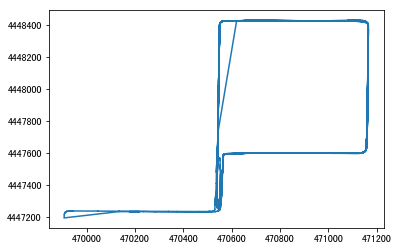

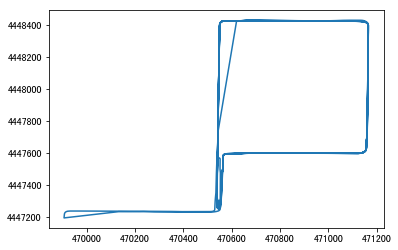

重新排序


time  position_x  position_y  linearvelocity_x  linearvelocity_y  \
0 1589348401.000  471162.675 4447994.912             0.016             1.605   
1 1589348401.100  471162.675 4447995.039             0.002             1.570   
2 1589348401.200  471162.677 4447995.216             0.021             1.553   
3 1589348401.300  471162.679 4447995.351             0.023             1.540   
4 1589348401.400  471162.681 4447995.436             0.026             1.494   
5 1589348401.500  471162.683 4447995.589             0.033             1.462   
6 1589348401.600  471162.688 4447995.778             0.030             1.330   
7 1589348401.700  471162.691 4447995.923             0.029             1.251   
8 1589348401.800  471162.693 4447996.041             0.016             1.202   
9 1589348401.900  471162.695 4447996.152             0.013             1.119   

   linearacceleration_x  linearacceleration_y  heading  
0                -0.112                -0.794    1.578  
1                -0.023                -0.738    1.578  
2                -0.133                -0.790    1.578  
3                -0.012                -0.631    1.578  
4                -0.049                -0.493    1.578  
5                -0.120                -0.559    1.578  
6                -0.103                -0.262    1.578  
7                -0.081                -0.258    1.578  
8                -0.026                -0.265    1.578  
9                -0.040                -3.593    1.578

In [6]:
#取消科学计数法的显示形式
pd.set_option('float_format', lambda x: '%.3f' % x)
#显示前10列的内容
df_localization.show(10,False)
#将信息---> list
localization_info = df_localization.collect()
#list转pandas,并重命名, time为str类型
data = DataFrame(localization_info)
data.columns = ['time','position_x','position_y','linearvelocity_x','linearvelocity_y','linearacceleration_x','linearacceleration_y','heading']
data['time'] = data['time'].astype(float)
#对time列去重，inplace = True表示在原数据的基础上做修改
# data.drop_duplicates('time',inplace= True)
#去重后画出轨迹图
position_x = data['position_x']
position_y = data['position_y']
plt.plot(position_x,position_y)
plt.show()
#将time列保留一位小数，若不加 “data=”,则只产生一个副本
# data = data.round({'time':1})
#对time去重
data.drop_duplicates('time',inplace= True)
#再次画出轨迹图
position_x_ = data['position_x']
position_y_ = data['position_y']
plt.plot(position_x_,position_y_)
plt.show()
data.head(10)
#index重新排序
print("重新排序")
data.reset_index(drop = True, inplace= True)
data.head(10)

In [7]:
data.shape[0]

38683

# 主车规划轨迹信息
获取时间，is_replan标志位，离散轨迹点信息 <p>

In [8]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import json

In [9]:
df_planning_121 = sqlCtx.sql(''' select time,is_replan,trajectory_point from mart_wallepnc_hulk.planning_121 limit 45000 ''')
df_planning_68 = sqlCtx.sql(''' select time,is_replan,trajectory_point from mart_wallepnc_hulk.planning_68 limit 45000 ''')
df_planning_other = sqlCtx.sql(''' select time,is_replan,trajectory_point from mart_wallepnc_hulk.planning_other limit 45000 ''')

1.将主车规划信息转化为pandas数据类型 <p>
2.对各列重命名 <p>
3.定义处理离散轨迹点的函数，将其按行排列 <p>
4.获取了replan == true对应的信息，此刻为对应轨迹点超过阈值时重新规划的时刻 <p>

In [10]:
planning_info_121 = df_planning_121.collect()
data_planning_121_ = DataFrame(planning_info_121)
data_planning_121_.columns = ['time','is_replan','trajectory']

In [11]:
planning_info_68 = df_planning_68.collect()
data_planning_68_ = DataFrame(planning_info_68)
data_planning_68_.columns = ['time','is_replan','trajectory']

In [ ]:
# planning_info_121 = df_planning_121.collect()
# planning_info_68 = df_planning_68.collect()
# # planning_info_other = df_planning_other.collect()
# data_planning_121_ = DataFrame(planning_info_121)
# data_planning_68_ = DataFrame(planning_info_68)
# # data_planning_other_ = DataFrame(planning_info_other)
# data_planning_121_.columns = ['time','is_replan','trajectory']
# data_planning_68_.columns = ['time','is_replan','trajectory']
# # data_planning_other_.columns = ['time','is_replan','trajectory']

In [12]:
#对轨迹点进行处理
def flatten_json(df,column_name):
    #basic = [list_points, list_points, ....]
    basic = []
    #每一帧对应离散点的size
    list_points = []
    for index,i in enumerate(df[column_name]):
        list_points = json.loads(i)
        #json.load(i) == list
        basic.append(list_points)
    flatten_columns = pd.DataFrame(basic)
    df = pd.concat([df,flatten_columns],axis=1)
    df = df.drop([column_name],axis=1)
    return df

经统计，离散点size完整的行数约为20000行，非完整的行数约为10000行，2:1的比例

In [13]:
data_planning_121 = flatten_json(data_planning_121_, 'trajectory')
data_planning_68 = flatten_json(data_planning_68_, 'trajectory')

In [21]:
# data_planning = flatten_json(data_planning_, 'trajectory')
pd.set_option('float_format', lambda x: '%.3f' % x)
print(121)
data_planning_121.head(2)
print(68)
data_planning_68.head(2)
planning_replan_true_121 = pd.DataFrame(data_planning_121)
# planning_replan_true = data_planning[data_planning['is_replan'] == 'true']
planning_replan_true_68 = pd.DataFrame(data_planning_68)
planning_replan_true_121.head(3)
planning_replan_true_68.head(3)

121
68


time is_replan  \
0  1.5893484257E9      true   
1  1.5893484258E9      true   
2  1.5893484259E9      true   

                                                   0  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.736...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.737...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.738...   

                                                   1  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.735...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.735...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.736...   

                                                   2  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.734...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.734...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.735...   

                                                   3  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.732...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.732...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.733...   

                                                   4  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.731...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.731...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.731...   

                                                   5  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.729...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.729...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.730...   

                                                   6  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.728...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.728...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.729...   

                                                   7  ...  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.727...  ...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.727...  ...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.727...  ...   

                                                  58  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.730...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.730...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.729...   

                                                  59  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.735...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.735...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.735...   

                                                  60  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.741...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.741...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.741...   

                                                  61  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.747...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.747...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.747...   

                                                  62  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.753...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.753...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.753...   

                                                  63  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.758...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.759...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.759...   

                                                  64  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.764...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.764...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.765...   

                                                  65  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.770...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.770...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.771...   

                                                  66  \
0  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.776...   
1  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.776...   
2  {'pathPoint': {'ddkappa': 0.0, 'x': 471162.777...   

                                           

In [24]:
planning_replan_true_121.shape[0]

19887

In [25]:
planning_replan_true_68.shape[0]

11772

In [17]:
# #30000多行，说明时刻replan
# planning_replan_true.shape[0]

In [18]:
# #获取replan时前一帧的规划轨迹
# planning_before_replan_true_ = []
# for index, val in planning_replan_true.iterrows():
#     time_before_replan = val['time']
#     row_time_replan = data_planning[data_planning['time'].isin([time_before_replan])]
#     row_time_before_replan_index = row_time_replan.index[0] -1
#     row_before_replan = pd.DataFrame(data_planning.iloc[row_time_before_replan_index:row_time_before_replan_index+1])
#     planning_before_replan_true_.append(row_before_replan)
# planning_before_replan_true = pd.concat(planning_before_replan_true_, axis = 0)

In [19]:
# planning_before_replan_true = pd.DataFrame(planning_before_replan_true)
# # planning_before_replan_true

In [22]:
#index重新排序,但是查询数据时已经分开
# planning_replan_true.reset_index(drop = True, inplace= True)
# planning_before_replan_true.reset_index(drop = True, inplace = True )

1.定义处理离散轨迹点的函数，提取我们需要的信息 <p>
2.构建对应的dataframe，对于间隔为0.02s的轨迹点，每隔五个取一次，对于间隔为0.1s的轨迹点，直接读取 <p>
3.将replan = true的dataframe合并 <p>
4.通过heading以及线速度，加速度获取对应x,y方向的投影信息

In [65]:
#目前所有点的is_replan都是true,先计划每隔一段时间取一次轨迹
#离散轨迹点信息过滤器,time interval = 0.1s
def trajectory_info_filter(planning_replan_true, threshold_points_size = 119):
    time_replan_true = []
    plan_position_x = []
    plan_position_y = []
    #线速度
    plan_velocity = []
    #加速度
    plan_acc = []
    #离散轨迹点对应的时间戳
    time_trajectory = []
    #theta
    plan_theta = []
    #取80个点
#     threshold_times = 80
  #
    index_time_replan_true = 0
    # for val in planning_replan_true['time']:
    #     time_replan_true.append(val)
    for i, row  in planning_replan_true.iterrows():
        #每隔50s采样一次
        if(i % 500) is not 0:
            continue
        tmp_plan_position_x = []
        tmp_plan_position_y = []
        tmp_plan_velocity = []
        tmp_plan_acc = []
        tmp_time_trajectory = []
        tmp_plan_theta = []
        #离散轨迹点时间间隔初始化
        discre_time_diff = 0.0
        #构建对应时间戳数组结构, 其中row为pandas.core.series.Series结构
        time_replan_true.append(row['time'])
        #去除row中的time,is_replan列
        row.pop('time')
        row.pop('is_replan')
        #取每行初始时刻的relativeTime
        start_time = row[0]['relativeTime']
        for index, val in enumerate(row):
            if(index > threshold_points_size):
                break
#             print(val)
            #计算下一时刻与当前时刻的的时间差
            time_diff = row[index + 1]['relativeTime'] - start_time
            #时刻更新start_time的值
            start_time = row[index + 1]['relativeTime']
            if(np.fabs(time_diff - 0.02) < 0.0001 or np.fabs(time_diff - 0.1) < 0.0001):
                #若相邻时间差值为0.02s，每隔5帧取一次，若相邻间隔为1s，则直接获取
                if(index % 5 is not 0 and np.fabs(time_diff - 0.02) < 0.0001):
                    continue
#                 if(index > threshold_points_size):
#                         break
                tmp_plan_acc.append(val['a'])
                tmp_plan_velocity.append(val['v'])
                tmp_plan_position_x.append(val['pathPoint']['x'])
                tmp_plan_position_y.append(val['pathPoint']['y'])
                tmp_plan_theta.append(val['pathPoint']['theta'])
                #从re_plan == true时刻开始，记录规划轨迹的时间，为了方便计算，同时取一位小数
                tmp_time_trajectory.append( np.round(float(time_replan_true[index_time_replan_true]) +  discre_time_diff,1))
                discre_time_diff += 0.1 
        index_time_replan_true += 1
        #输出为
        plan_acc.append(tmp_plan_acc)
        plan_velocity.append(tmp_plan_velocity)
        plan_position_x.append(tmp_plan_position_x)
        plan_position_y.append(tmp_plan_position_y)
        time_trajectory.append(tmp_time_trajectory)
        plan_theta.append(tmp_plan_theta)
    return time_replan_true, plan_position_x, plan_position_y, plan_velocity, plan_acc, time_trajectory, plan_theta

trajectory_info_filter()函数默认参数为119，即取120；当引用第二个数据集（68）时，参数改为66

In [66]:
# threshold_points_size = 119
time_replan_true_121, plan_position_x_121, plan_position_y_121, plan_velocity_121, plan_acc_121, time_trajectory_121, plan_theta_121 = trajectory_info_filter(planning_replan_true_121)

In [71]:
time_replan_true_68, plan_position_x_68, plan_position_y_68, plan_velocity_68, plan_acc_68, time_trajectory_68, plan_theta_68 = trajectory_info_filter(planning_replan_true_68,66)

In [73]:
# print(len(plan_position_x_68))

In [74]:
#定义整合每个replan=true时的信息的函数
def df_concat_every_replan_func(time_trajectory, plan_position_x, plan_position_y, plan_velocity, plan_acc, plan_theta):
    frames = []
    for i in range(len(plan_position_x)):
        tmp_data = {'time': time_trajectory[i], 
                    'position_x': plan_position_x[i],
                    'position_y': plan_position_y[i],
                    'velocity': plan_velocity[i],
                    'acceleration': plan_acc[i], 
                    'theta':plan_theta[i]}
        tmp_df = pd.DataFrame(tmp_data)
        #这里将线速度，加速度信息通过theta角投影至世界坐标系
        linearvelocity_x = tmp_df['velocity'] * np.cos(tmp_df['theta'])
        linearvelocity_y = tmp_df['velocity'] * np.sin(tmp_df['theta'])
        linearacceleration_x = tmp_df['acceleration'] * np.cos(tmp_df['theta'])
        linearacceleration_y = tmp_df['acceleration'] * np.sin(tmp_df['theta'])
        tmp_new_frame = pd.concat([linearvelocity_x,linearvelocity_y,linearacceleration_x,linearacceleration_y],axis = 1)
        tmp_new_frame.columns = ['linearvelocity_x','linearvelocity_y','linearacceleration_x','linearacceleration_y']
        result = pd.concat([tmp_df,tmp_new_frame], axis = 1)
        
        frames.append(result)
    return frames

In [75]:
#frames里面的每一个index对应每个replan = true的时刻
frames_121 = df_concat_every_replan_func(time_trajectory_121, plan_position_x_121, plan_position_y_121, plan_velocity_121, plan_acc_121, plan_theta_121)

In [76]:
frames_68 = df_concat_every_replan_func(time_trajectory_68, plan_position_x_68, plan_position_y_68, plan_velocity_68, plan_acc_68, plan_theta_68)

In [82]:
#定位信息
localization_data_info = data

In [94]:
localization_data_info.head(10)

time  position_x  position_y  linearvelocity_x  linearvelocity_y  \
0 1589348401.000  471162.675 4447994.912             0.016             1.605   
1 1589348401.100  471162.675 4447995.039             0.002             1.570   
2 1589348401.200  471162.677 4447995.216             0.021             1.553   
3 1589348401.300  471162.679 4447995.351             0.023             1.540   
4 1589348401.400  471162.681 4447995.436             0.026             1.494   
5 1589348401.500  471162.683 4447995.589             0.033             1.462   
6 1589348401.600  471162.688 4447995.778             0.030             1.330   
7 1589348401.700  471162.691 4447995.923             0.029             1.251   
8 1589348401.800  471162.693 4447996.041             0.016             1.202   
9 1589348401.900  471162.695 4447996.152             0.013             1.119   

   linearacceleration_x  linearacceleration_y  heading  
0                -0.112                -0.794    1.578  
1                -0.023                -0.738    1.578  
2                -0.133                -0.790    1.578  
3                -0.012                -0.631    1.578  
4                -0.049                -0.493    1.578  
5                -0.120                -0.559    1.578  
6                -0.103                -0.262    1.578  
7                -0.081                -0.258    1.578  
8                -0.026                -0.265    1.578  
9                -0.040                -3.593    1.578

In [89]:
#定义比较函数进一步提取我们直接需要的信息，通过frames中的时间戳定位到定位信息中的对应
#时间戳
def trajectories_compare_func(localization_data_info, frames, time_replan_true):
    localization_frames = []
    planning_frames = []
    for index, plan_frame in enumerate(frames):
        each_time = time_replan_true[index]
        #通过replan触发时的时间戳来找到定位信息相应的位置
        certain_row_localization = localization_data_info[localization_data_info['time'].isin([each_time])]
        #如果由于某些原因在定位信息中未找到对应的时间戳，则忽略
        if(certain_row_localization.shape[0] == 0):
            print("can not find corrresponding time {}".format(each_time))
            continue
        #获取对应索引
        certain_index_localization = certain_row_localization.index[0]
#         print(certain_index_localization)
        #获取每次replan=true时轨迹点的size
        size = len(frames[index])
        #对定位信息对应的数据进行相应的切片
        certain_list_localization = localization_data_info.iloc[certain_index_localization : certain_index_localization + size]
        localization_frames.append(certain_list_localization)
        planning_frames.append(frames[index])
    return localization_frames, planning_frames

In [90]:
localization_frames_121, planning_frames_121 = trajectories_compare_func(localization_data_info, frames_121, time_replan_true_121)

can not find corrresponding time 1.5893527334E9
can not find corrresponding time 1.5893528802E9
can not find corrresponding time 1.5893529694E9
can not find corrresponding time 1.5893530452E9
can not find corrresponding time 1.5893531311E9


In [91]:
localization_frames_68, planning_frames_68 = trajectories_compare_func(localization_data_info, frames_68, time_replan_true_68)

can not find corrresponding time 1.5893527218E9
can not find corrresponding time 1.5893529289E9


In [101]:
#作图：轨迹对比图，dx,dy,dvel,dacc随时间的分布图，两轨迹对应点距离随时间分布图
def plot_result(localization_frames, planning_frames):
    for index in range(len(localization_frames)):
        localization_frame = localization_frames[index]
        #对定位信息中的信息从0开始排序，这样可以直接与规划信息进行比较
        localization_frame = localization_frame.reset_index(drop = True, inplace = False)
        planning_frame = planning_frames[index]

        ######定位##################

        loc_position_x = localization_frame['position_x']
        loc_position_y = localization_frame['position_y']
        loc_velocity_x = localization_frame['linearvelocity_x']
        loc_velocity_y = localization_frame['linearvelocity_y']
        loc_heading = localization_frame['heading']
        loc_acc_x = localization_frame['linearacceleration_x']
        loc_acc_y = localization_frame['linearacceleration_y']

        ######planning###############

        pl_position_x = planning_frame['position_x']
        pl_position_y = planning_frame['position_y']
        pl_velocity_x = planning_frame['linearvelocity_x']
        pl_velocity_y = planning_frame['linearvelocity_y']
        pl_acc_x = planning_frame['linearacceleration_x']
        pl_acc_y = planning_frame['linearacceleration_y']
        pl_heading = planning_frame['theta']

        #设定图像显示规格，作图
        plt.figure(figsize=(40,10))
        plt.subplot(1,9,1)
        plt.plot(loc_position_x, loc_position_y, color = 'red', label = 'real trajectory')
        plt.plot(pl_position_x, pl_position_y  ,color = 'green', label = 'planning trajectory')
        plt.legend()
        plt.subplot(1,9,2)
        plt.plot(localization_frame['time'],loc_velocity_x , color = 'black', label ='loc velocity along X direction')
        plt.plot(localization_frame['time'],pl_velocity_x , color = 'blue', label ='plan velocity along X direction')
        plt.legend()
        plt.subplot(1,9,3)
        plt.plot(localization_frame['time'],loc_velocity_y , color = 'black', label ='loc velocity along Y direction')
        plt.plot(localization_frame['time'],pl_velocity_y , color = 'blue', label ='plan velocity along Y direction')
        plt.legend()
        plt.subplot(1,9,4)
        plt.plot(localization_frame['time'],loc_acc_x , color = 'black', label ='loc acc along X direction')
        plt.plot(localization_frame['time'],pl_acc_x , color = 'blue', label ='plan acc along X direction')
        plt.legend()
        plt.subplot(1,9,5)
        plt.plot(localization_frame['time'],loc_acc_y , color = 'black', label ='loc acc along Y direction')
        plt.plot(localization_frame['time'],pl_acc_y , color = 'blue', label ='plan acc along Y direction')
        plt.legend()
        plt.legend()
        plt.subplot(1,9,6)
        plt.plot(localization_frame['time'],loc_velocity_x - pl_velocity_x , color = 'black', label ='vel diff along X direction')
        plt.plot(localization_frame['time'],loc_velocity_y - pl_velocity_y , color = 'blue', label ='vel diff along Y direction')
        plt.legend()
        plt.subplot(1,9,7)
        plt.plot(localization_frame['time'],loc_acc_x - pl_acc_x , color = 'black', label ='acc diff along X direction')
        plt.plot(localization_frame['time'],loc_acc_y - pl_acc_y , color = 'blue', label ='ac diff along Y direction')
        plt.legend()
        plt.subplot(1,9,8)
        plt.plot(localization_frame['time'],np.sqrt(np.power((loc_position_x - pl_position_x),2) + np.power((loc_position_y - pl_position_y),2)),
        color = 'black', label ='distance between corresponding')
        plt.legend()
        plt.subplot(1,9,9)
        plt.plot(localization_frame['time'],loc_heading - pl_heading , color = 'red', label ='heading diff')
        plt.legend()
#         plt.subplot(1,8,2)
#         plt.plot(localization_frame['time'],loc_position_x - pl_position_x , color = 'black', label ='positoin diff along X direction')
#         plt.plot(localization_frame['time'],loc_position_y - pl_position_y , color = 'blue', label ='position diff along Y direction')
#         plt.legend()
        plt.show()

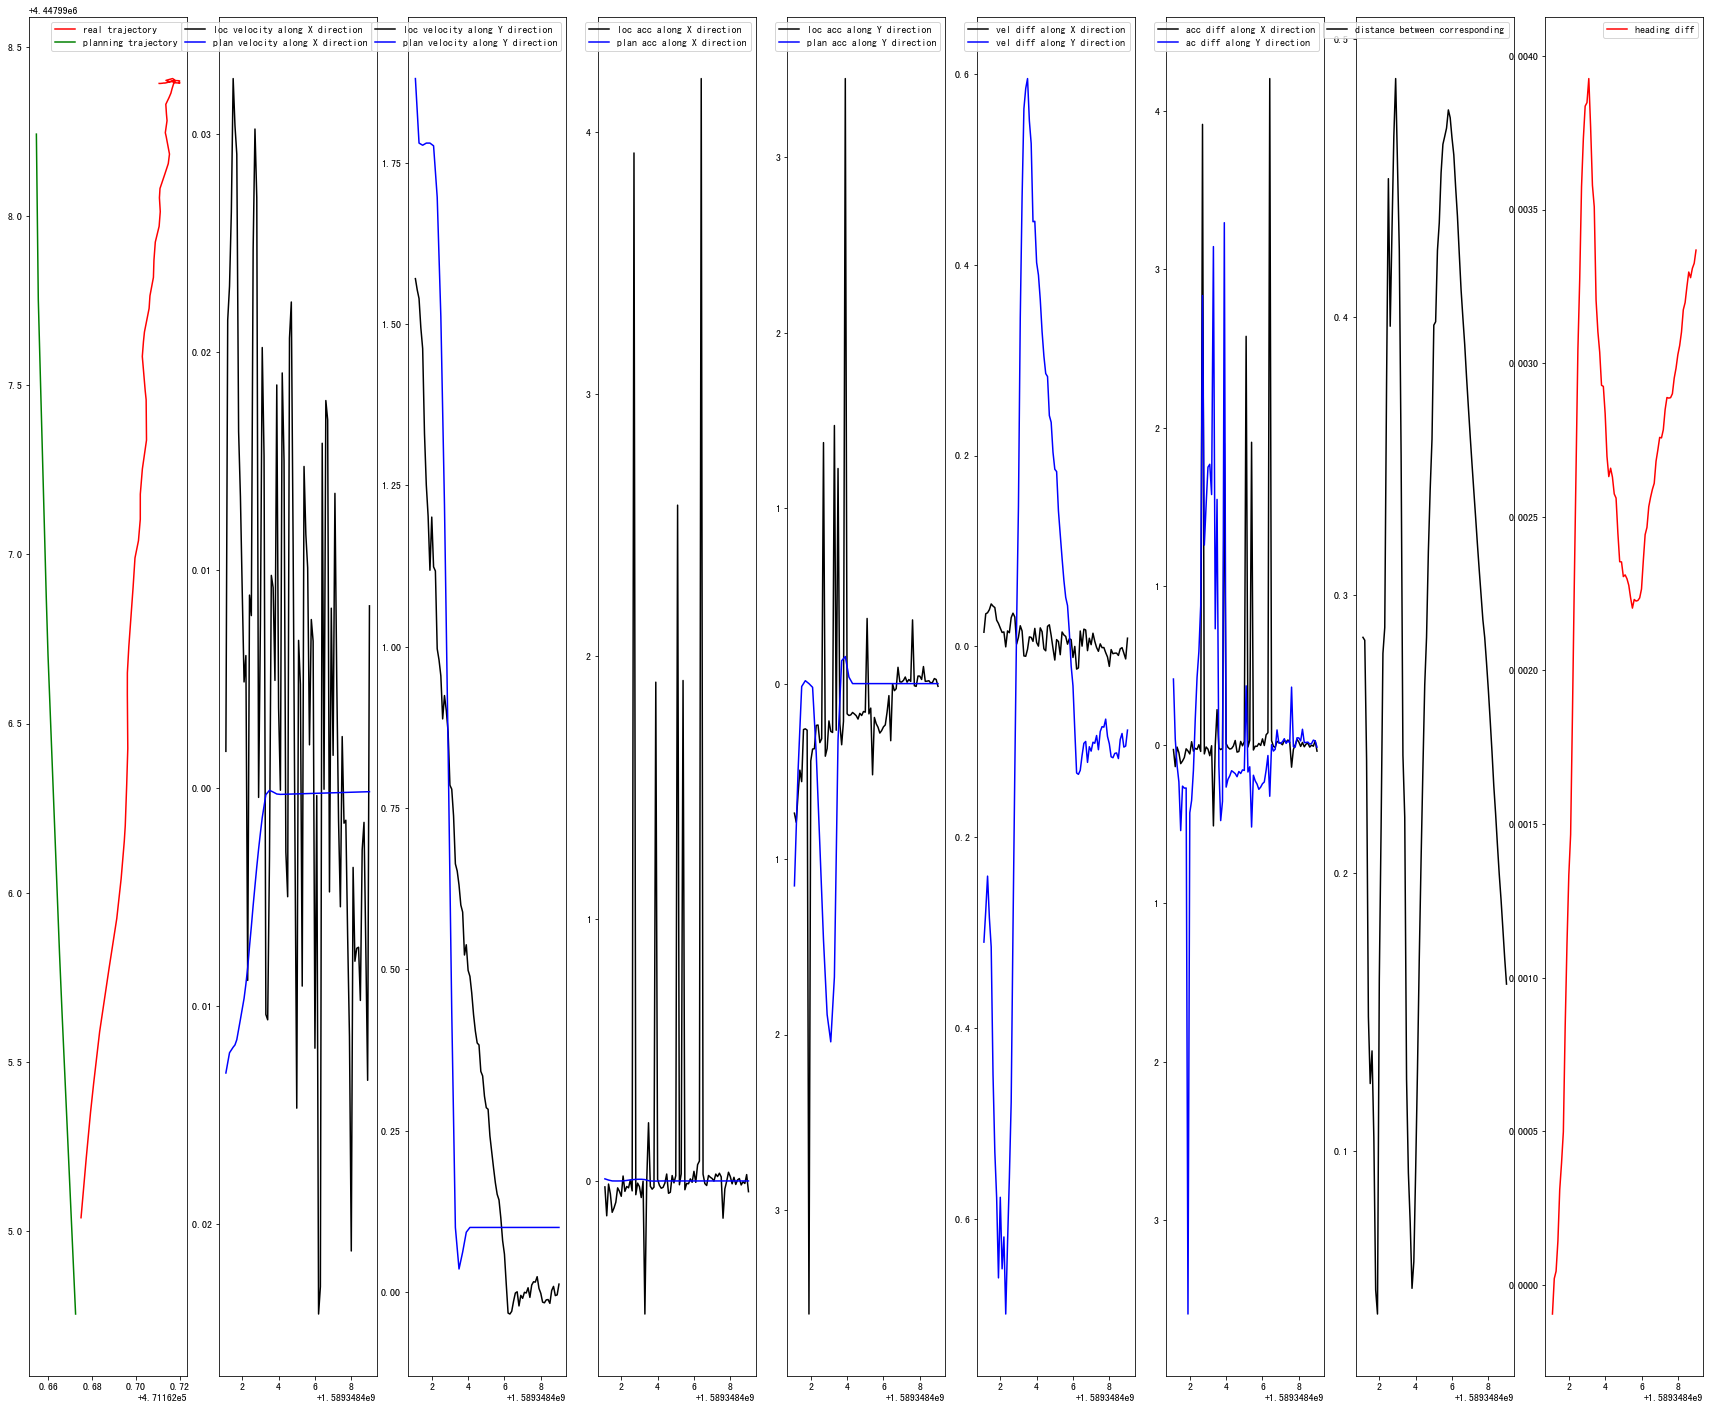

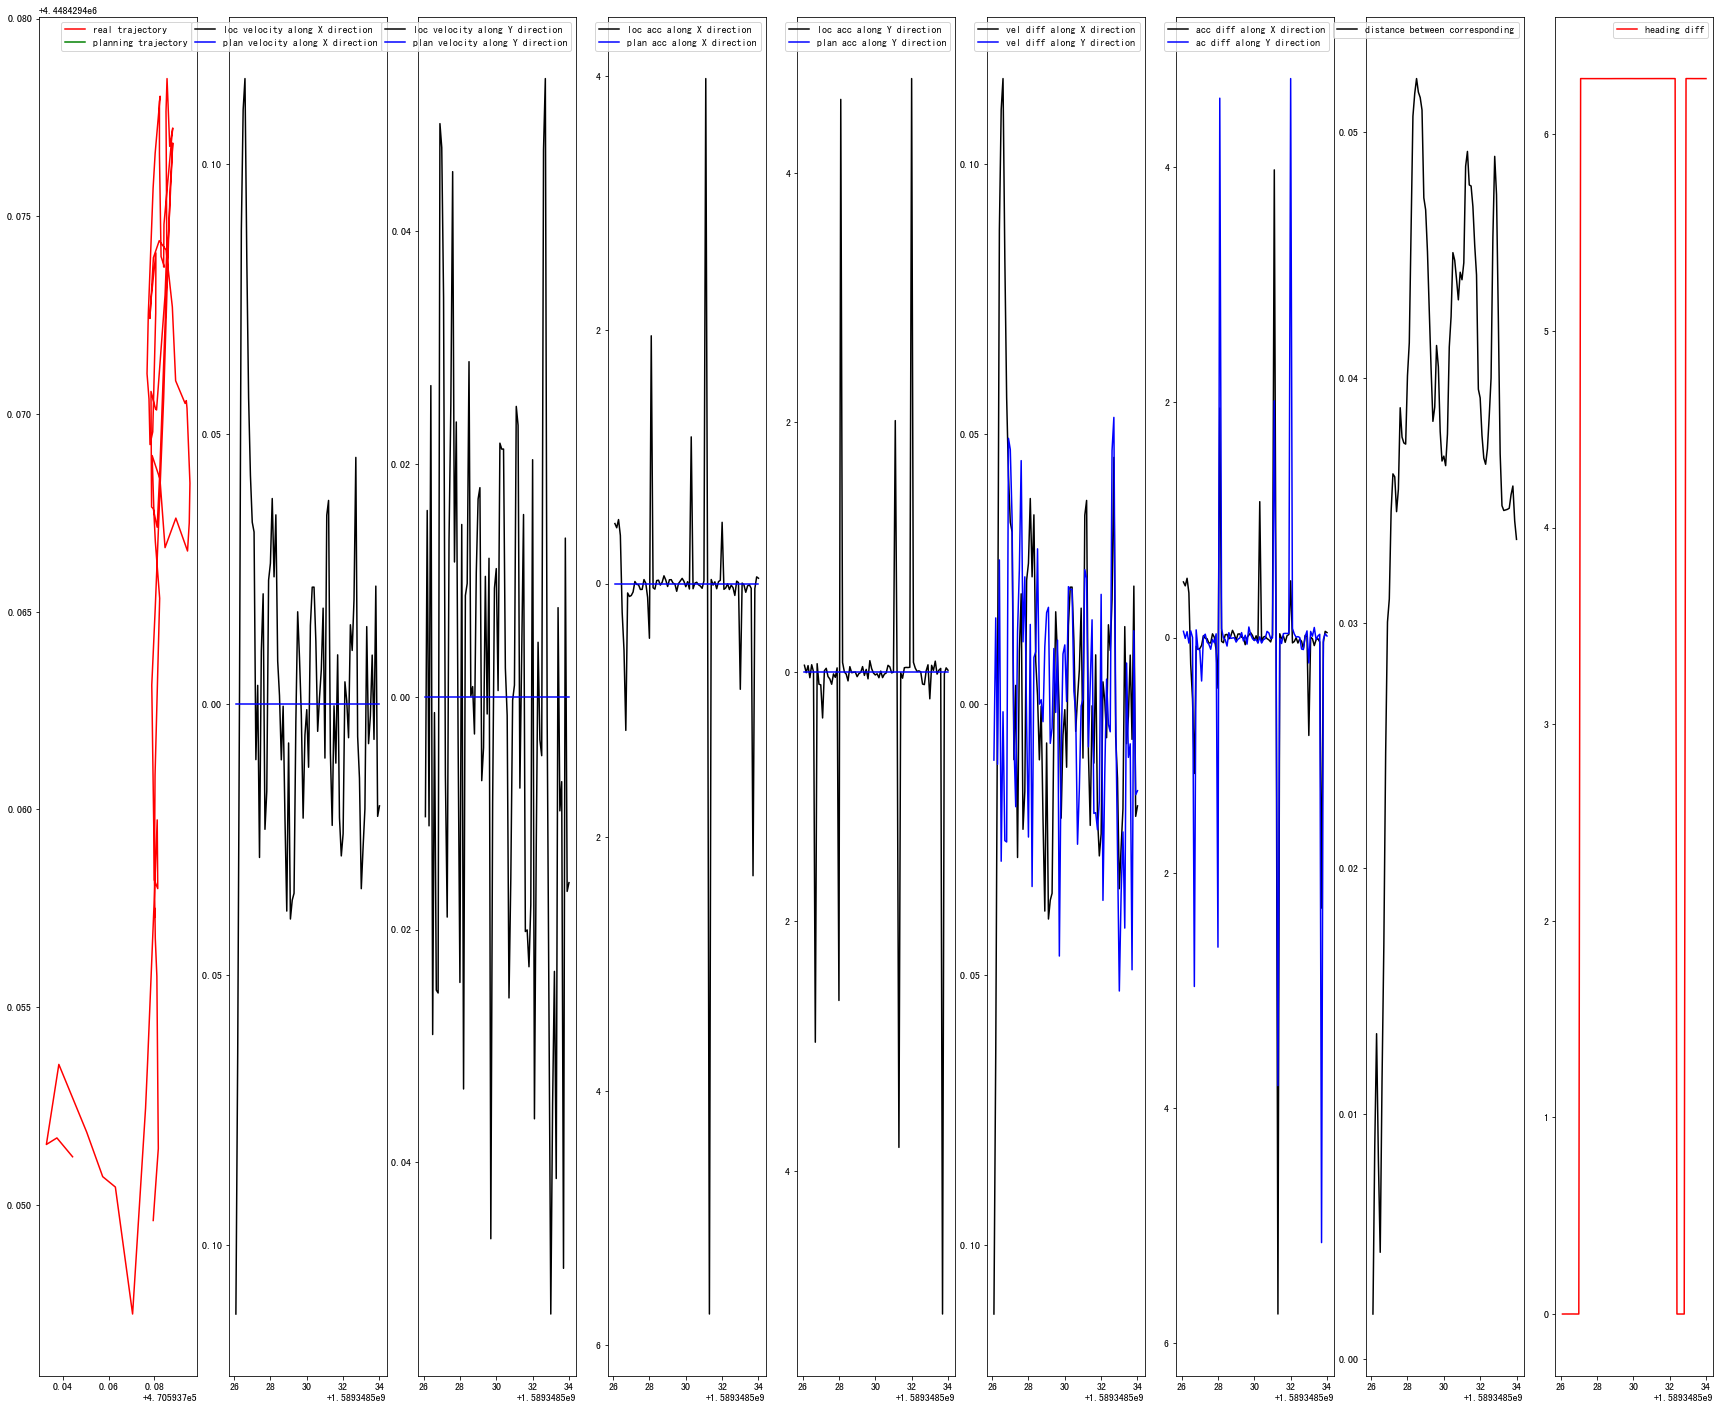

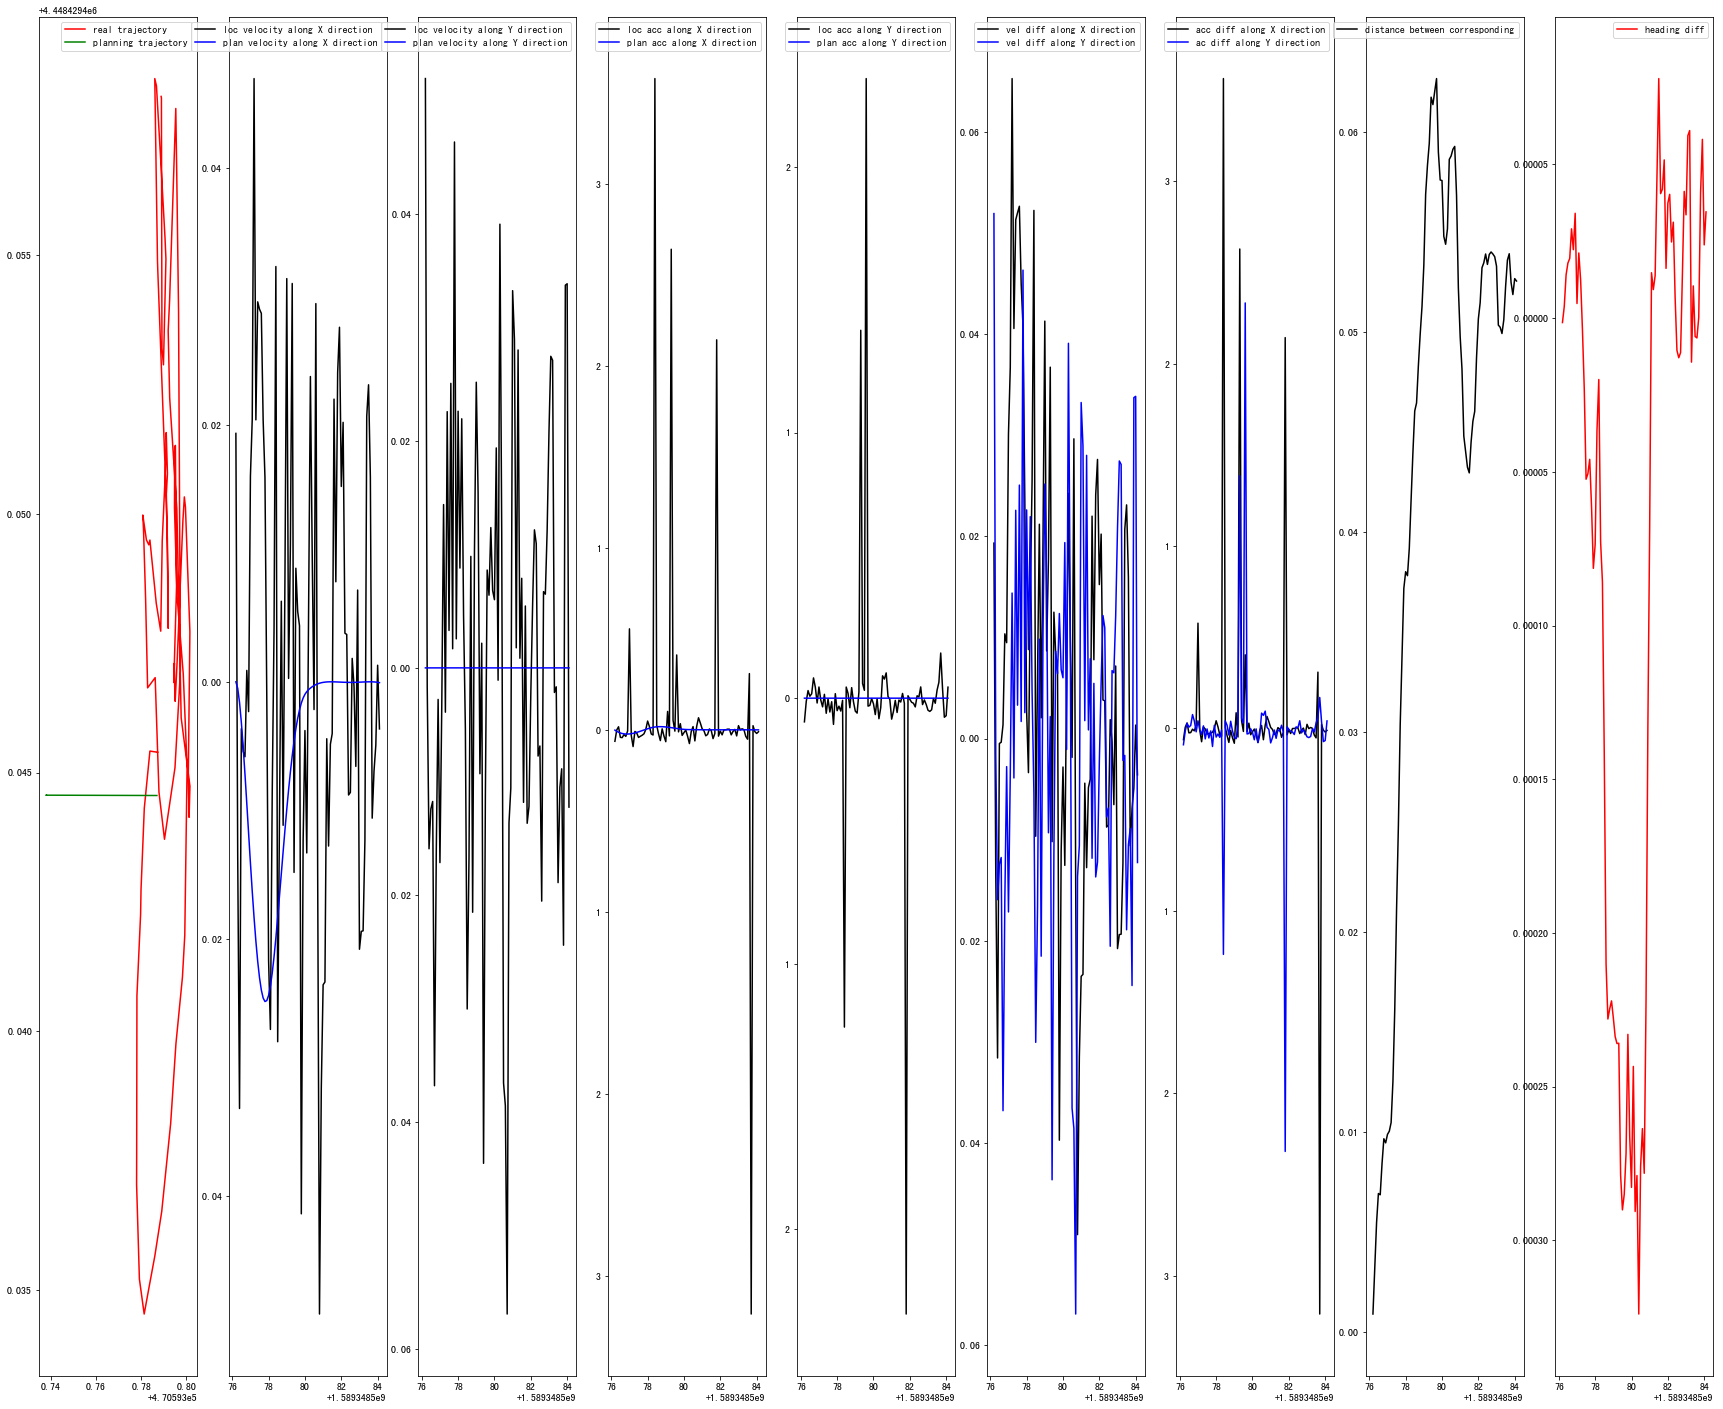

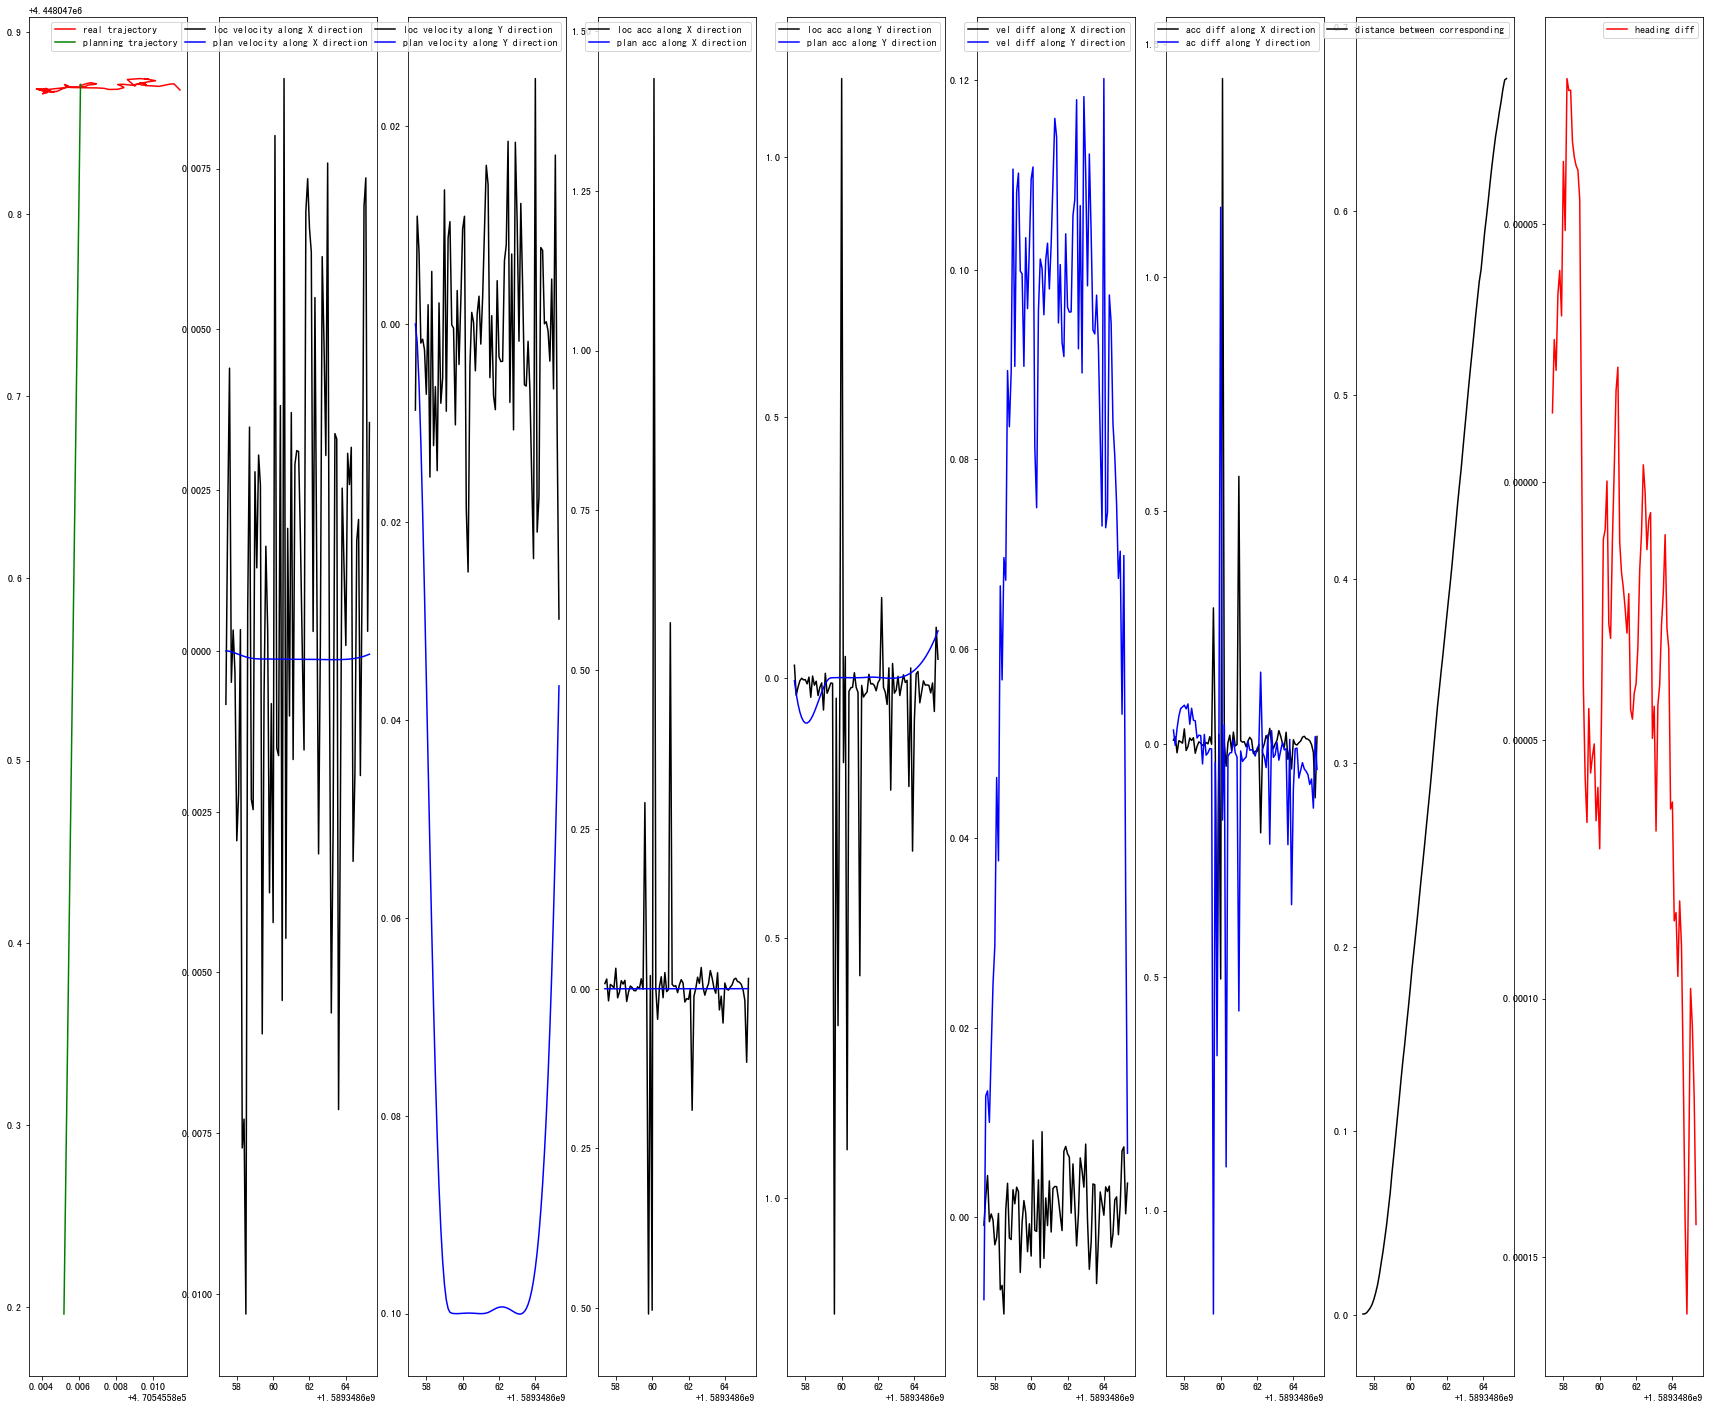

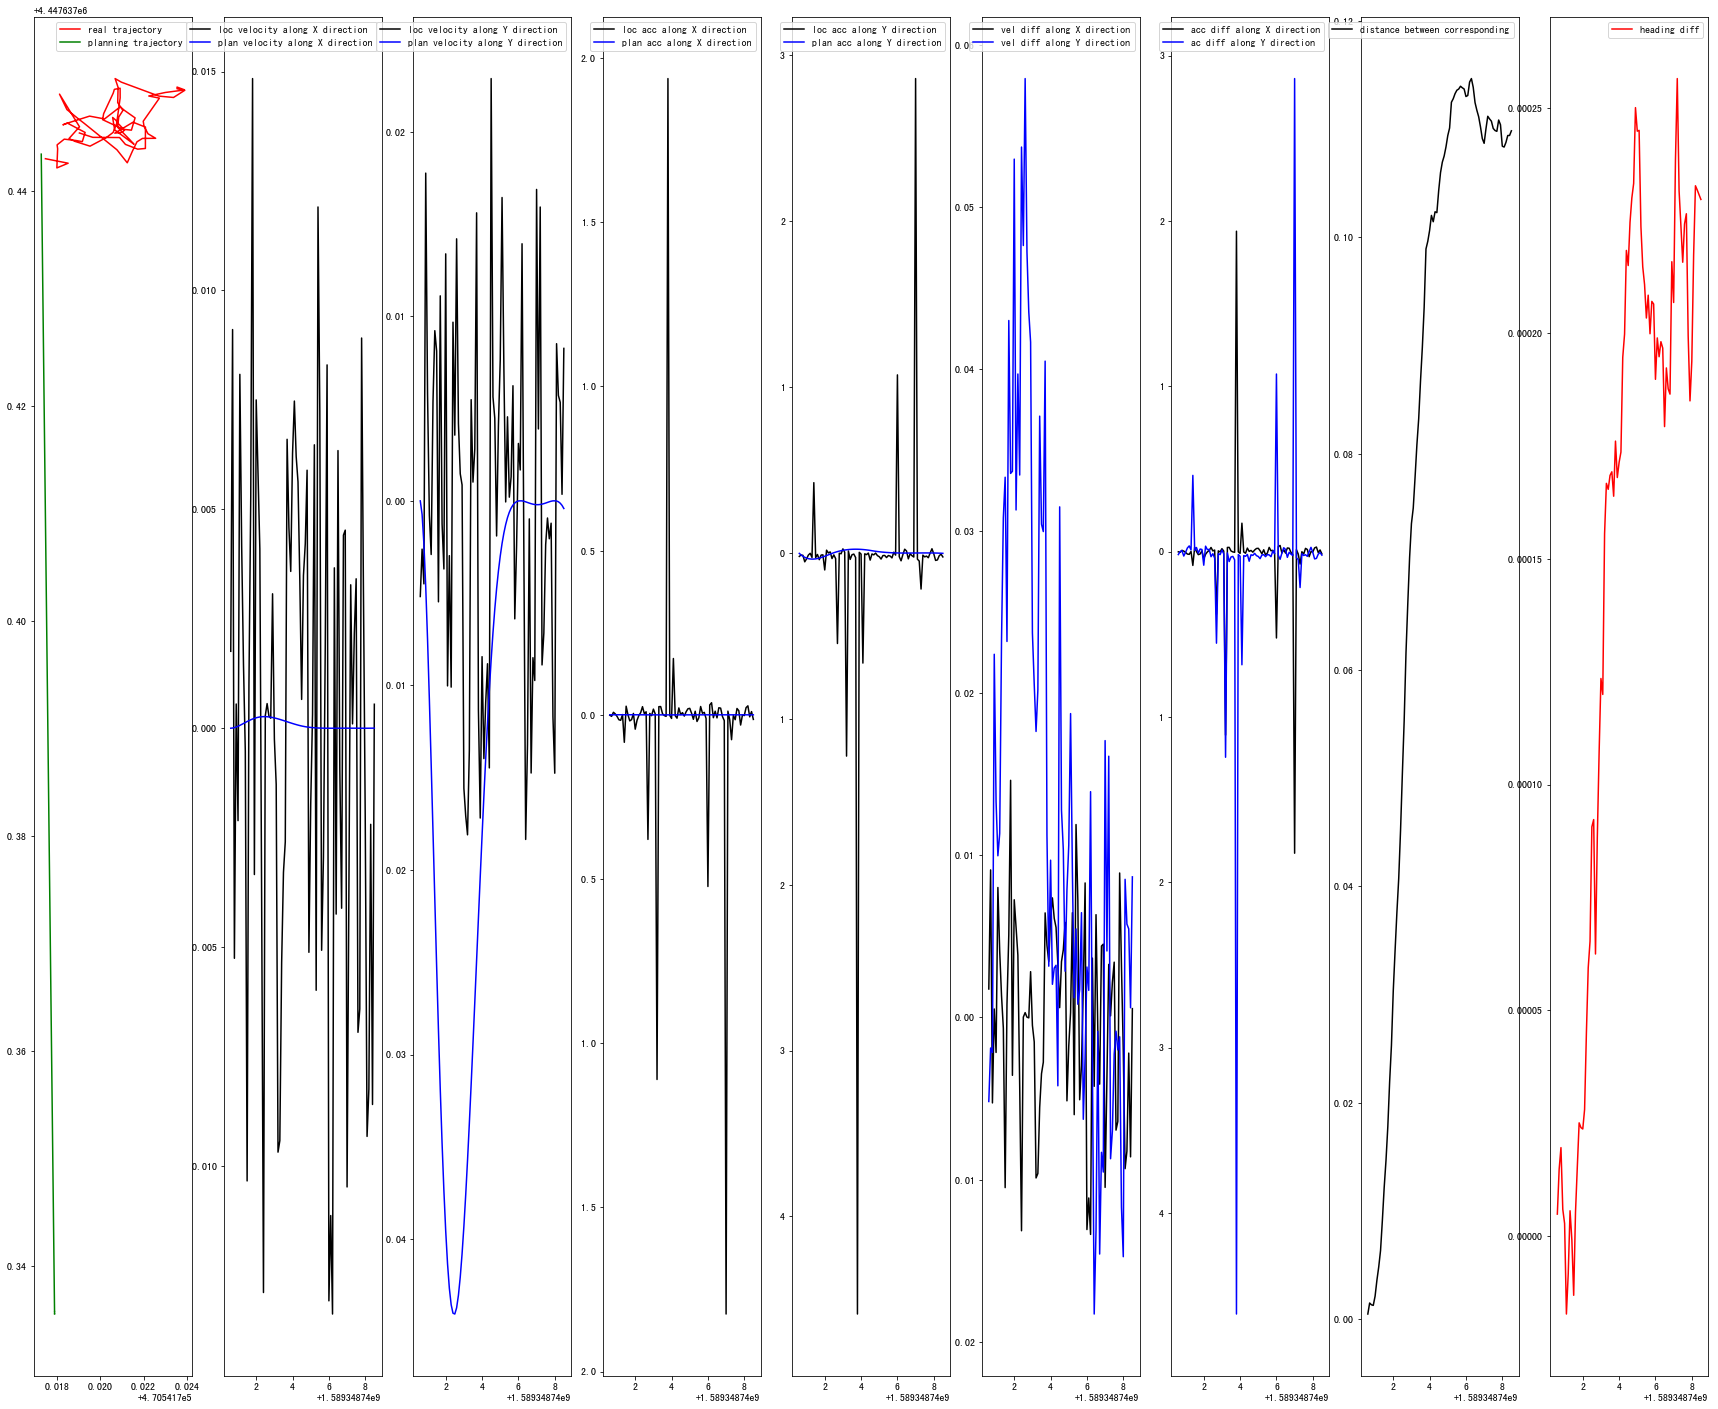

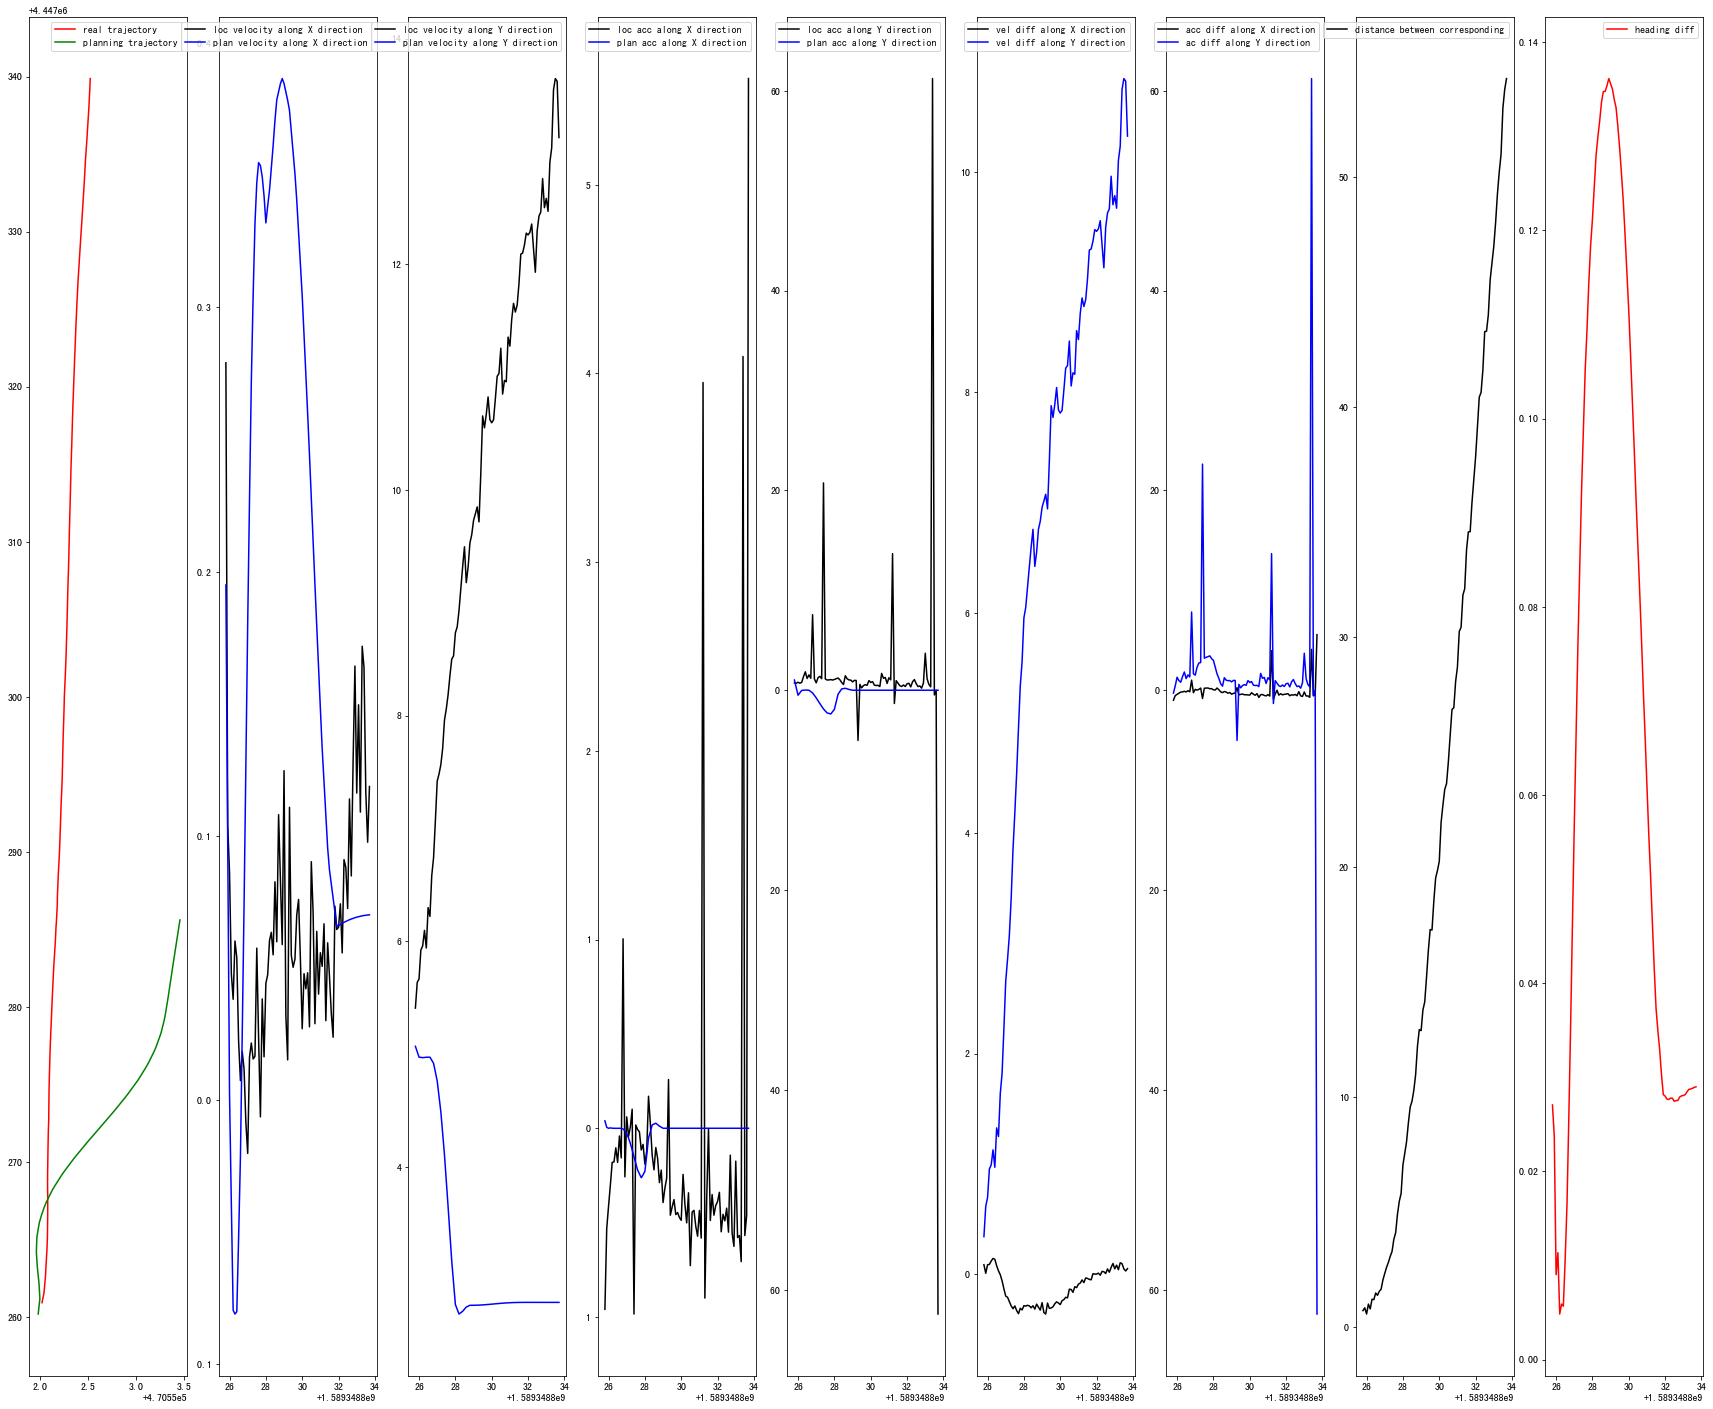

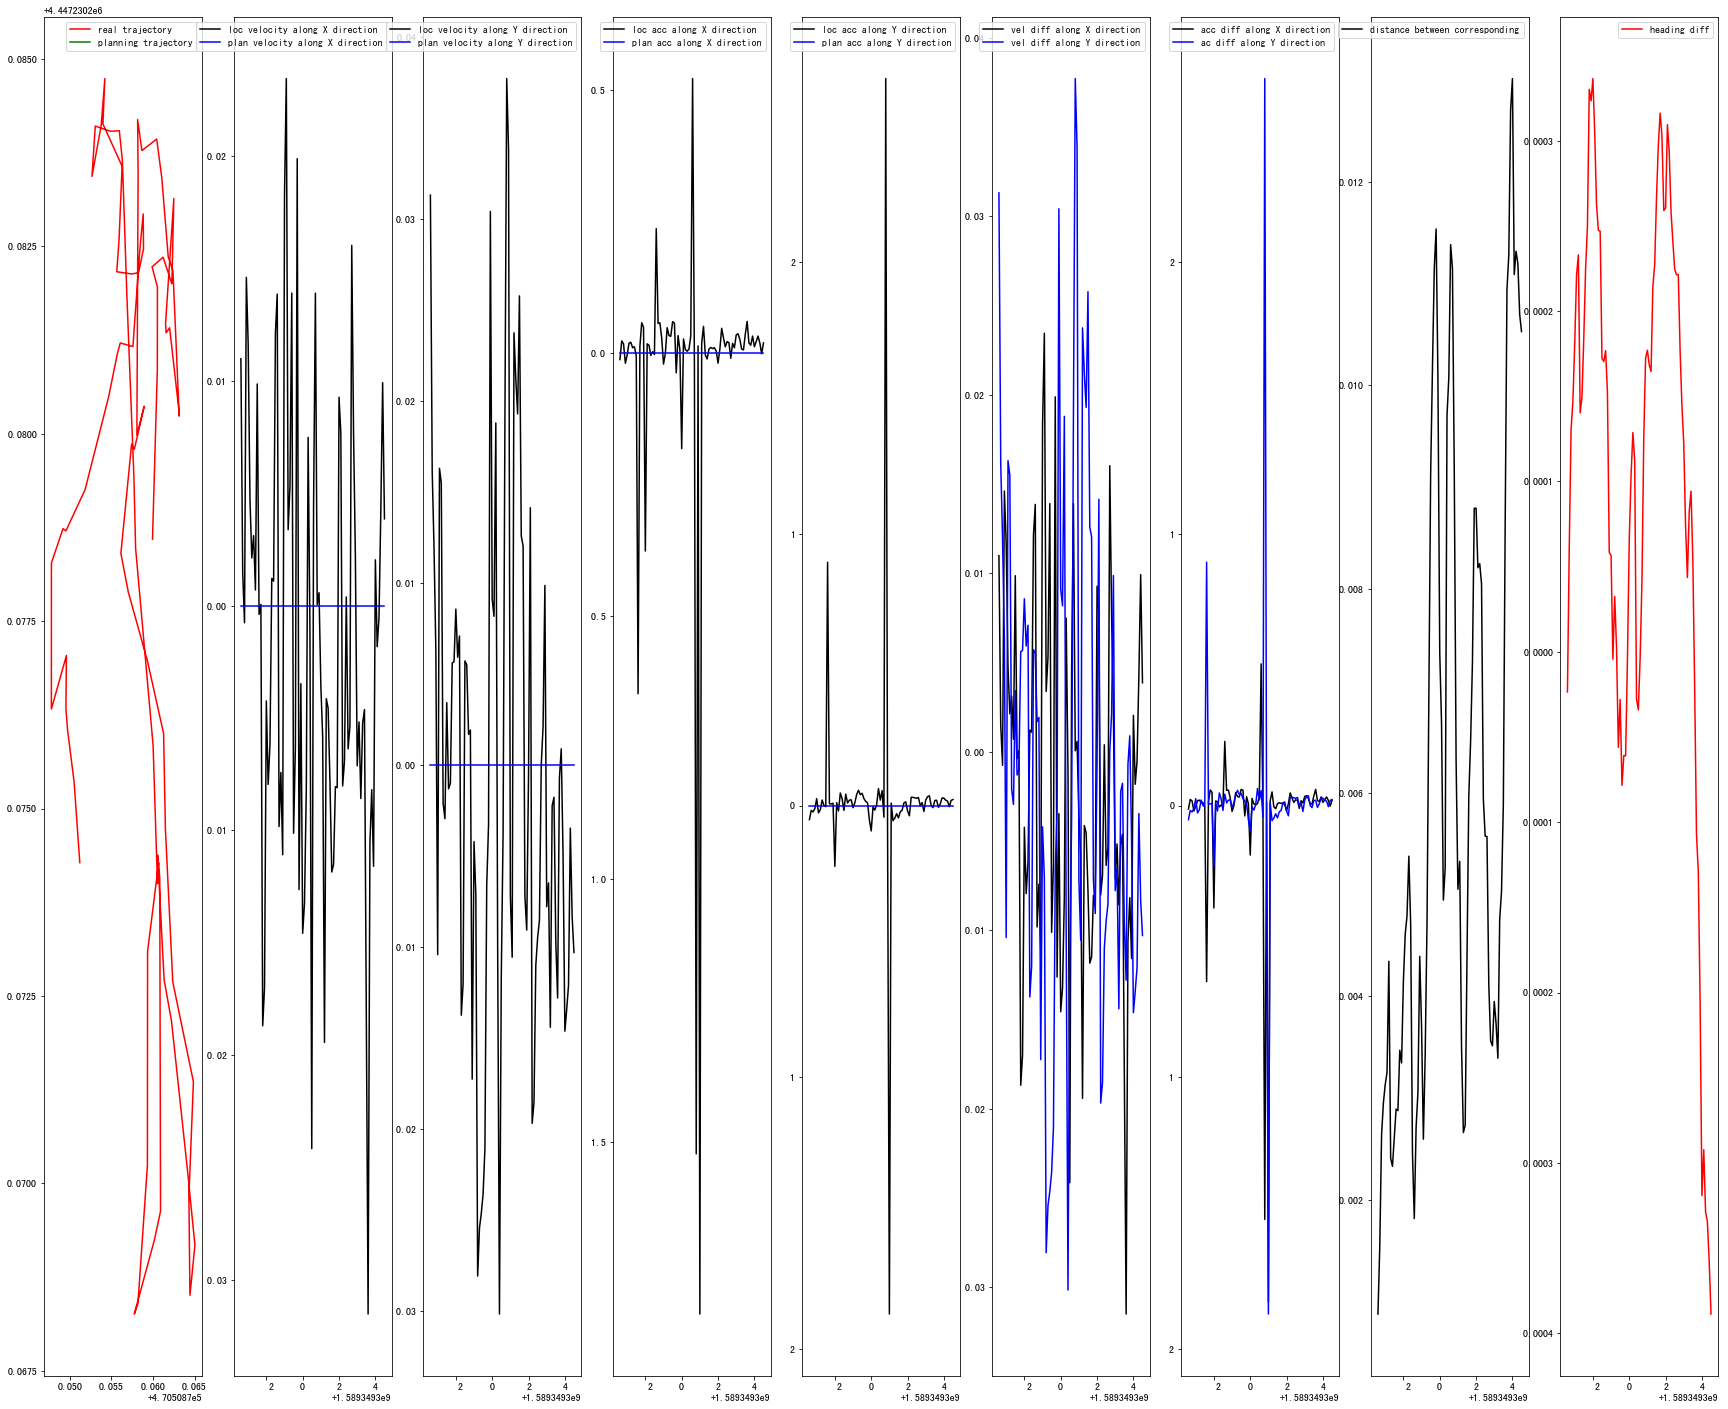

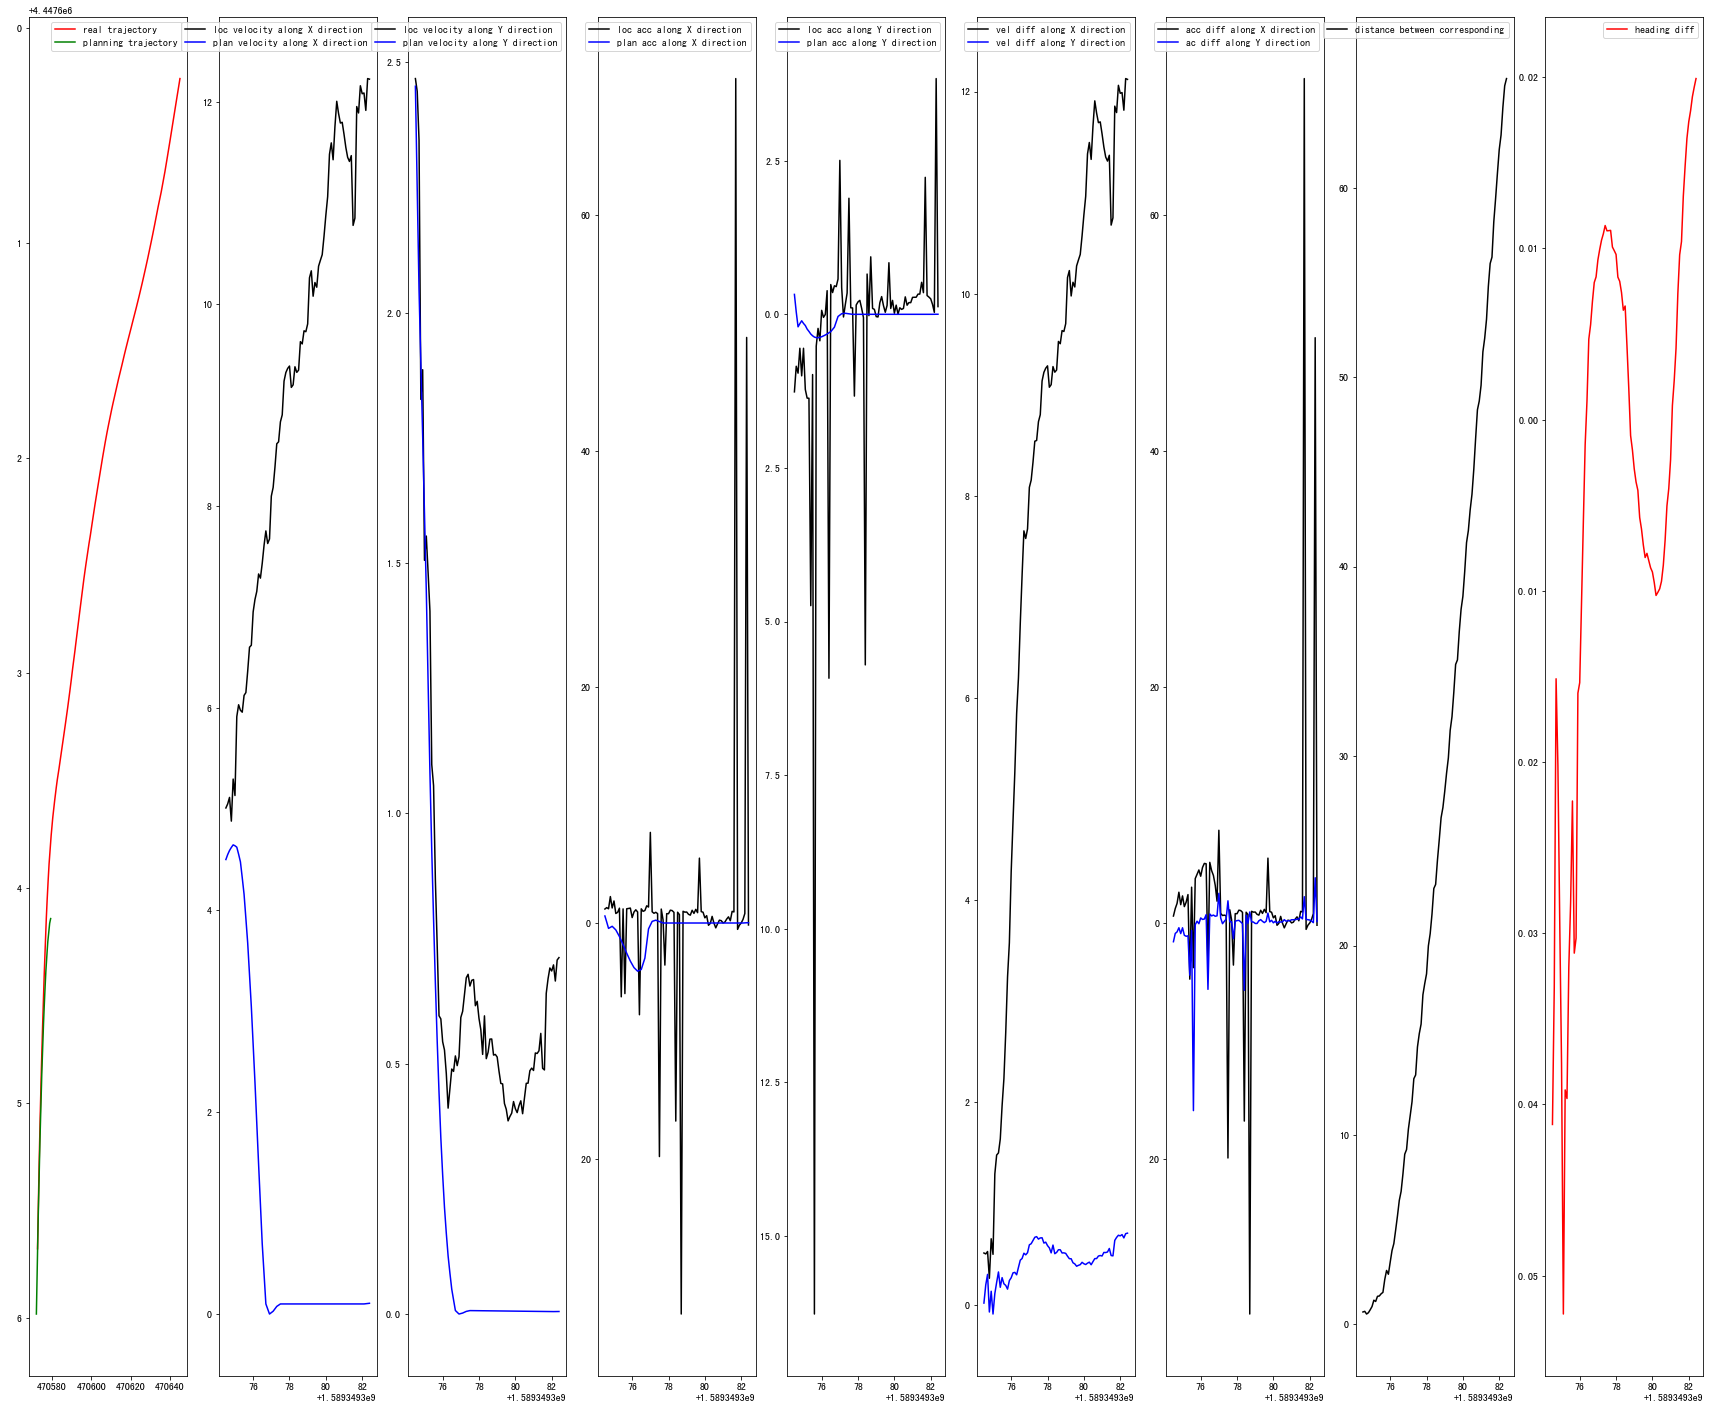

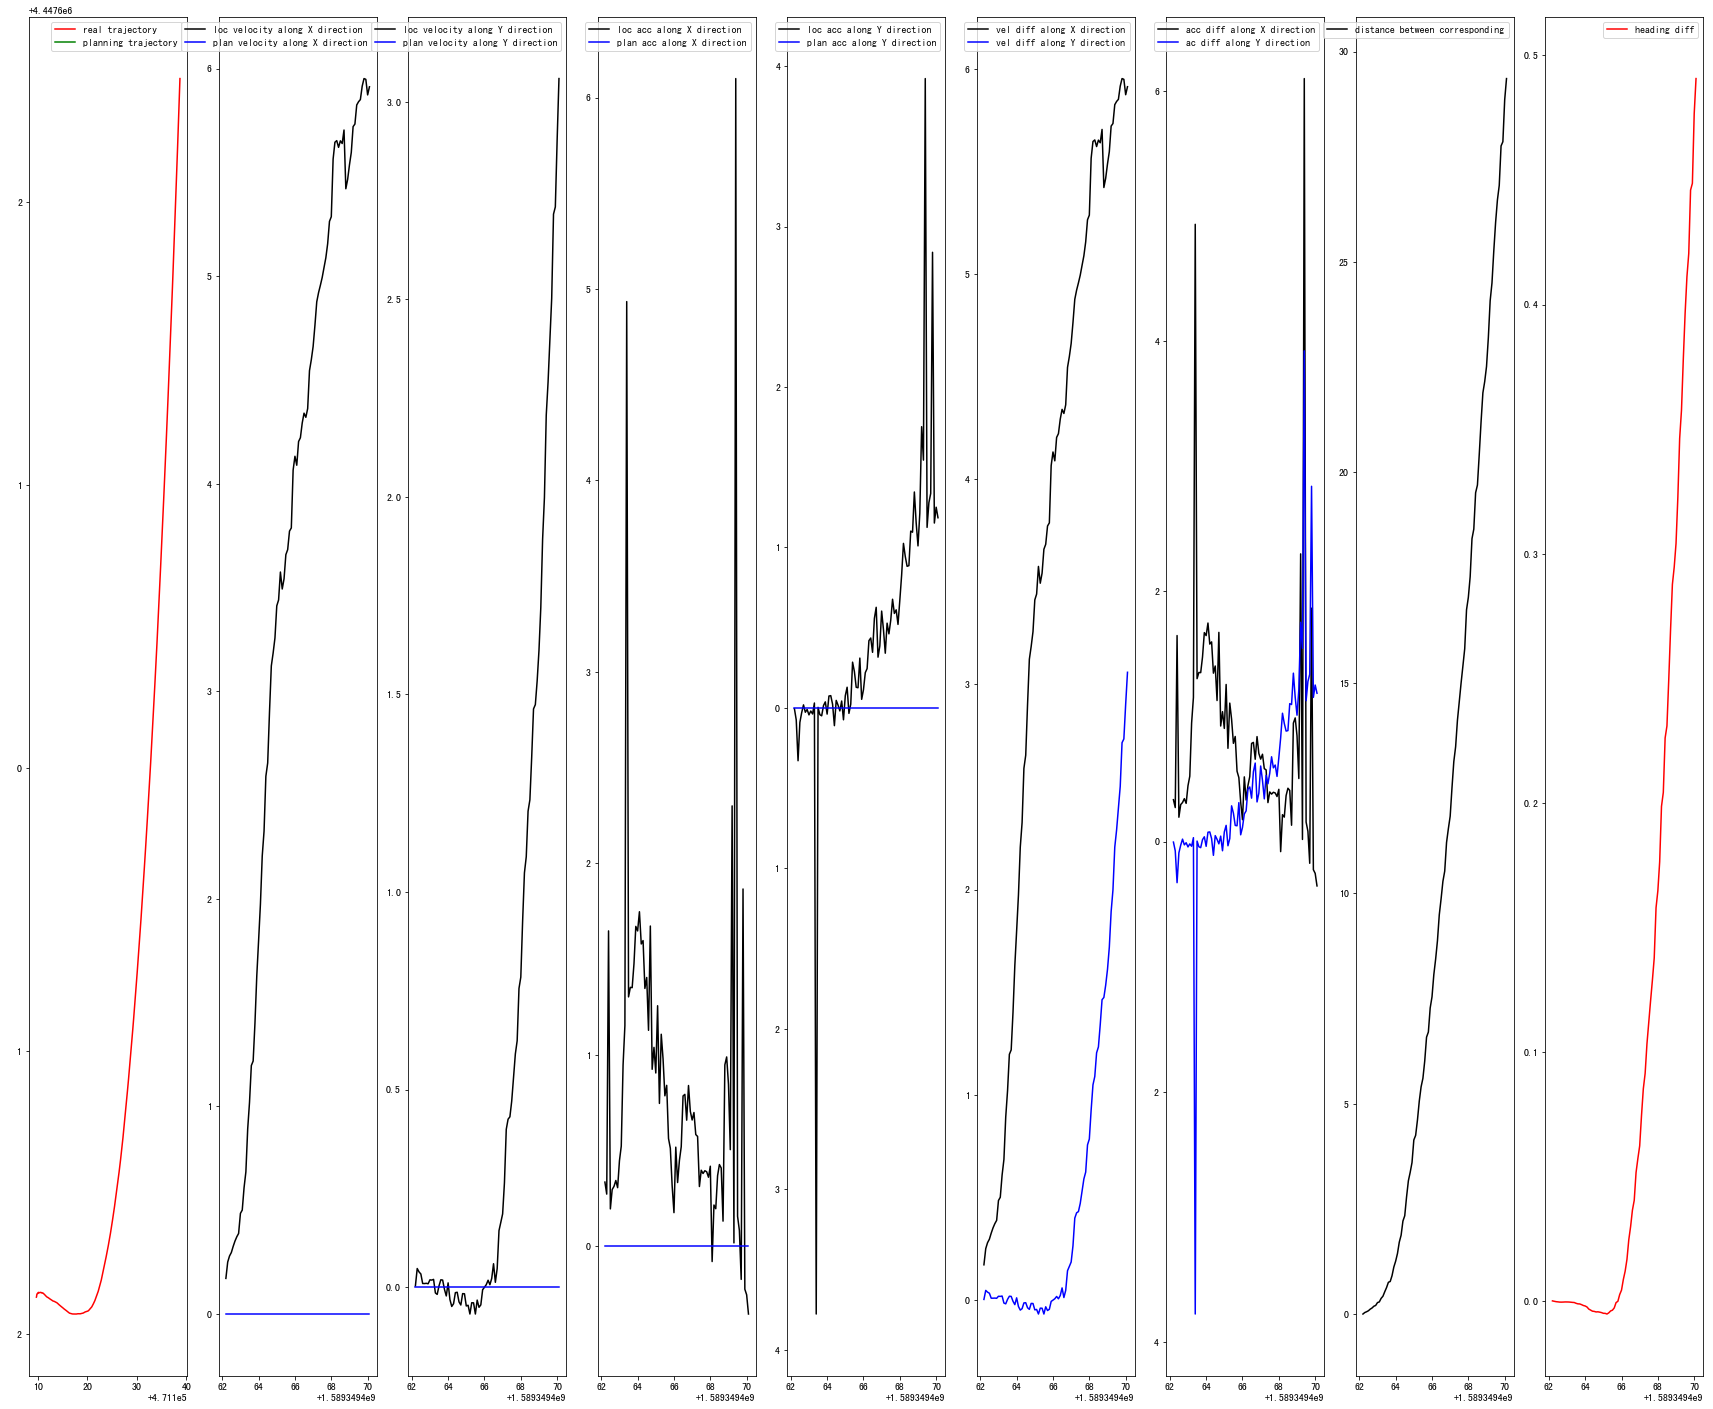

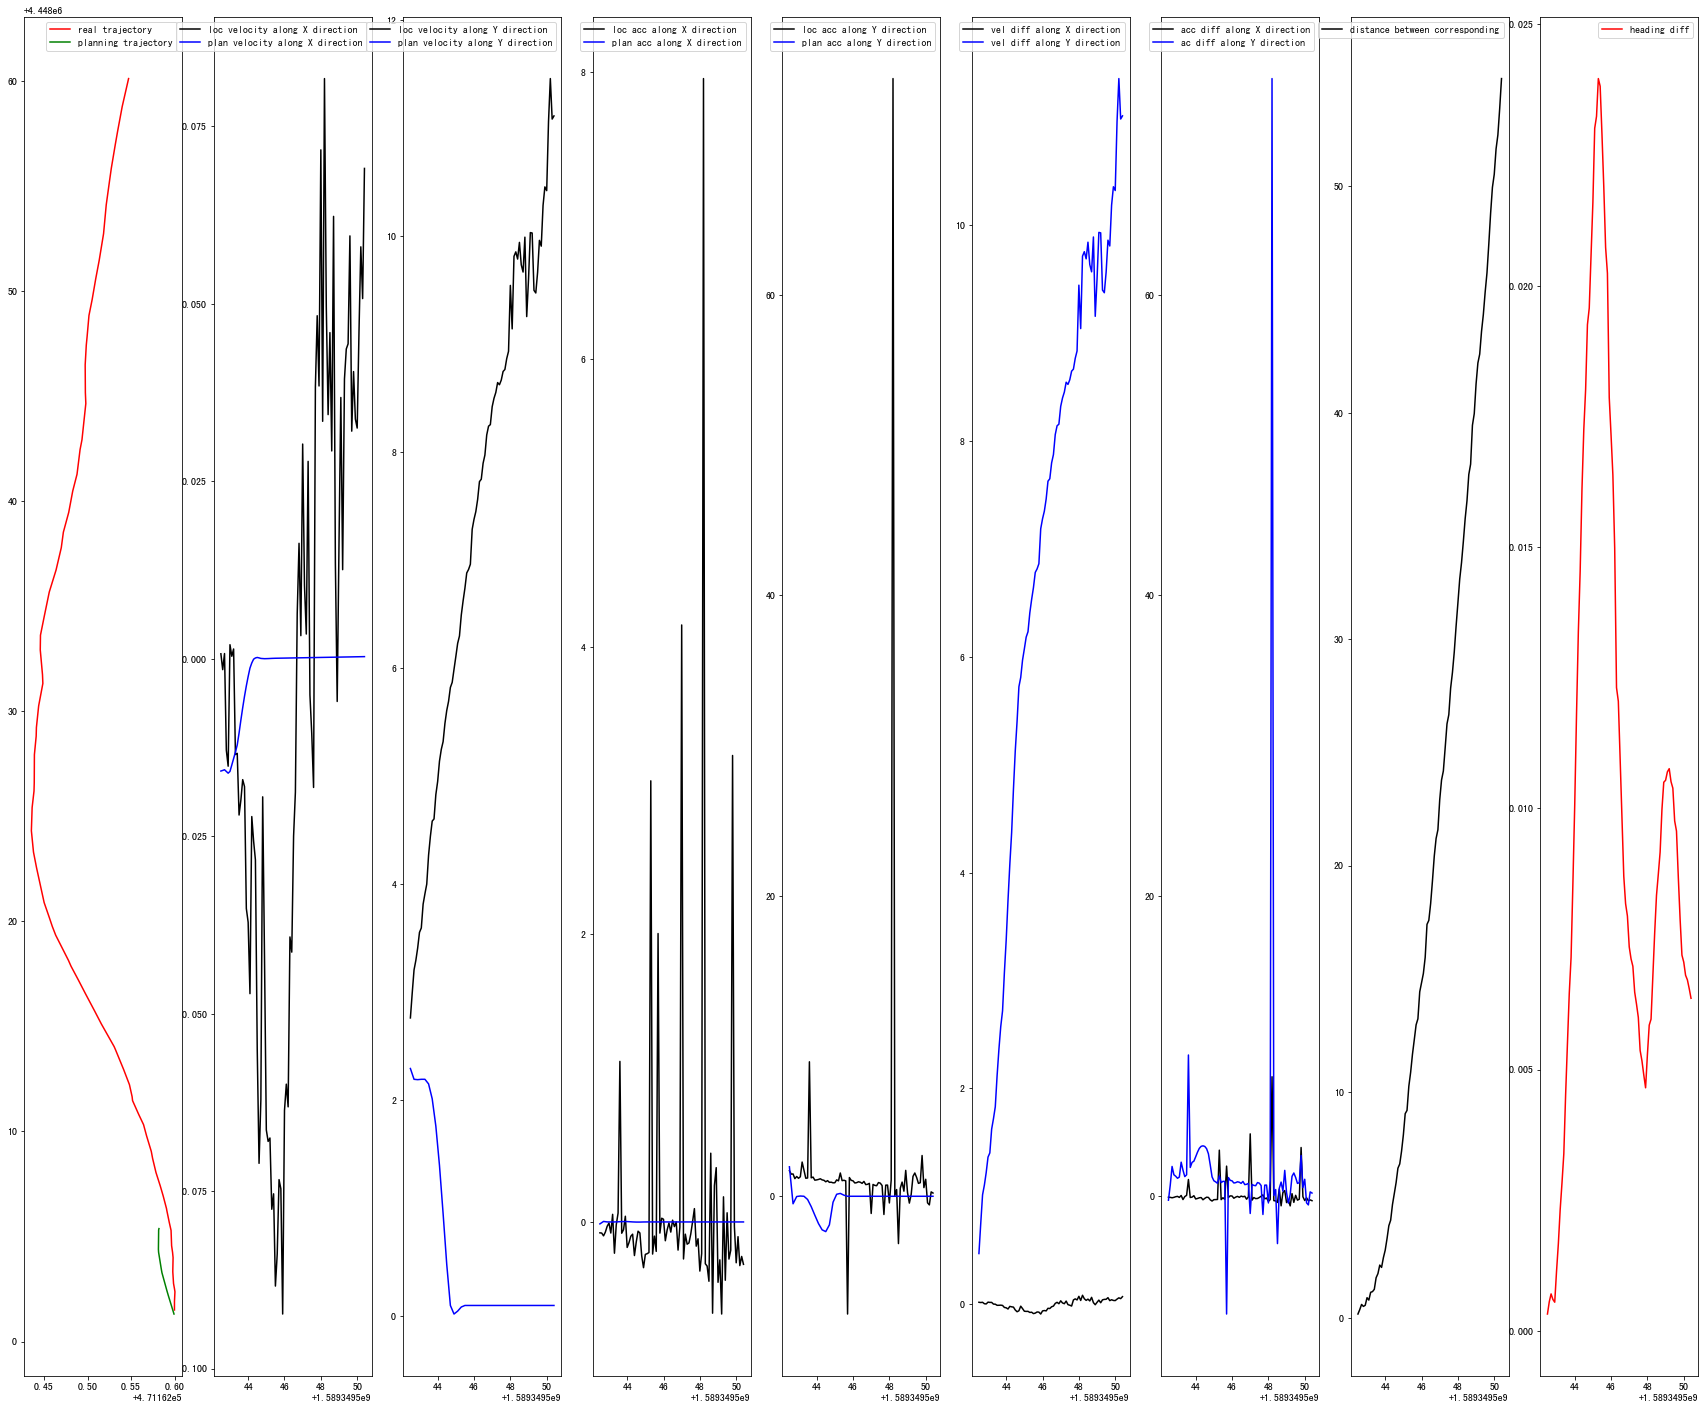

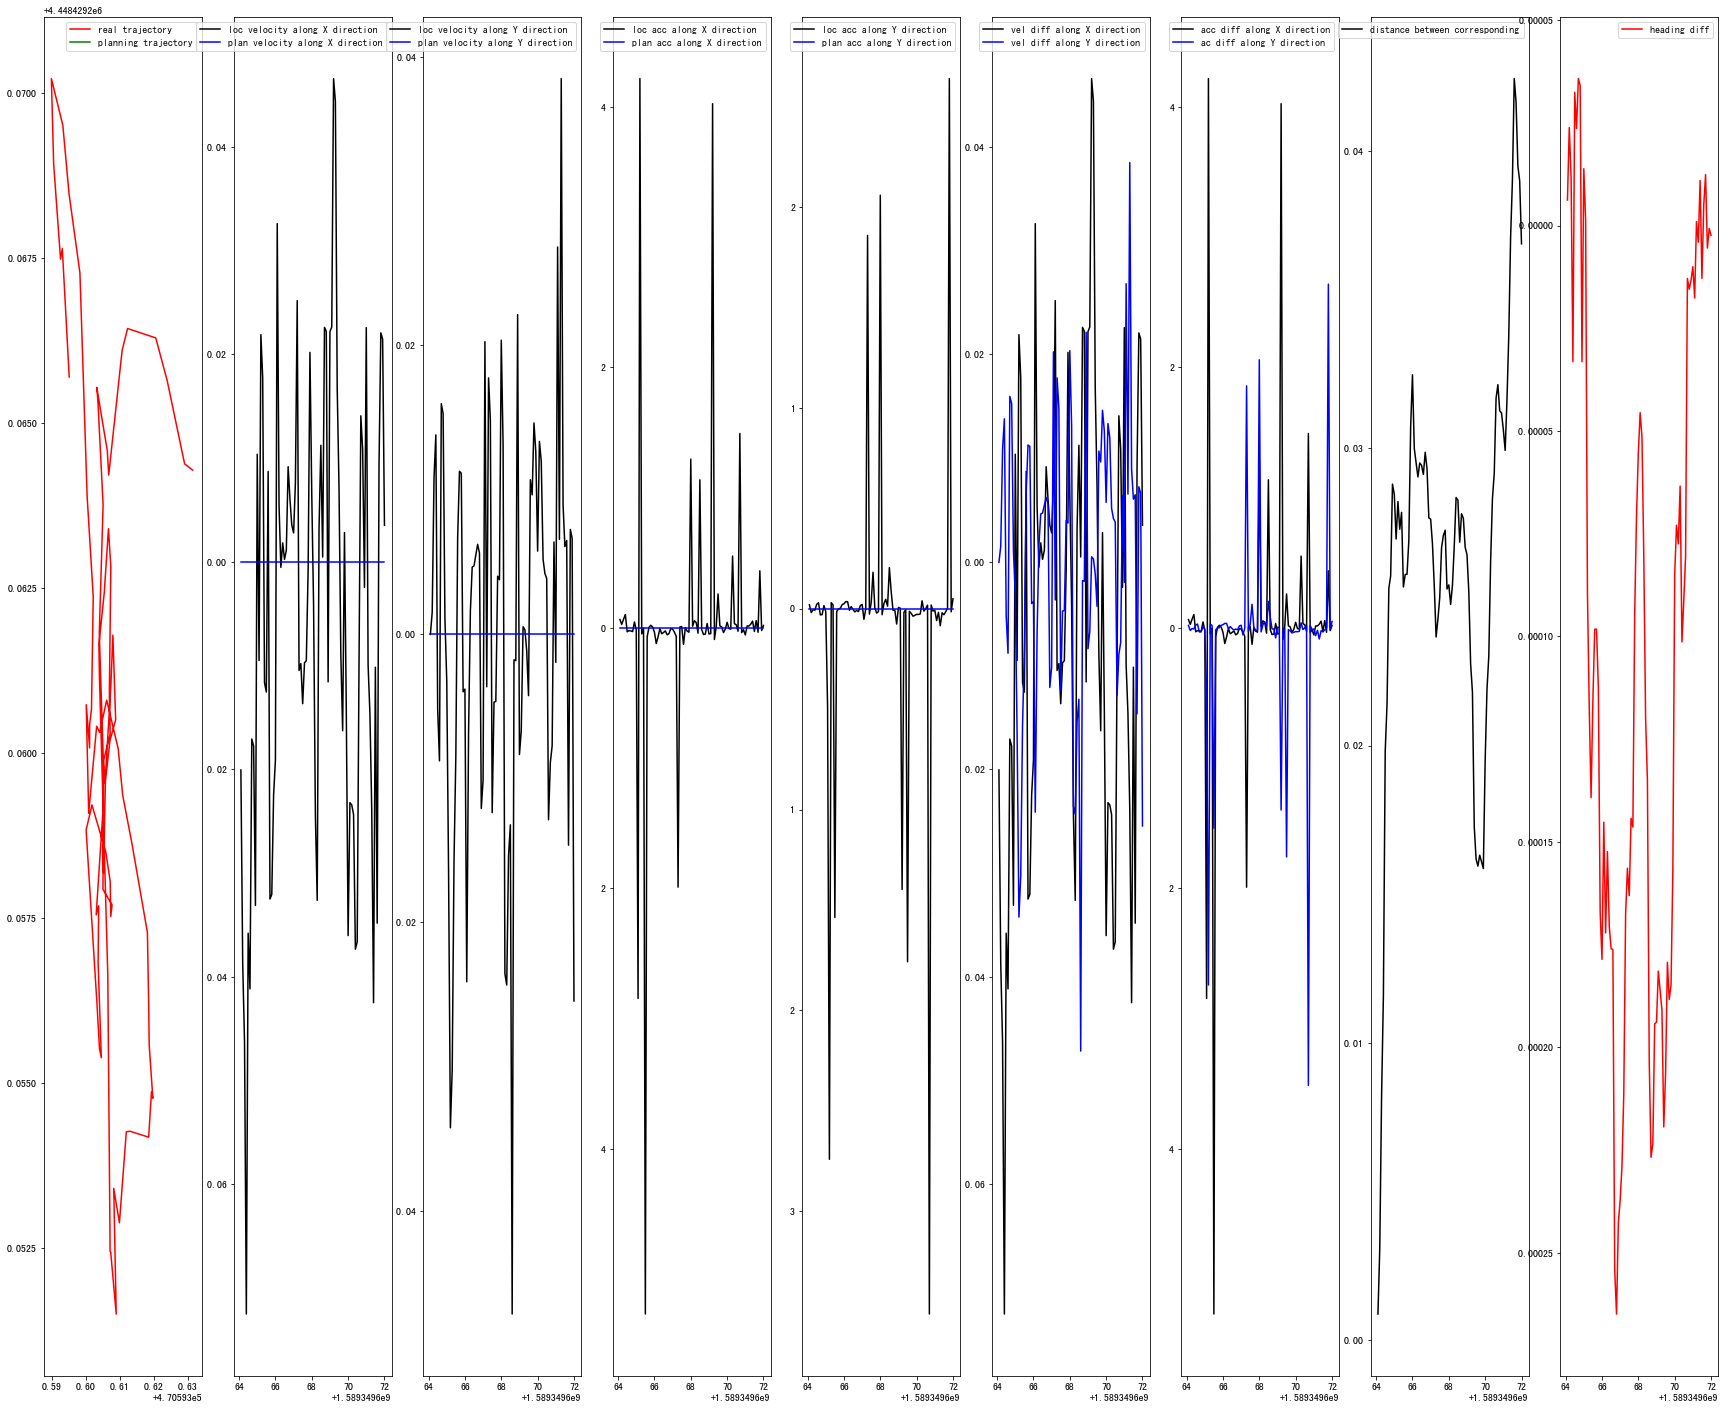

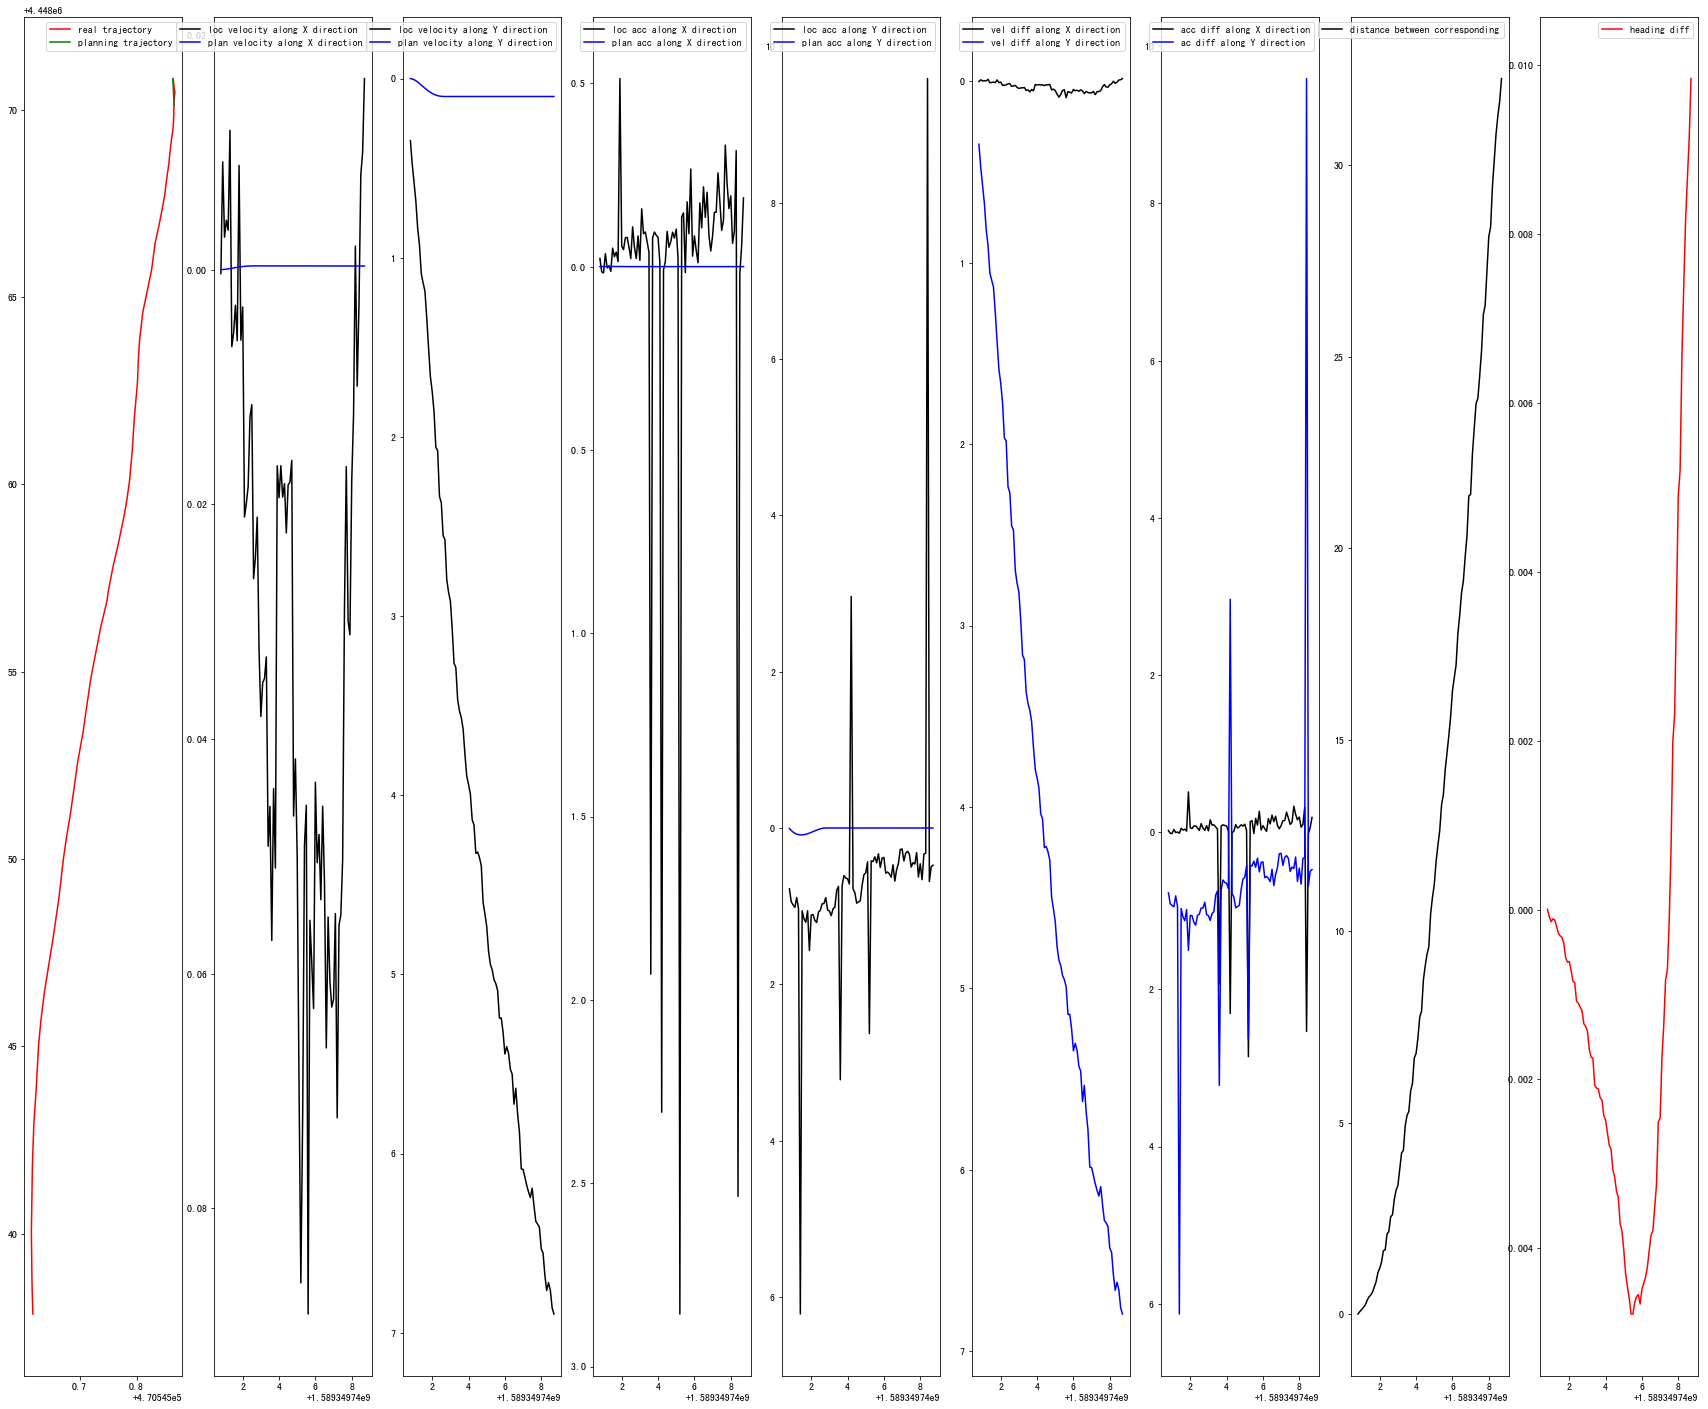

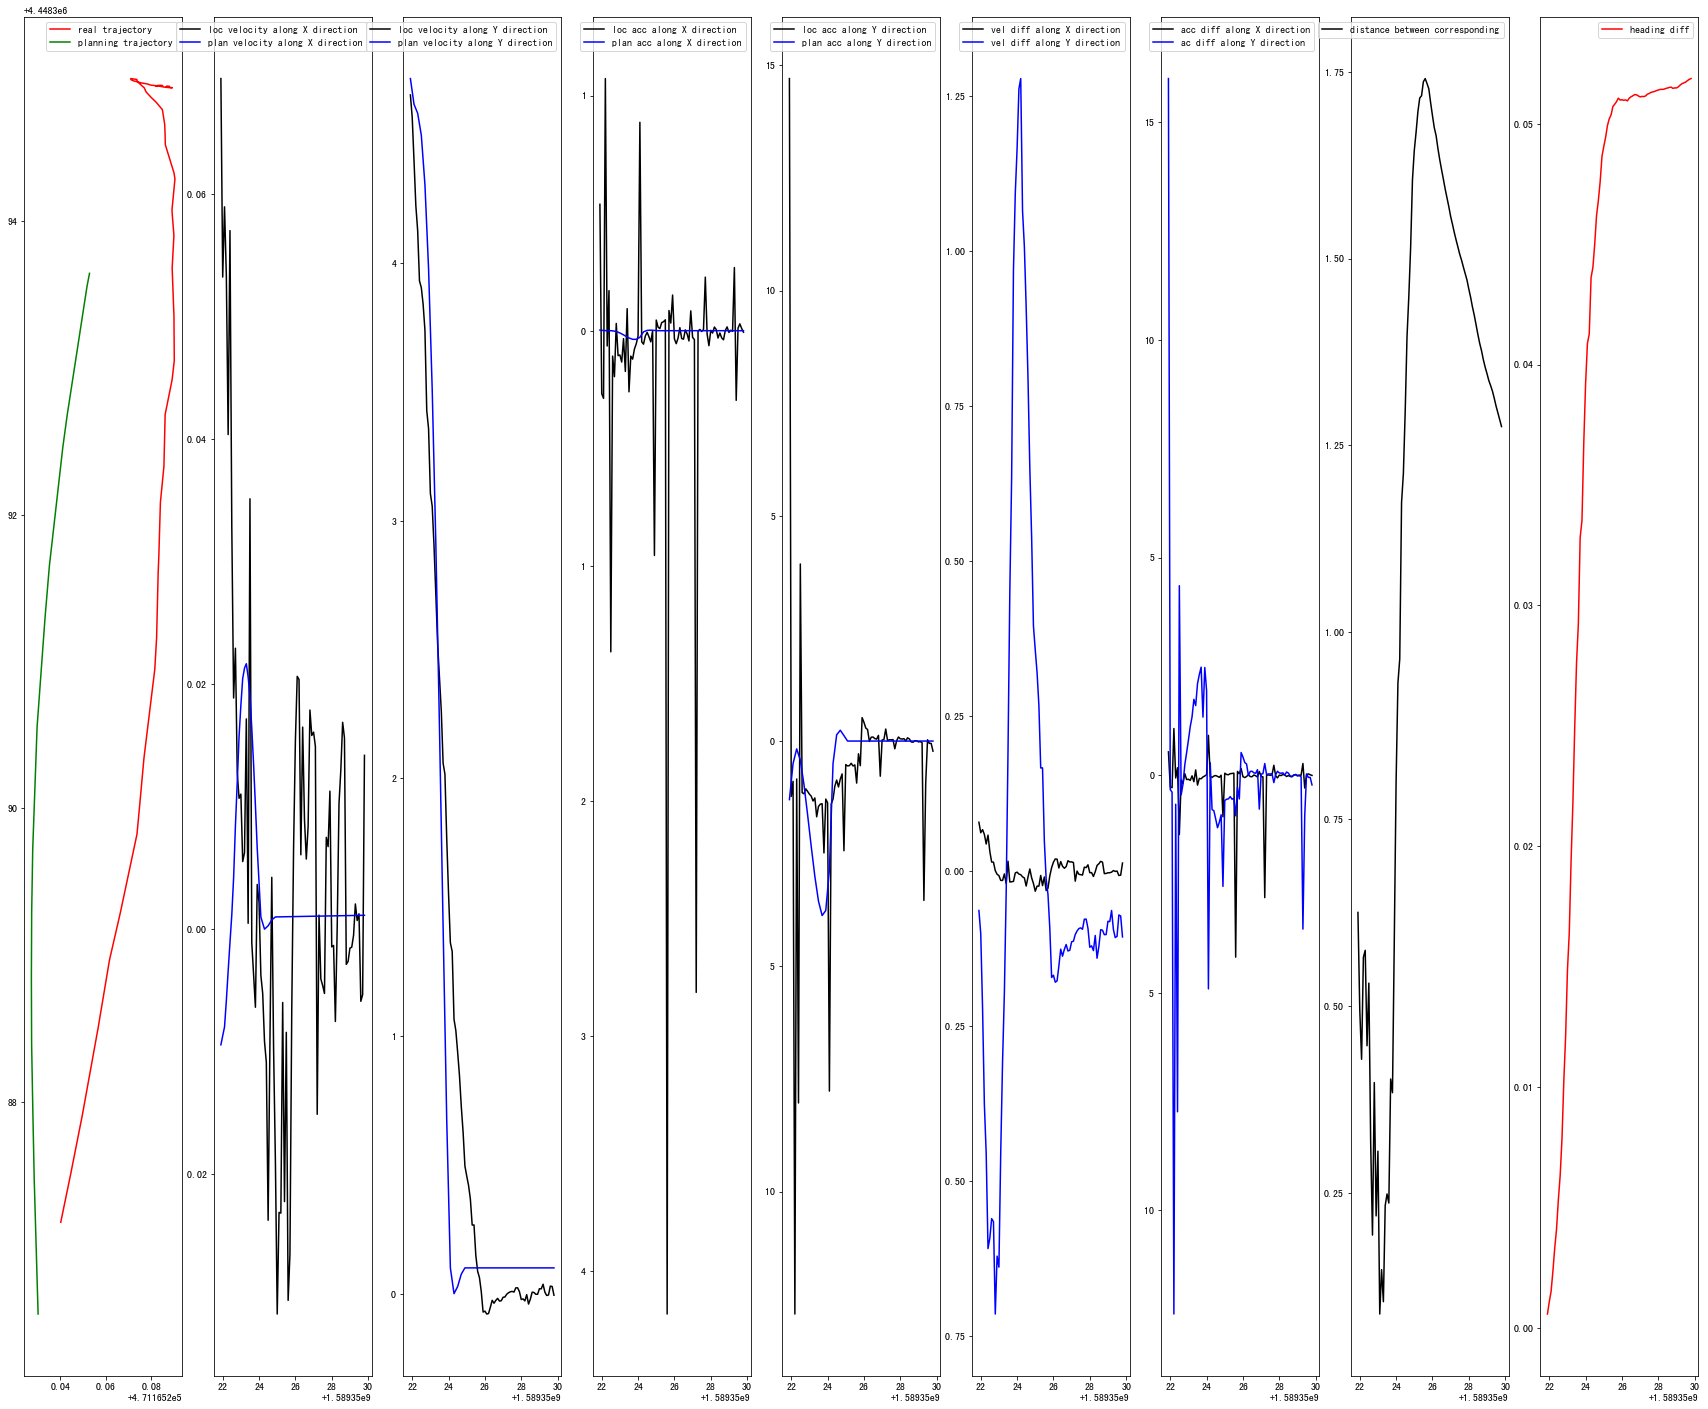

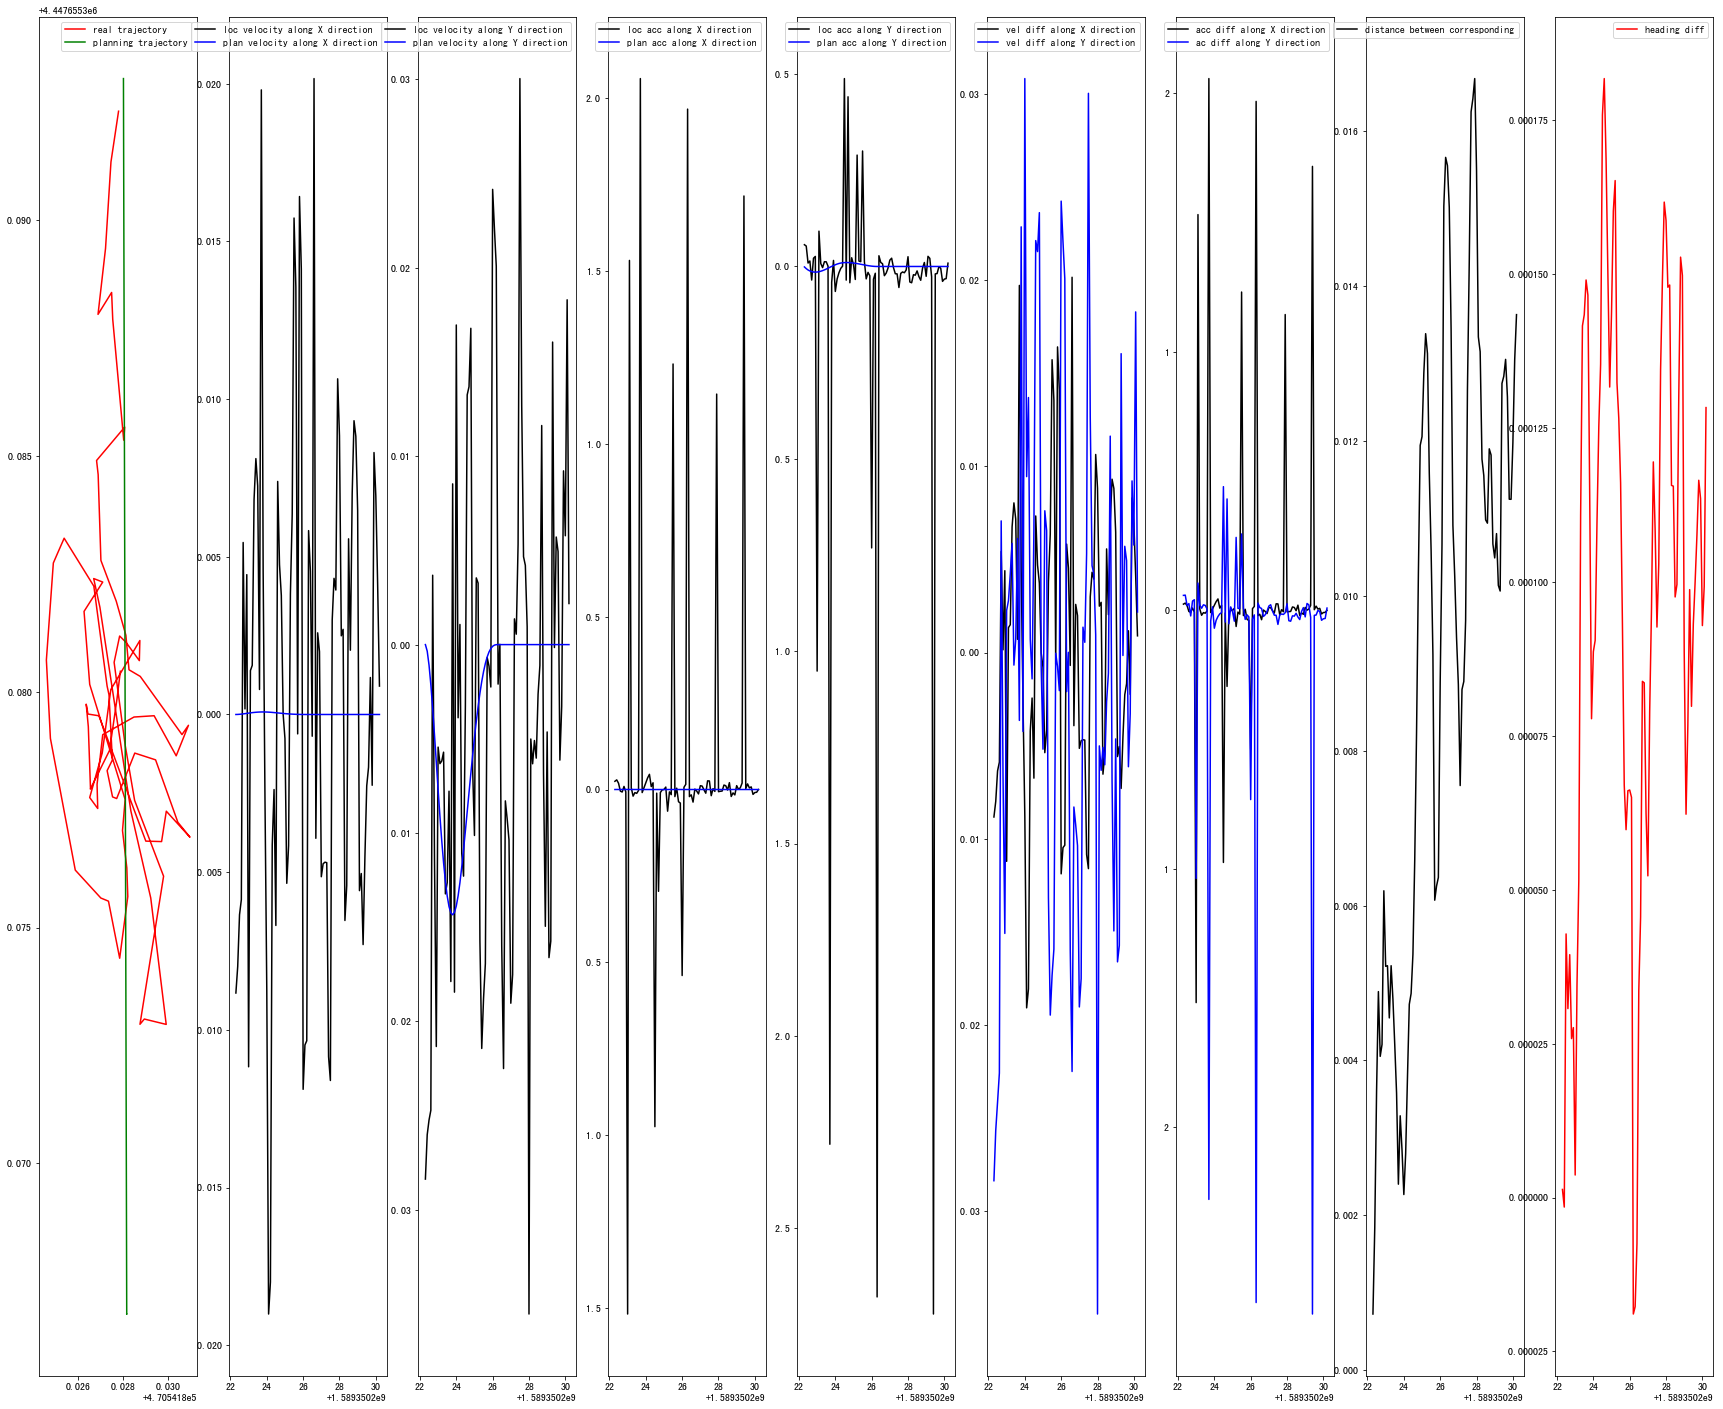

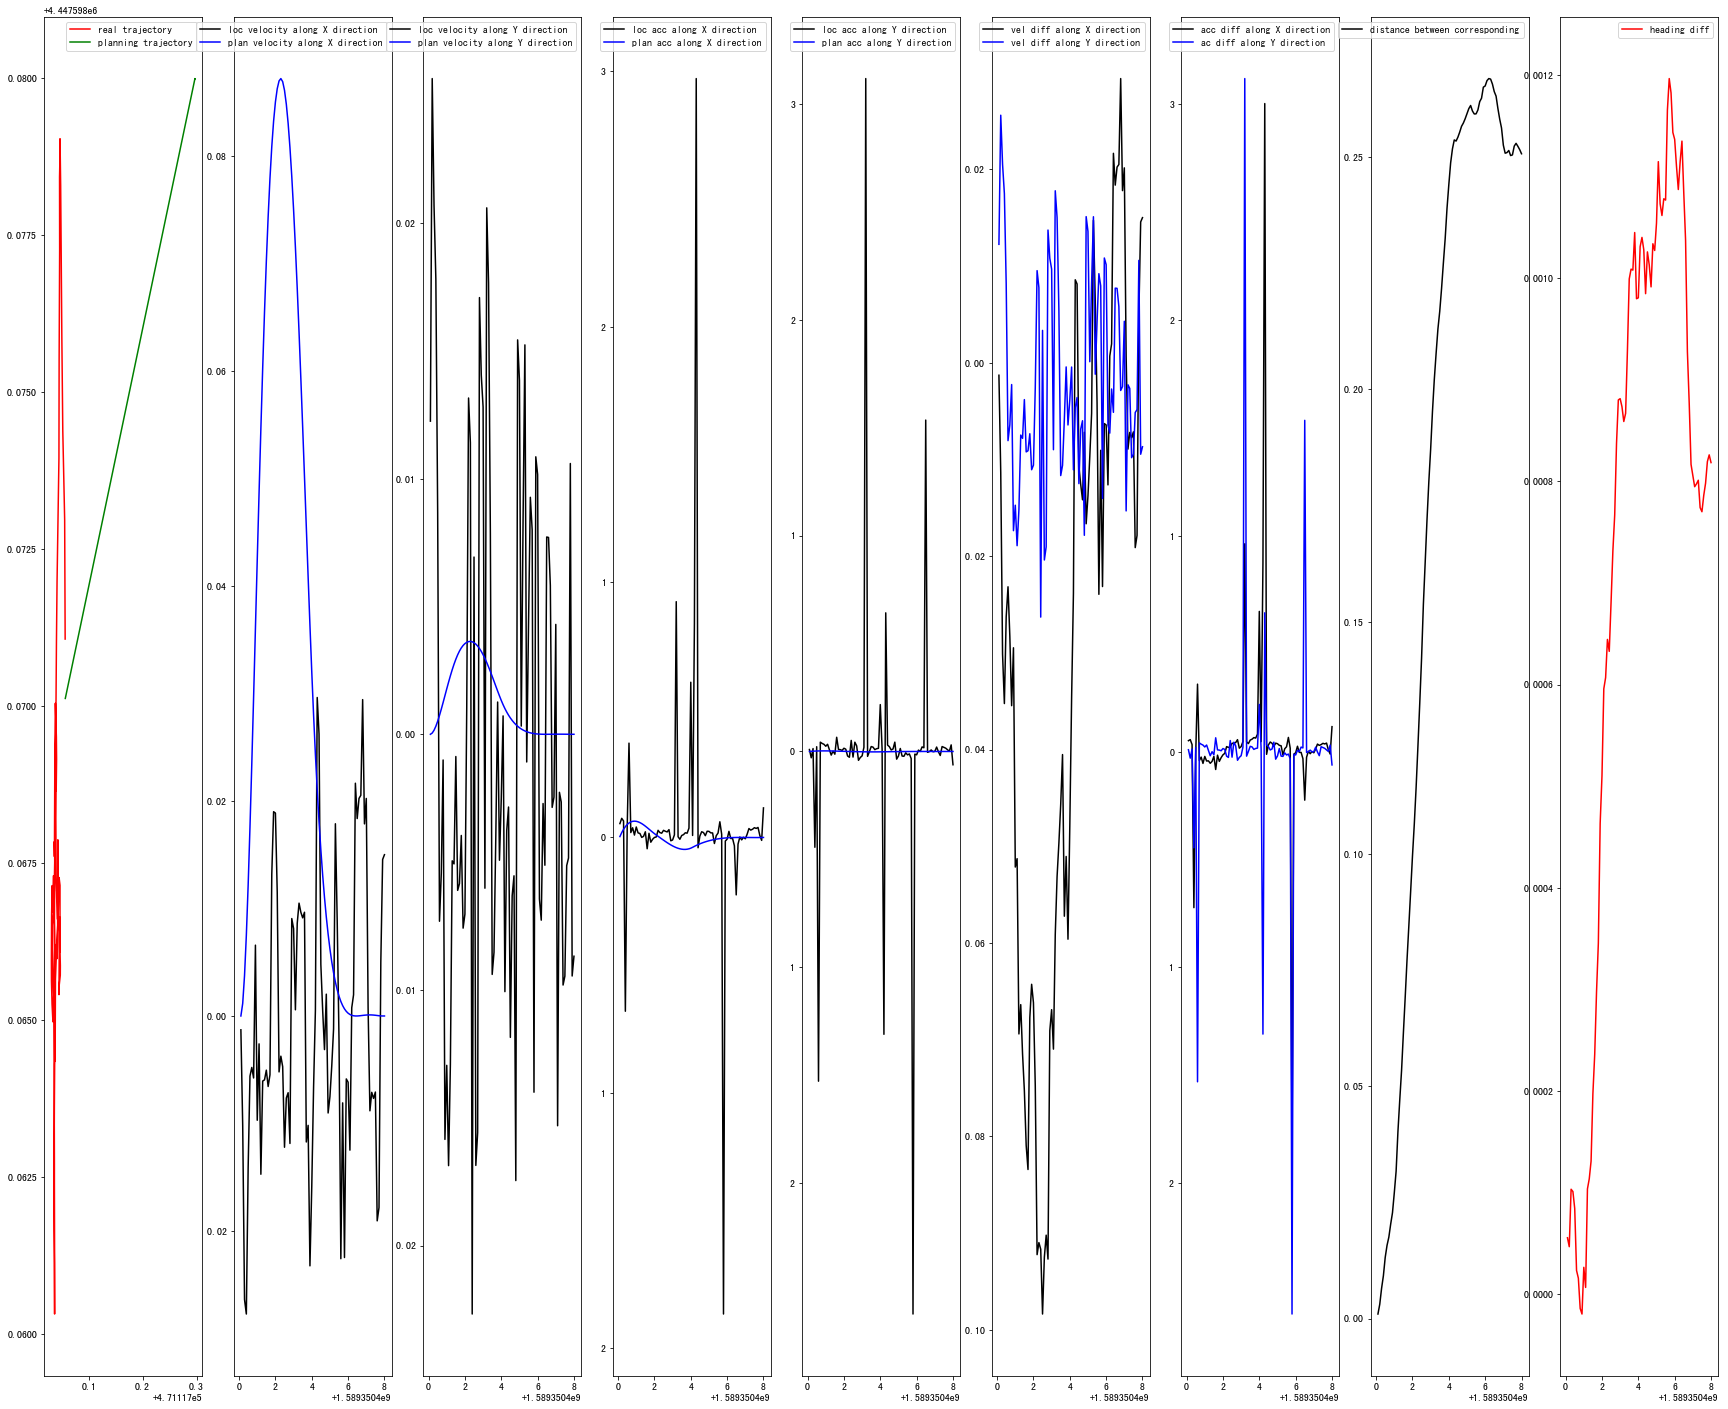

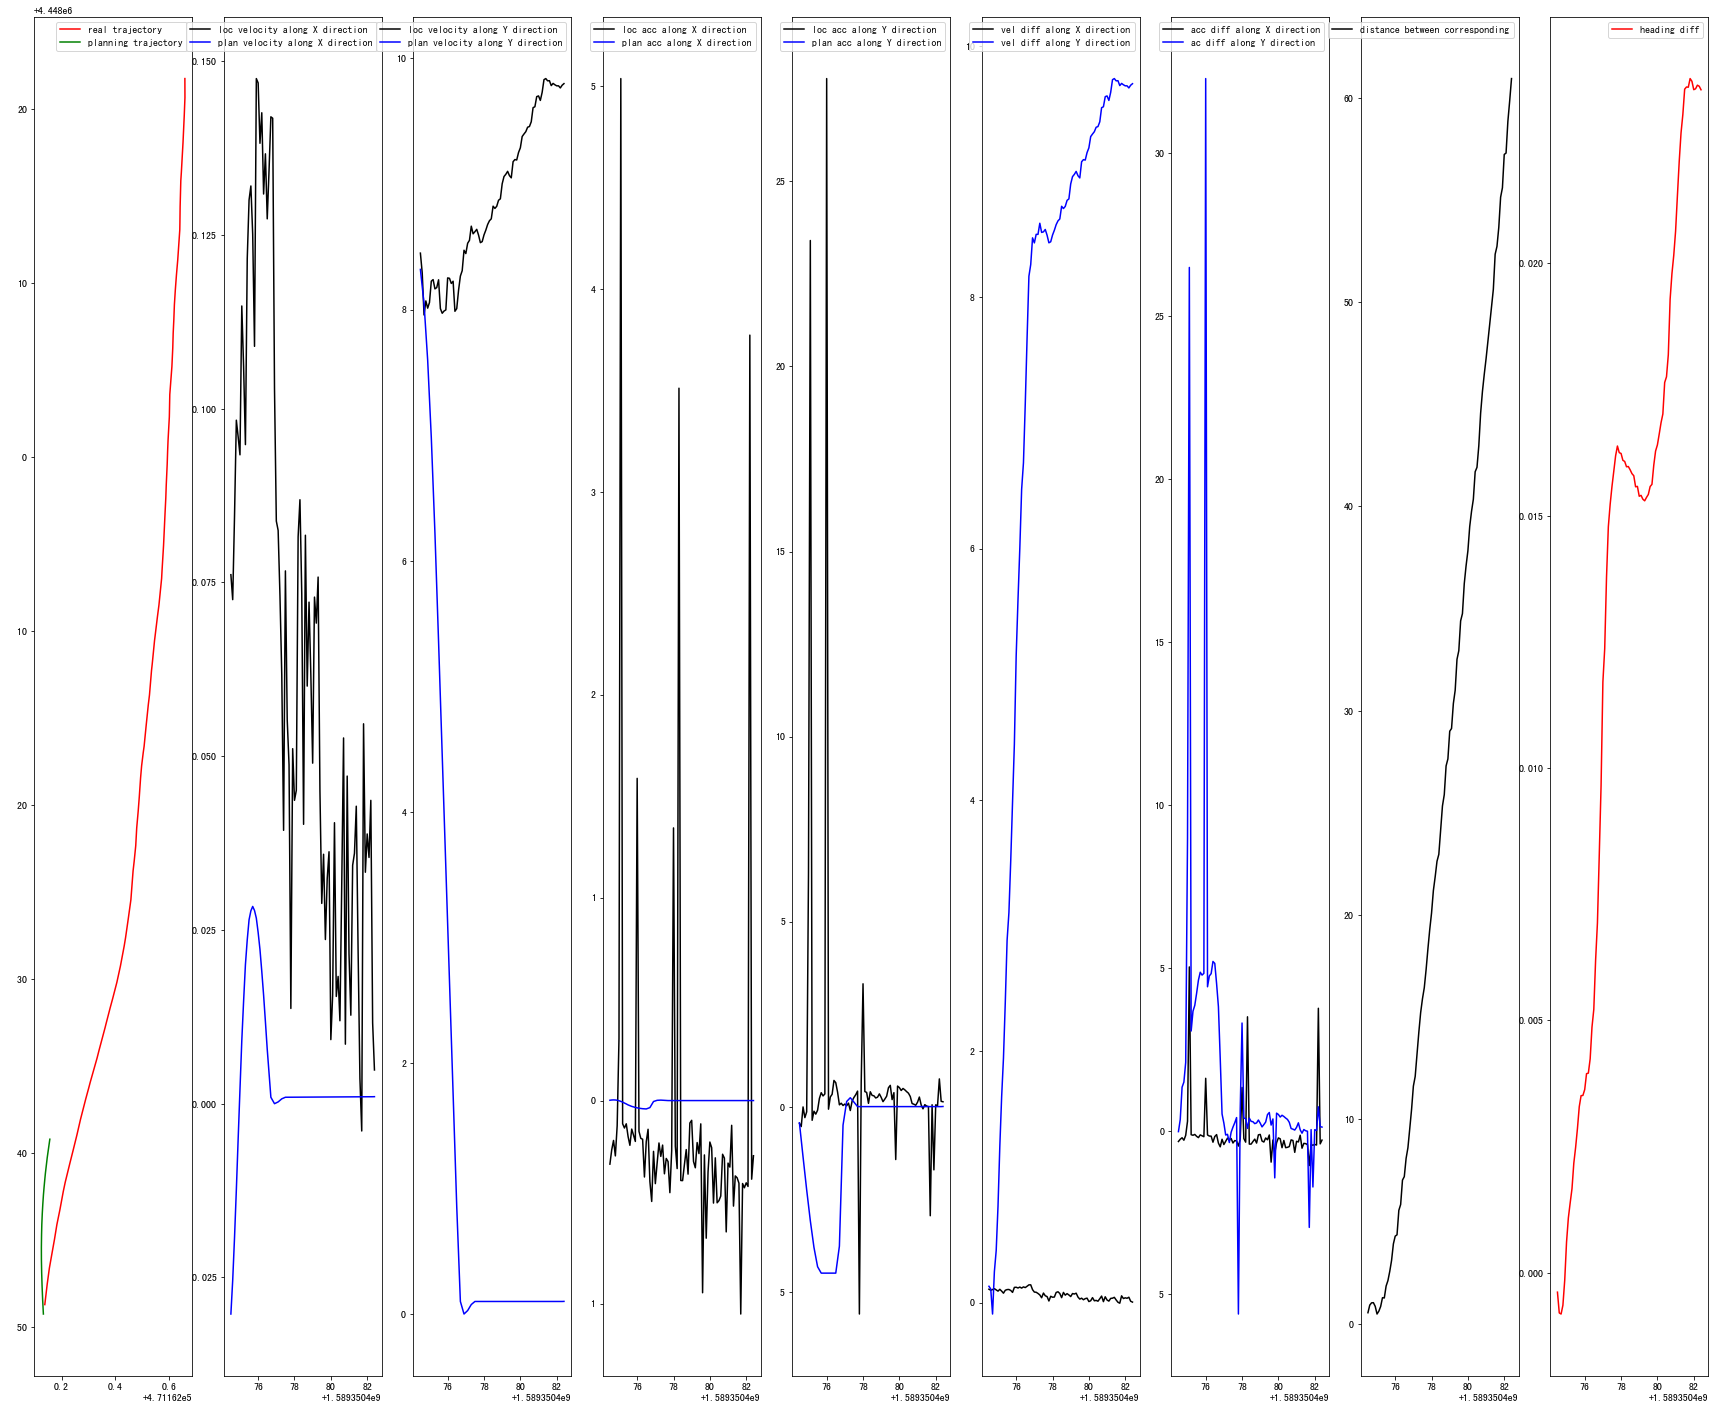

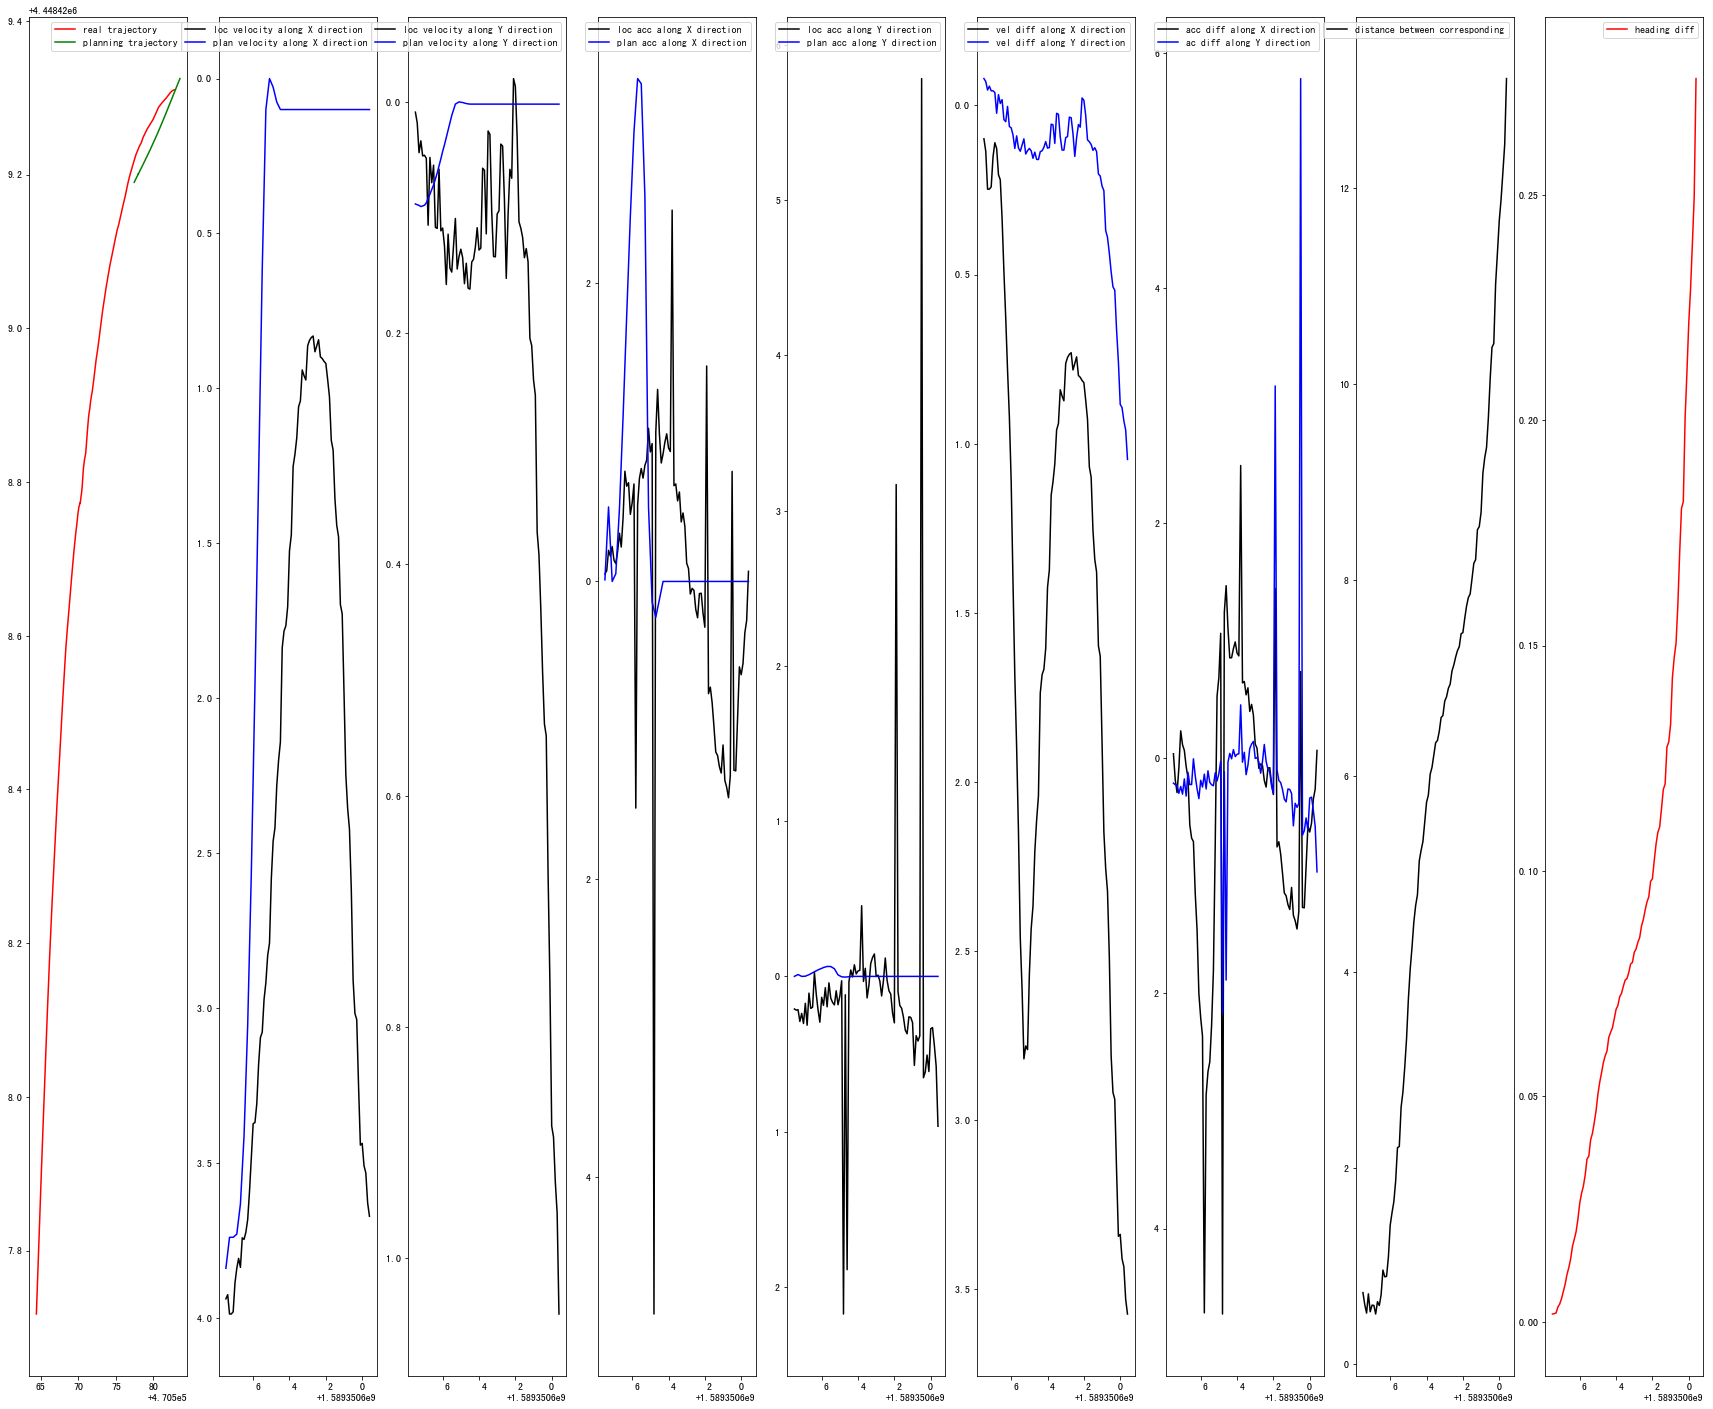

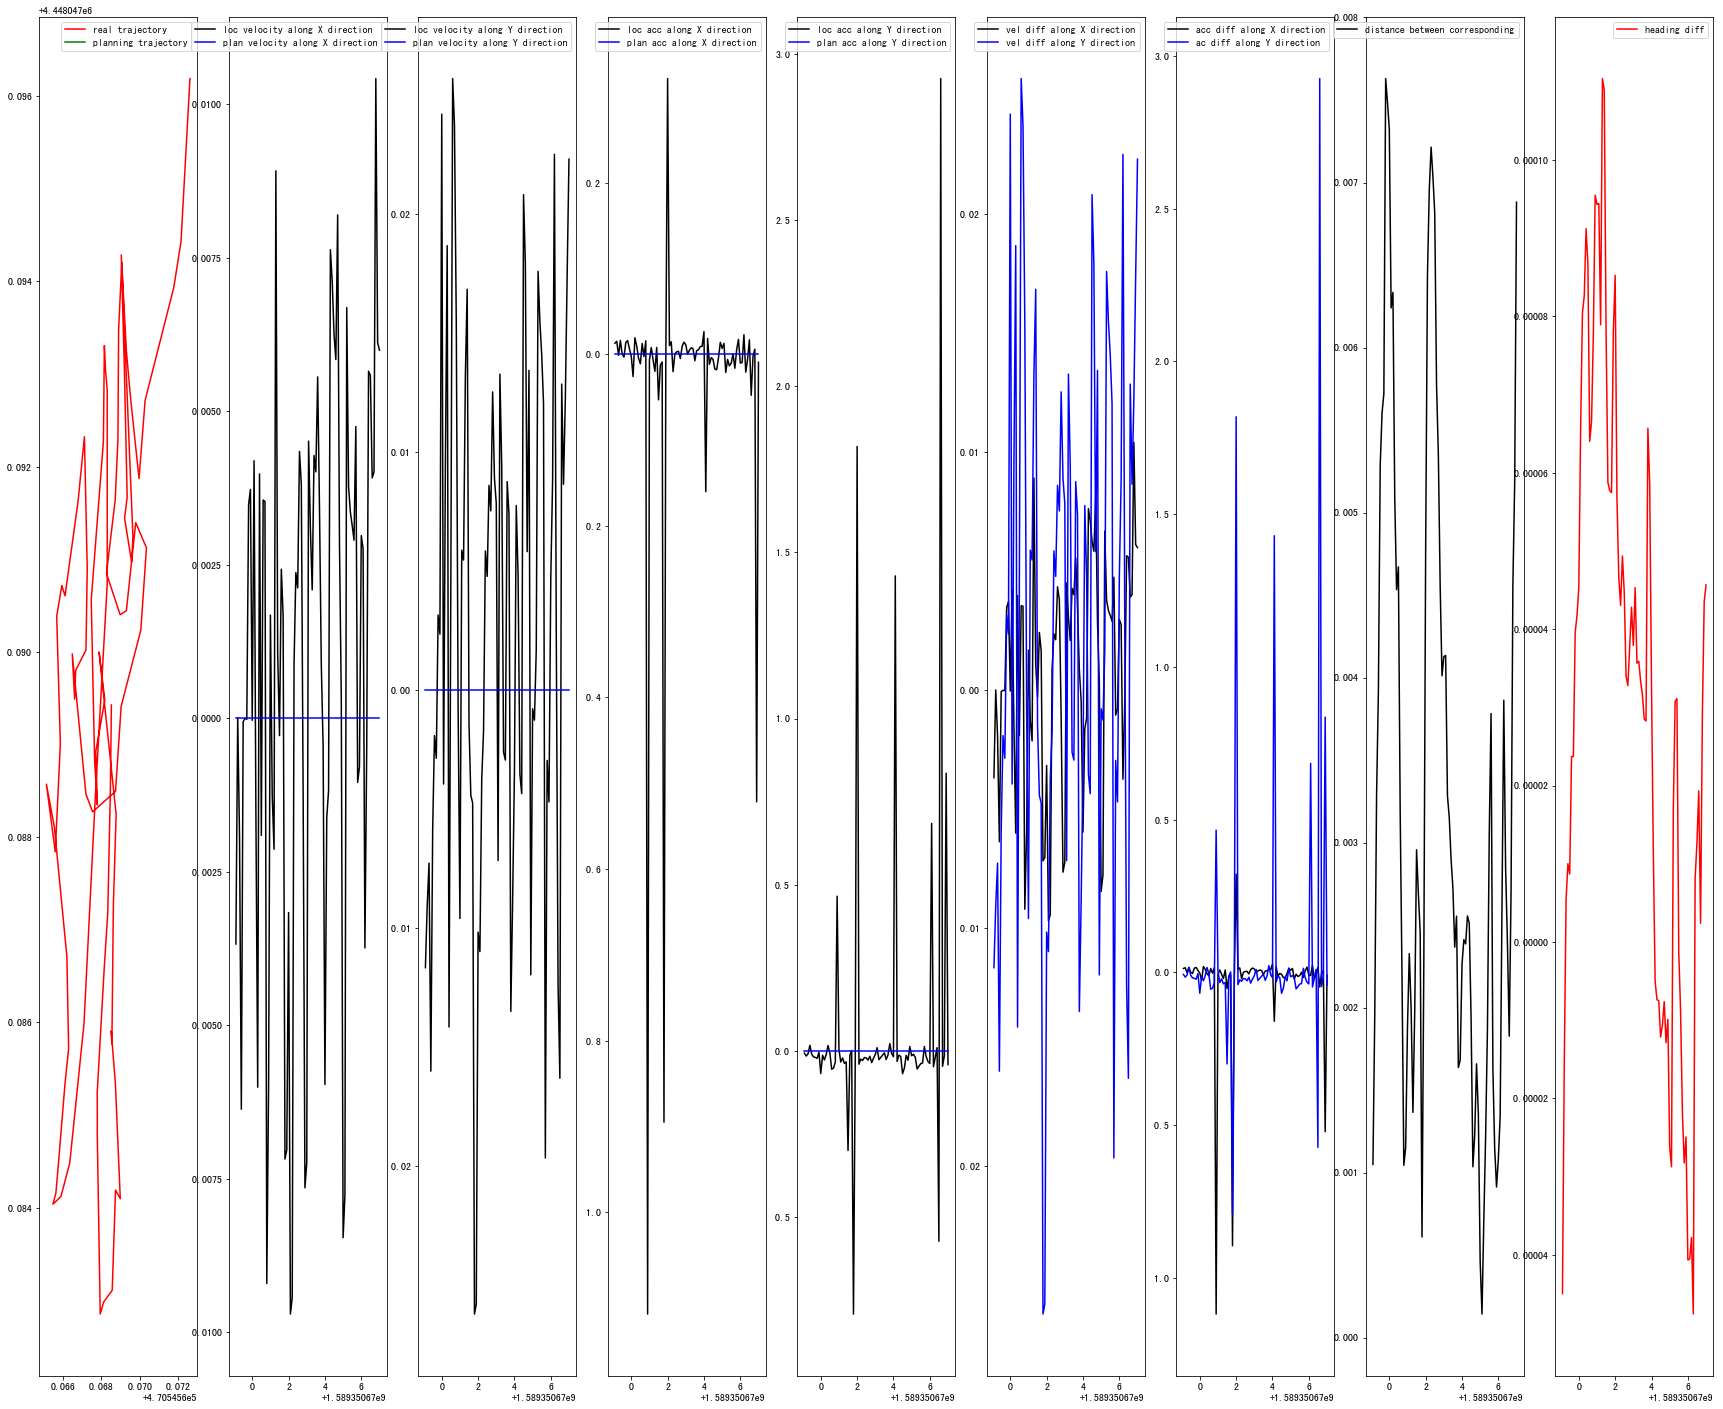

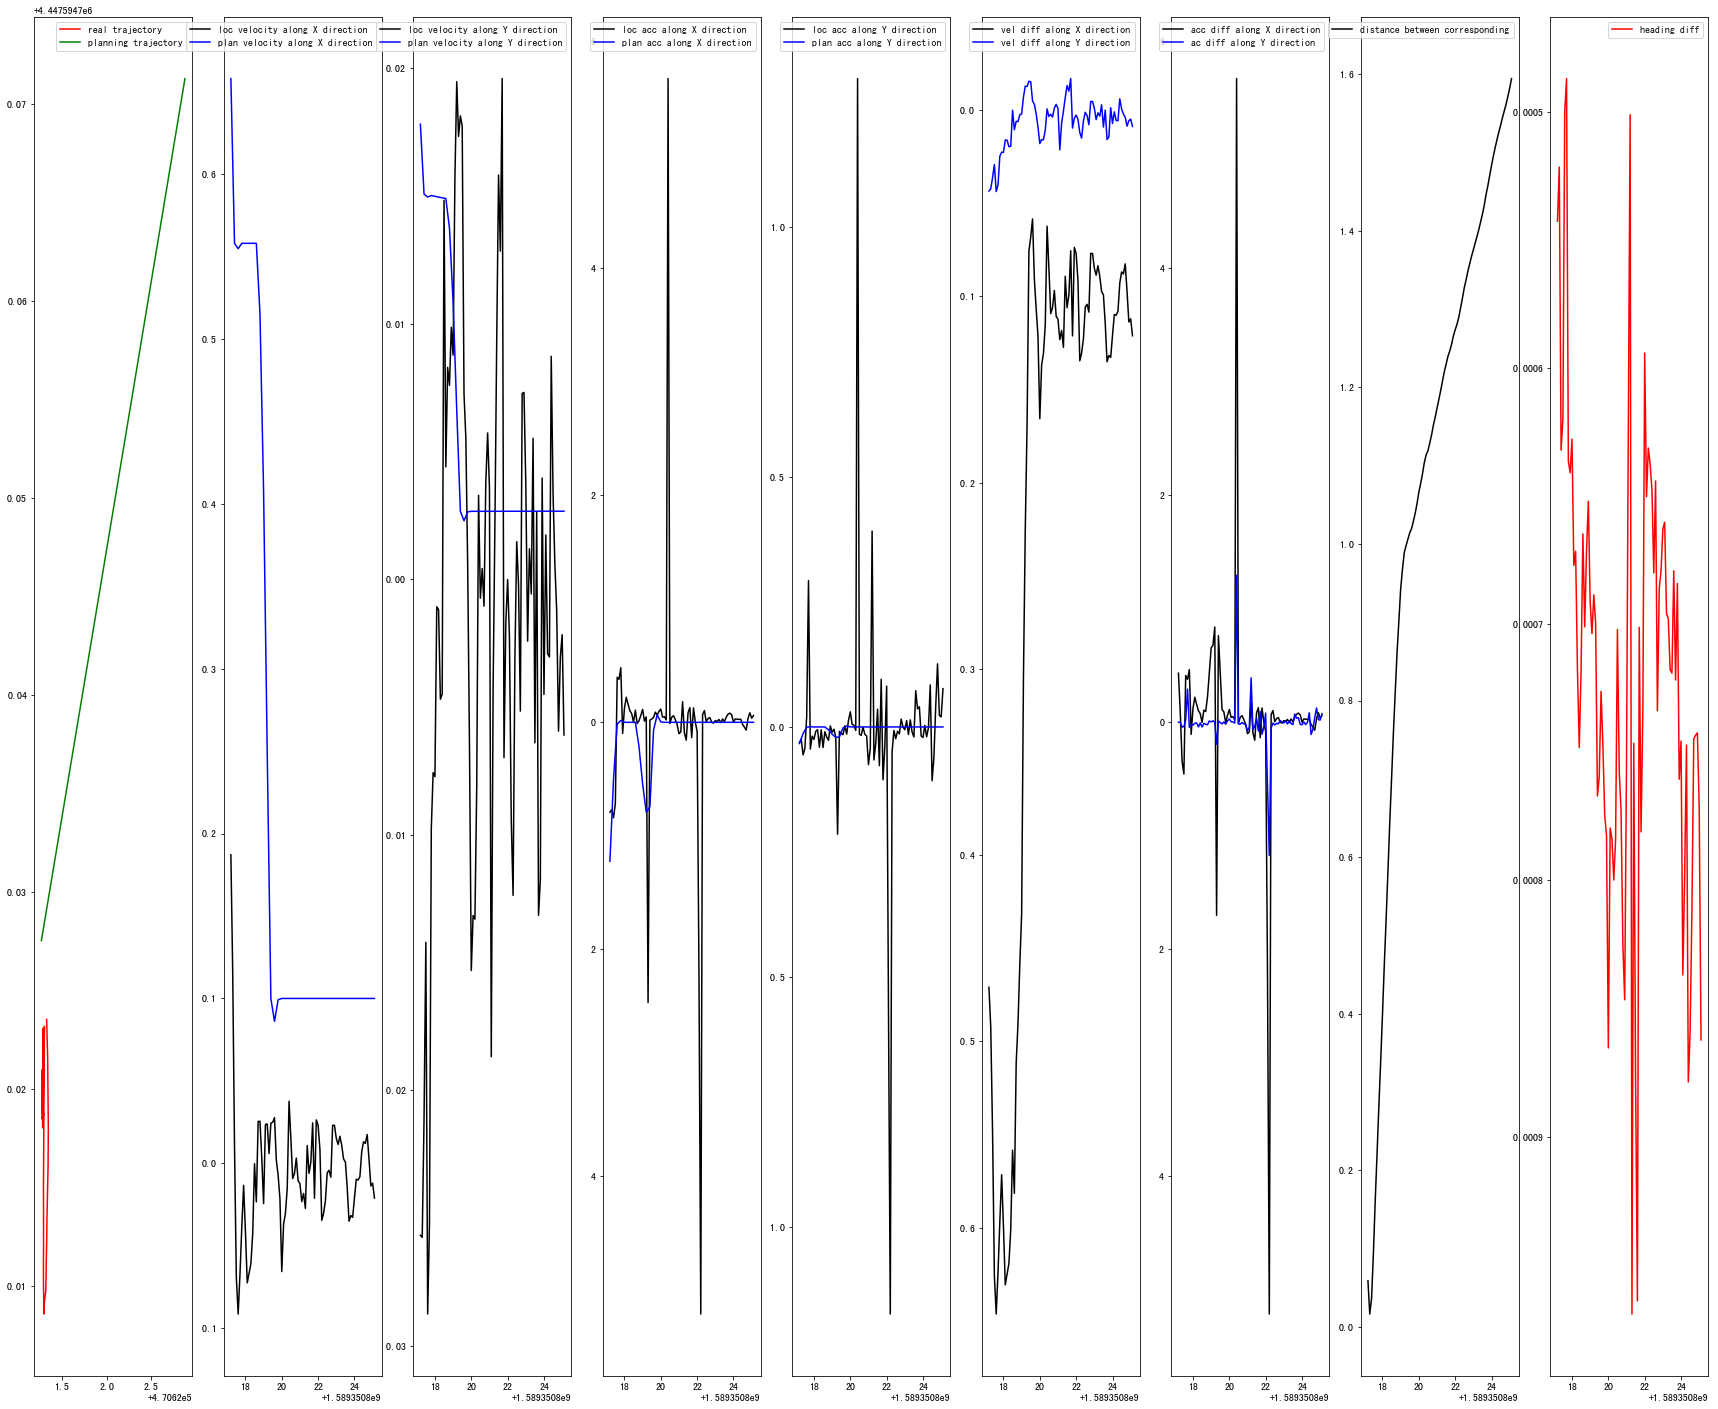

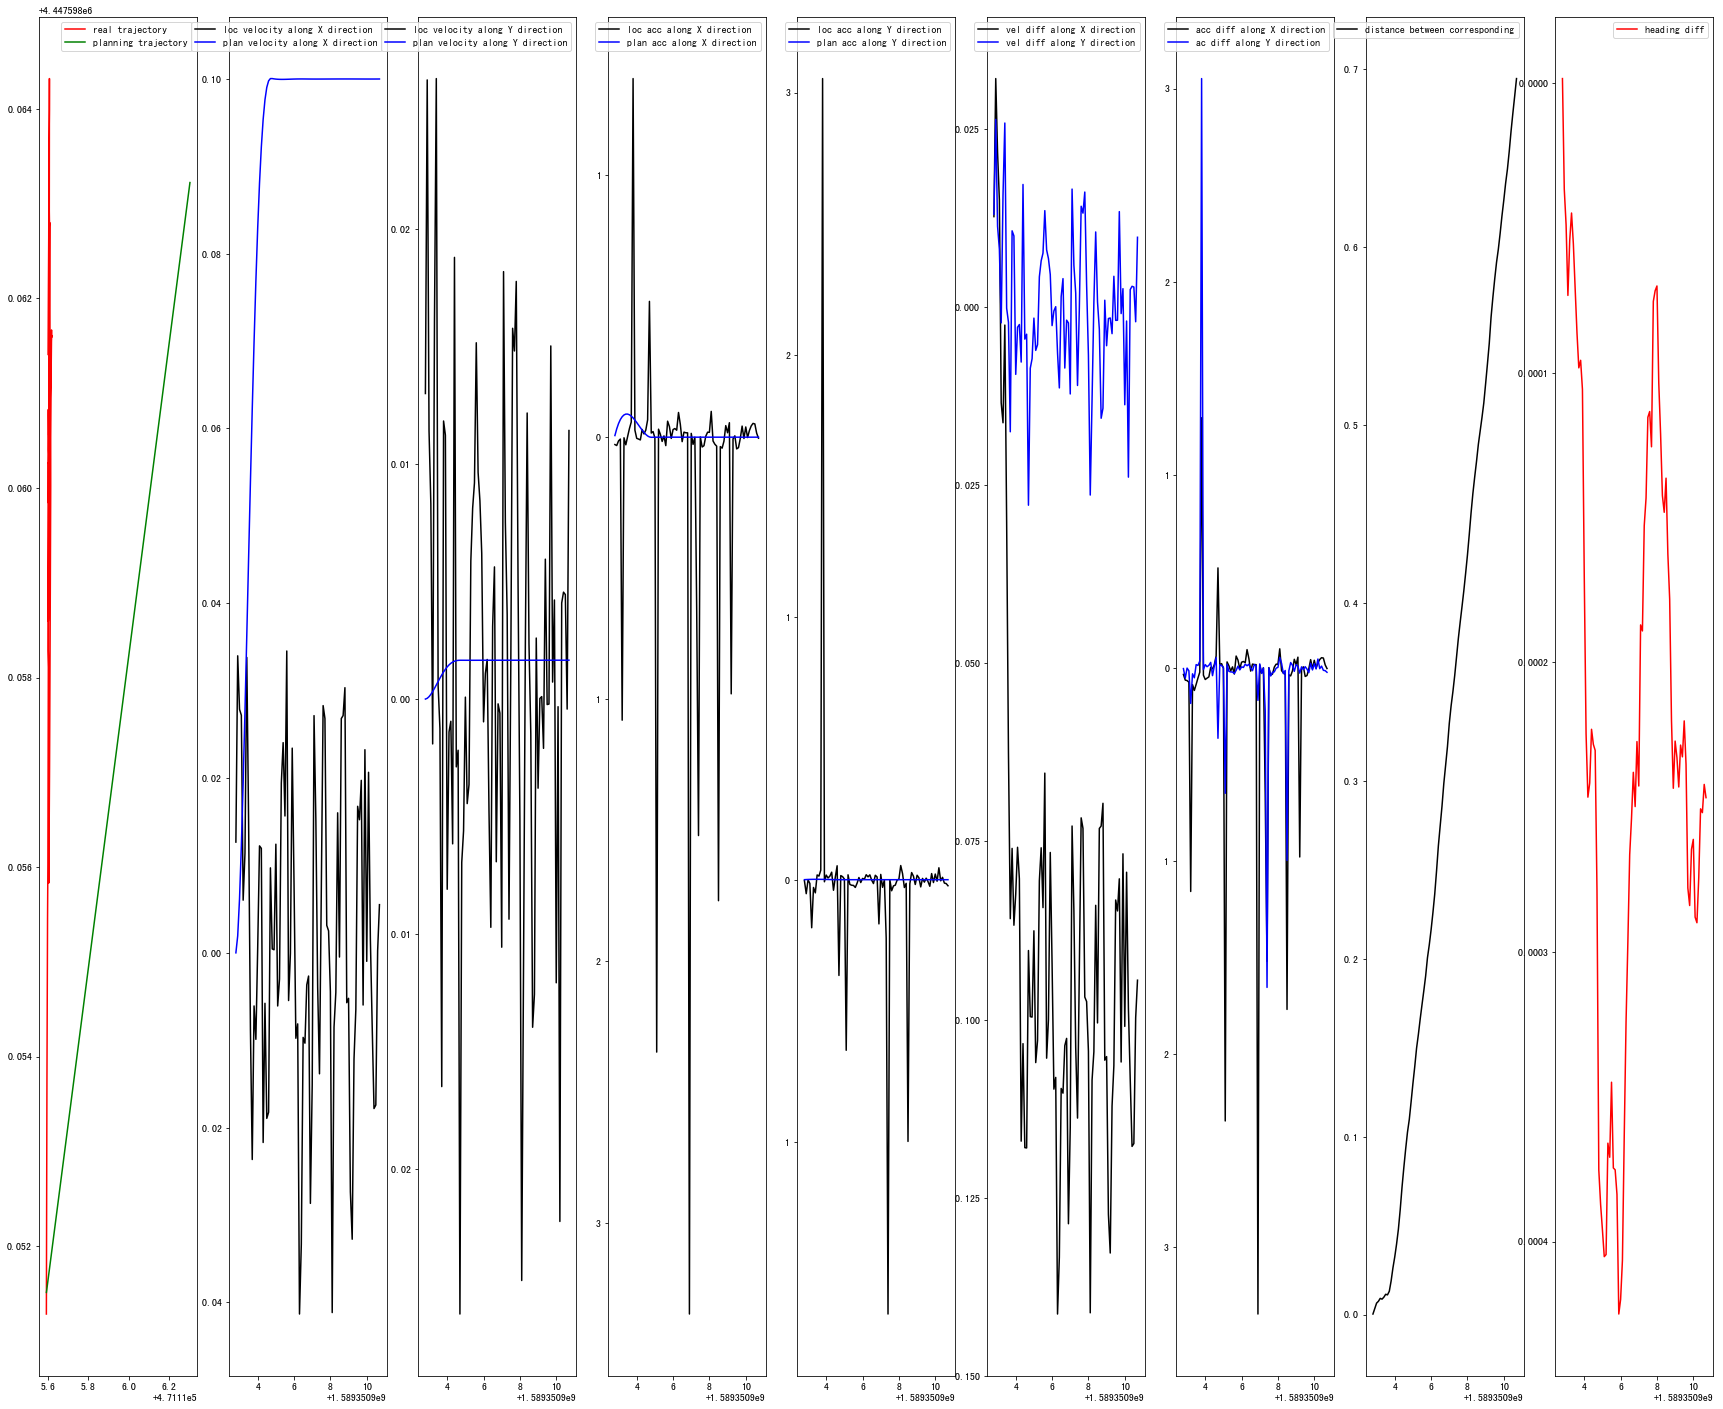

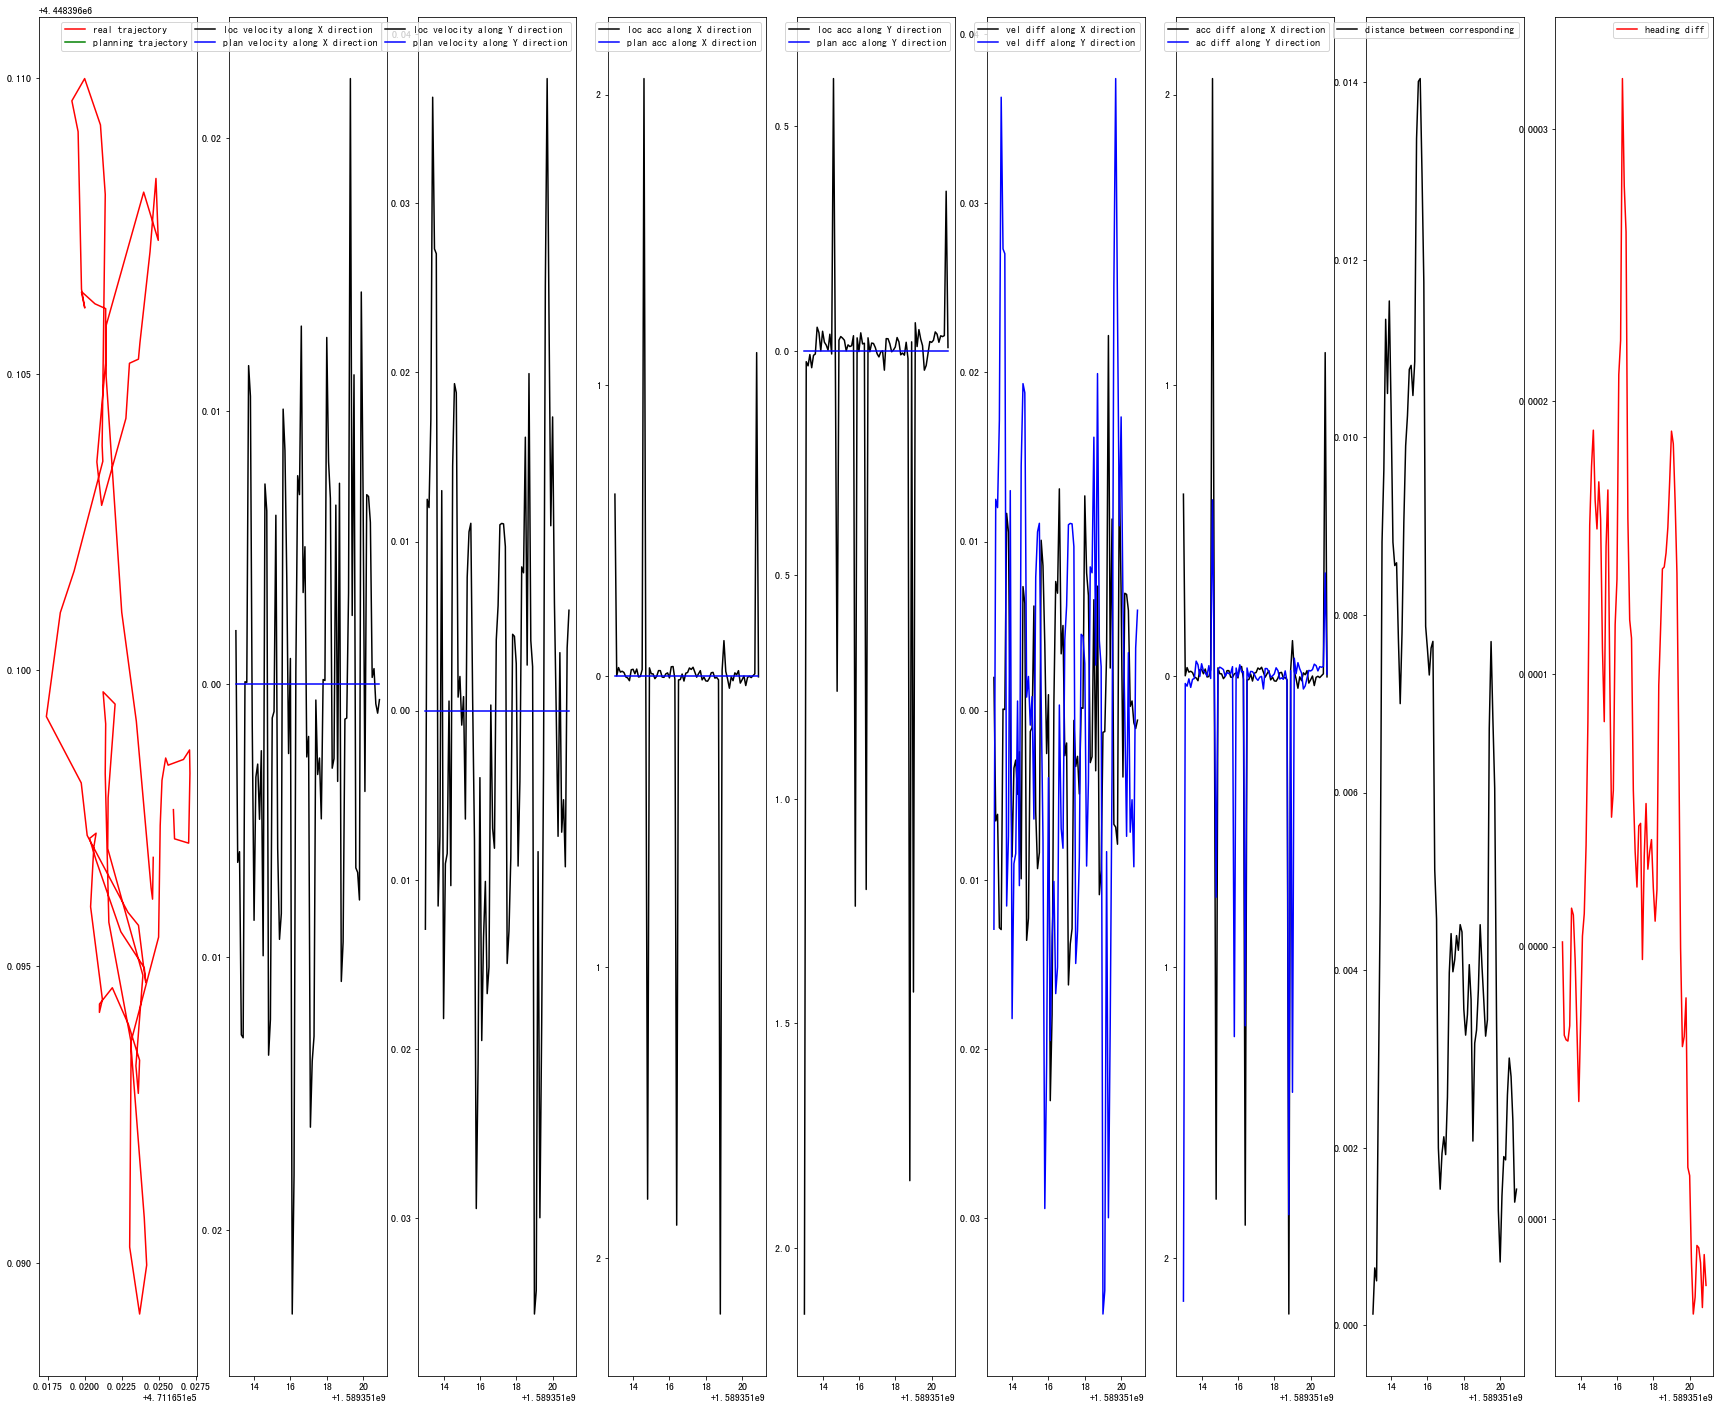

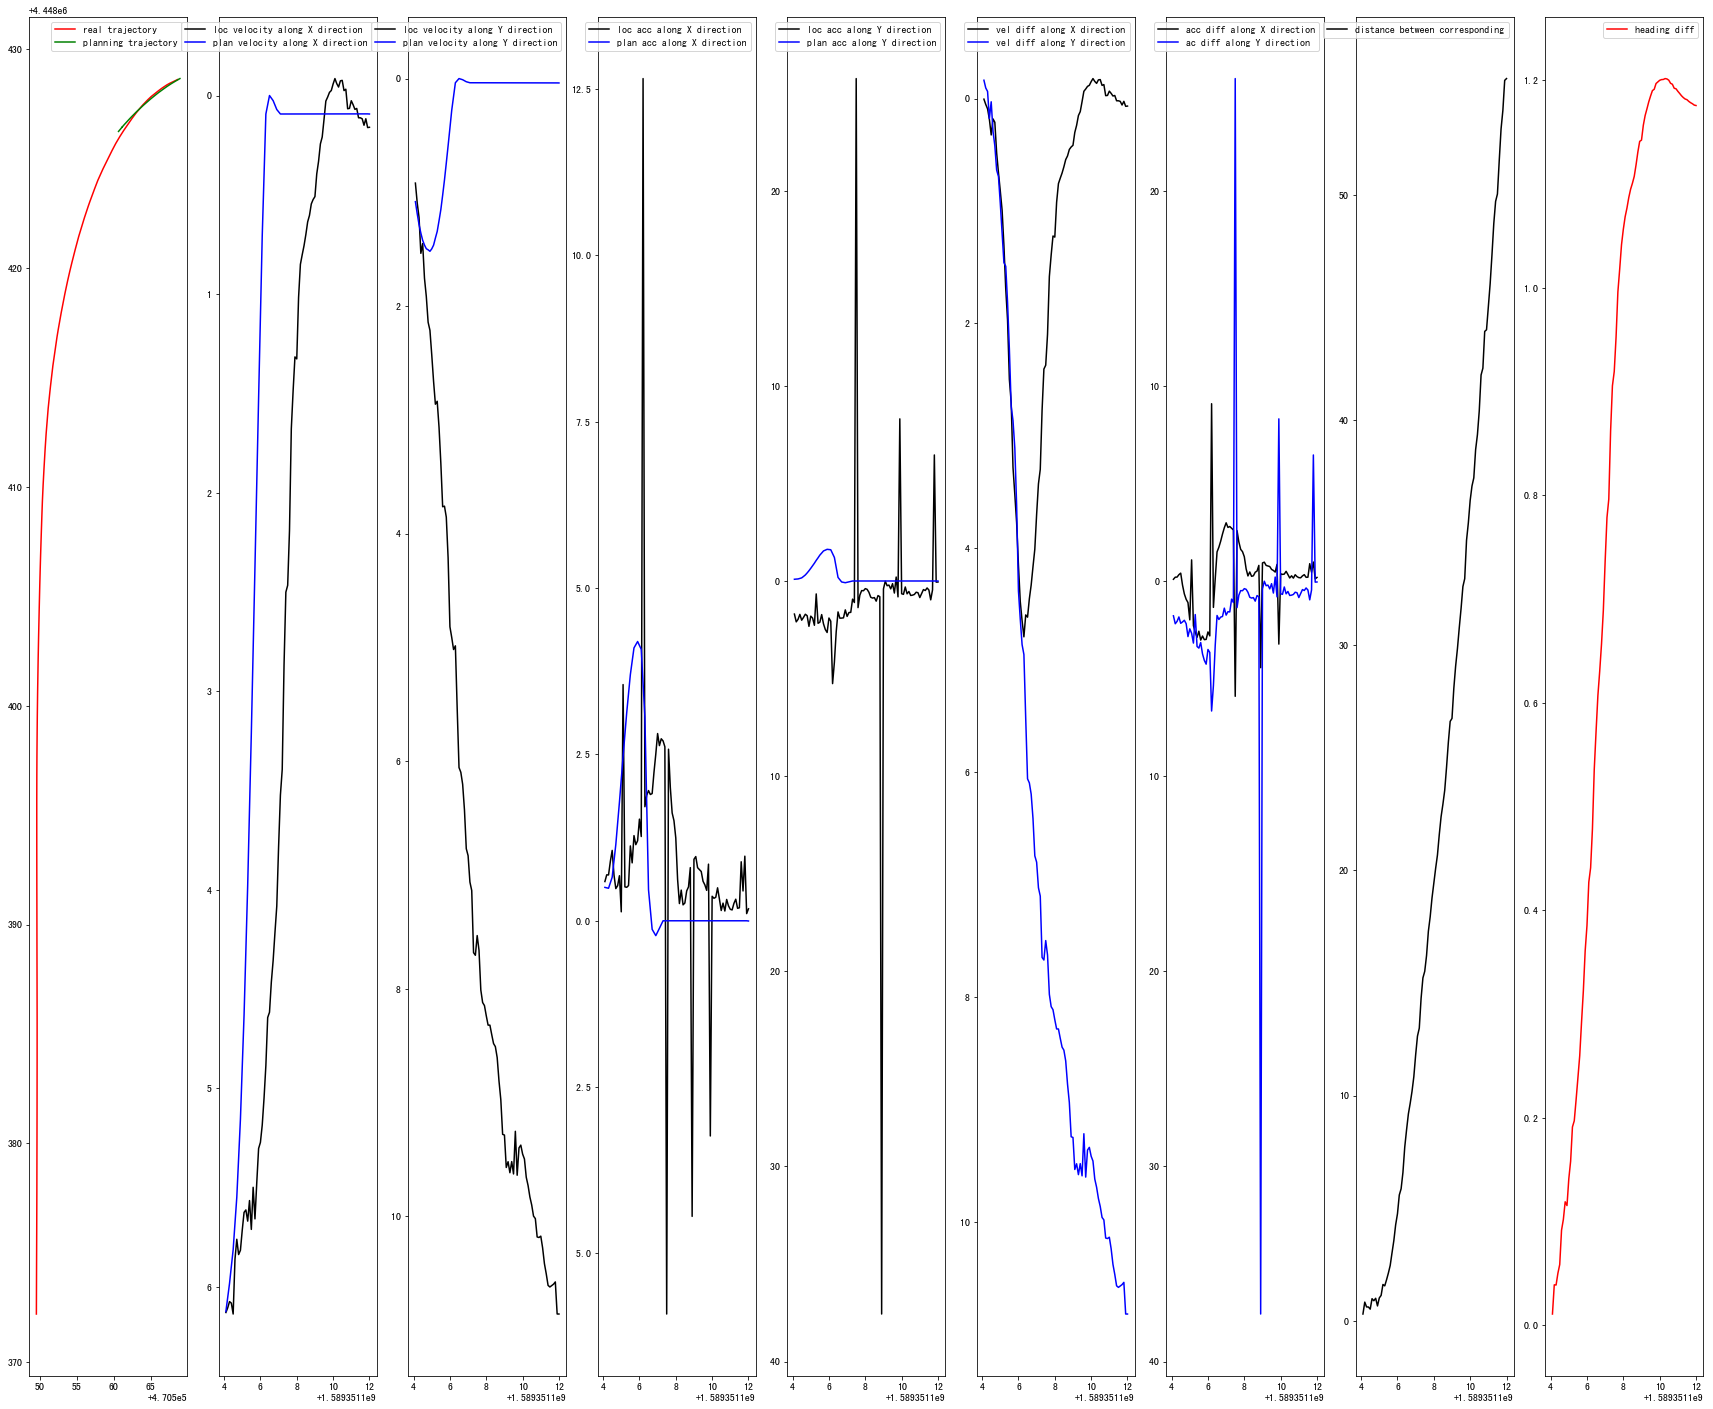

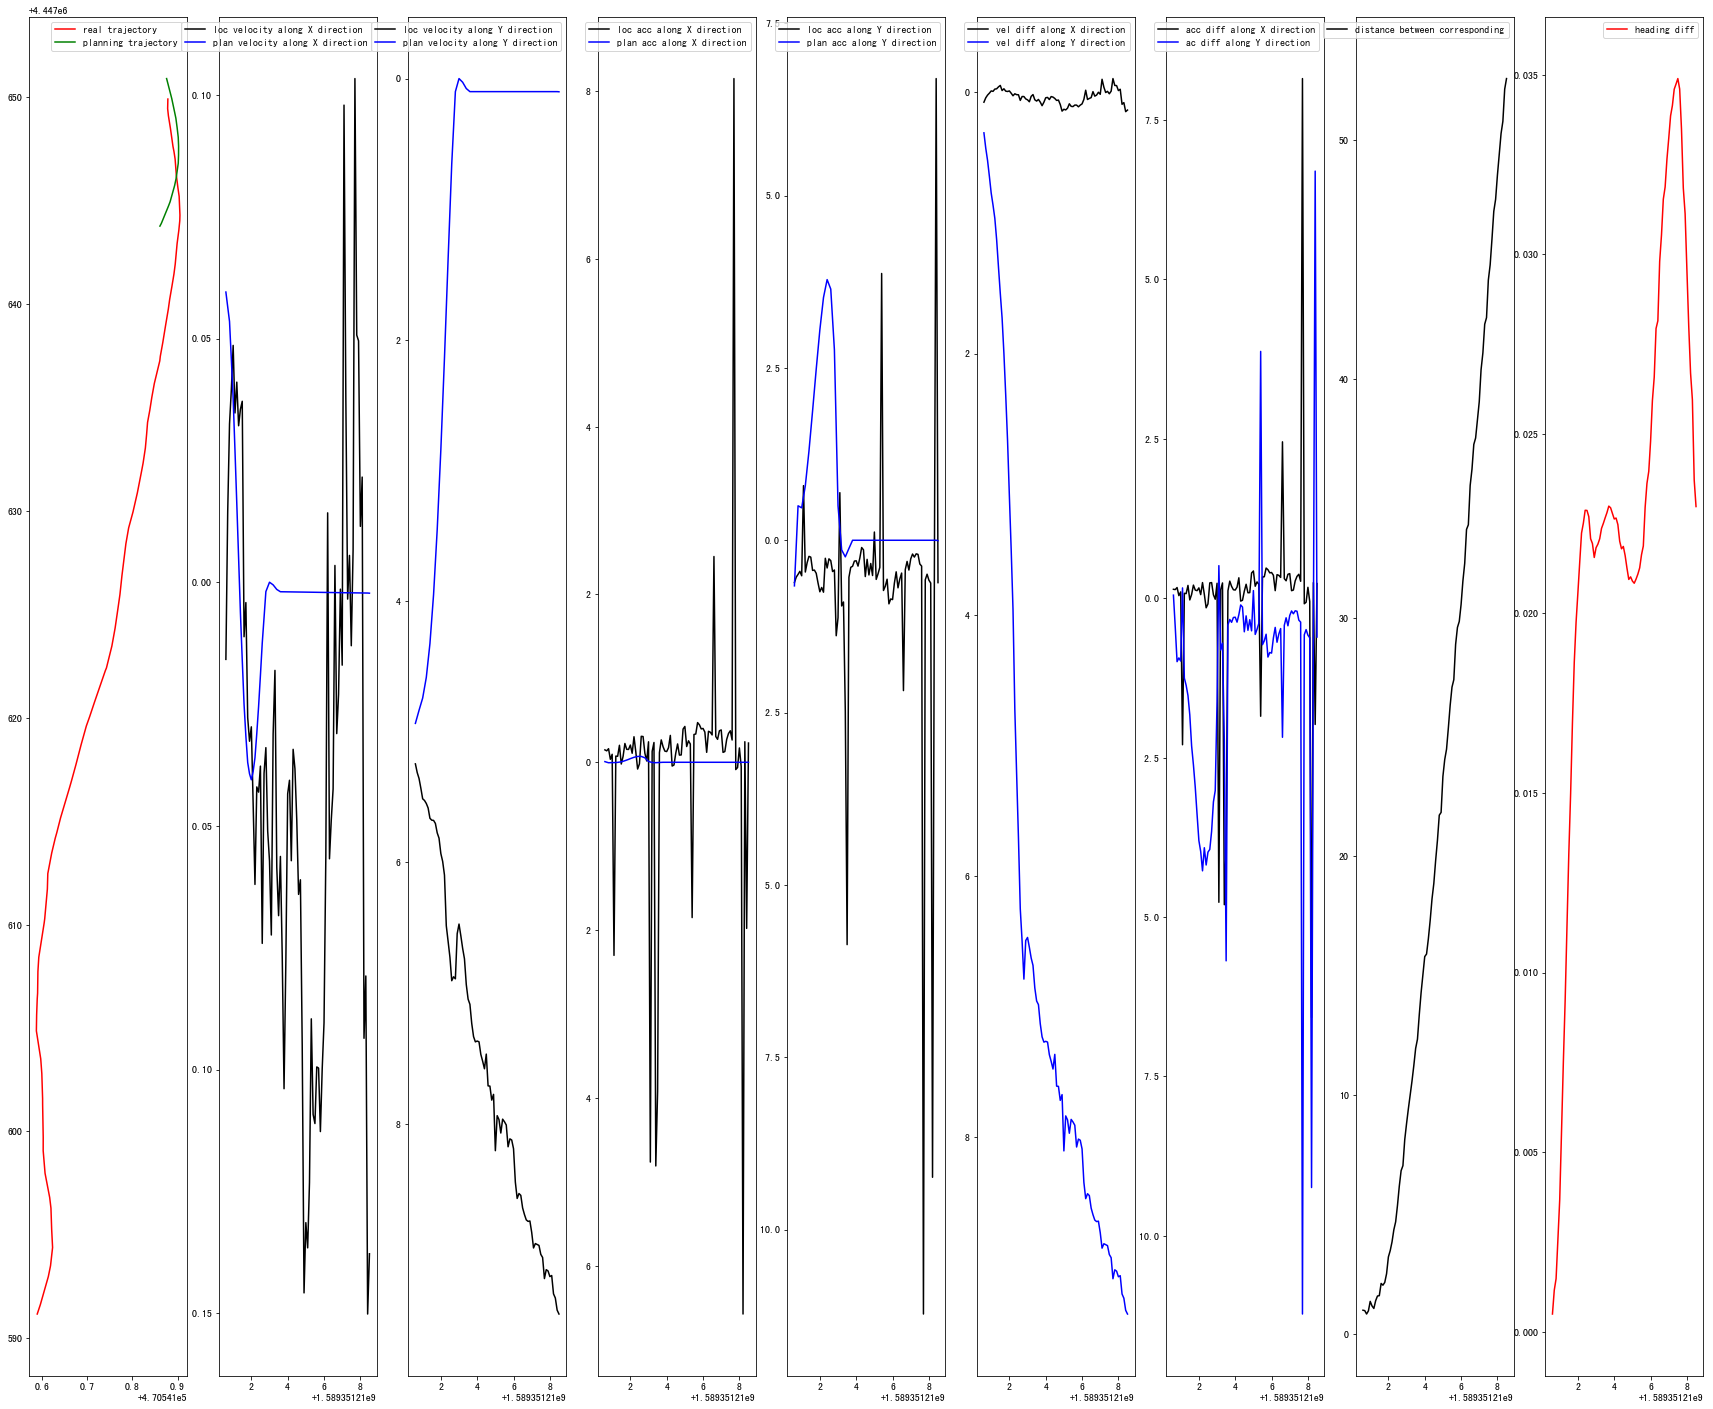

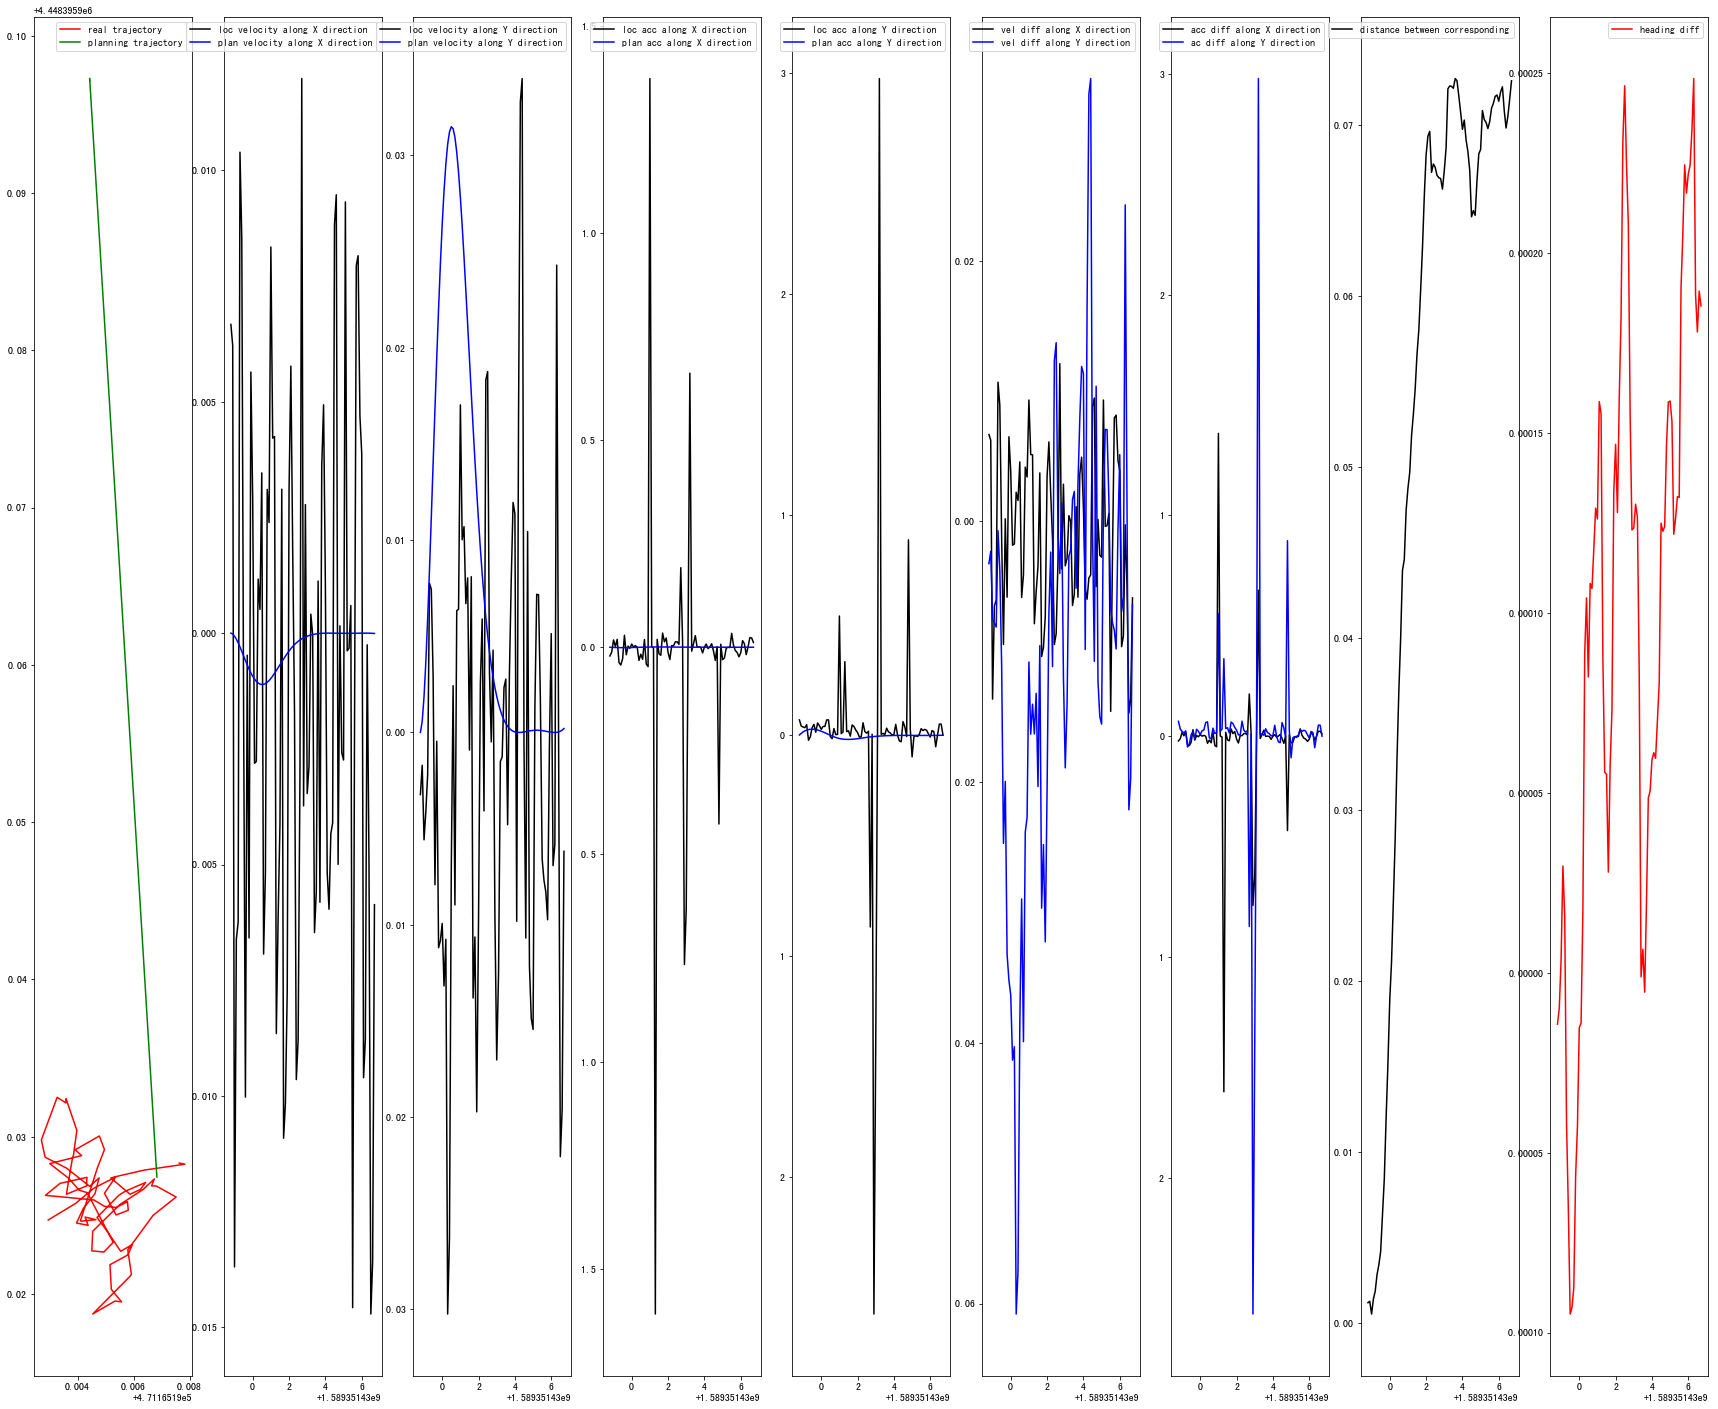

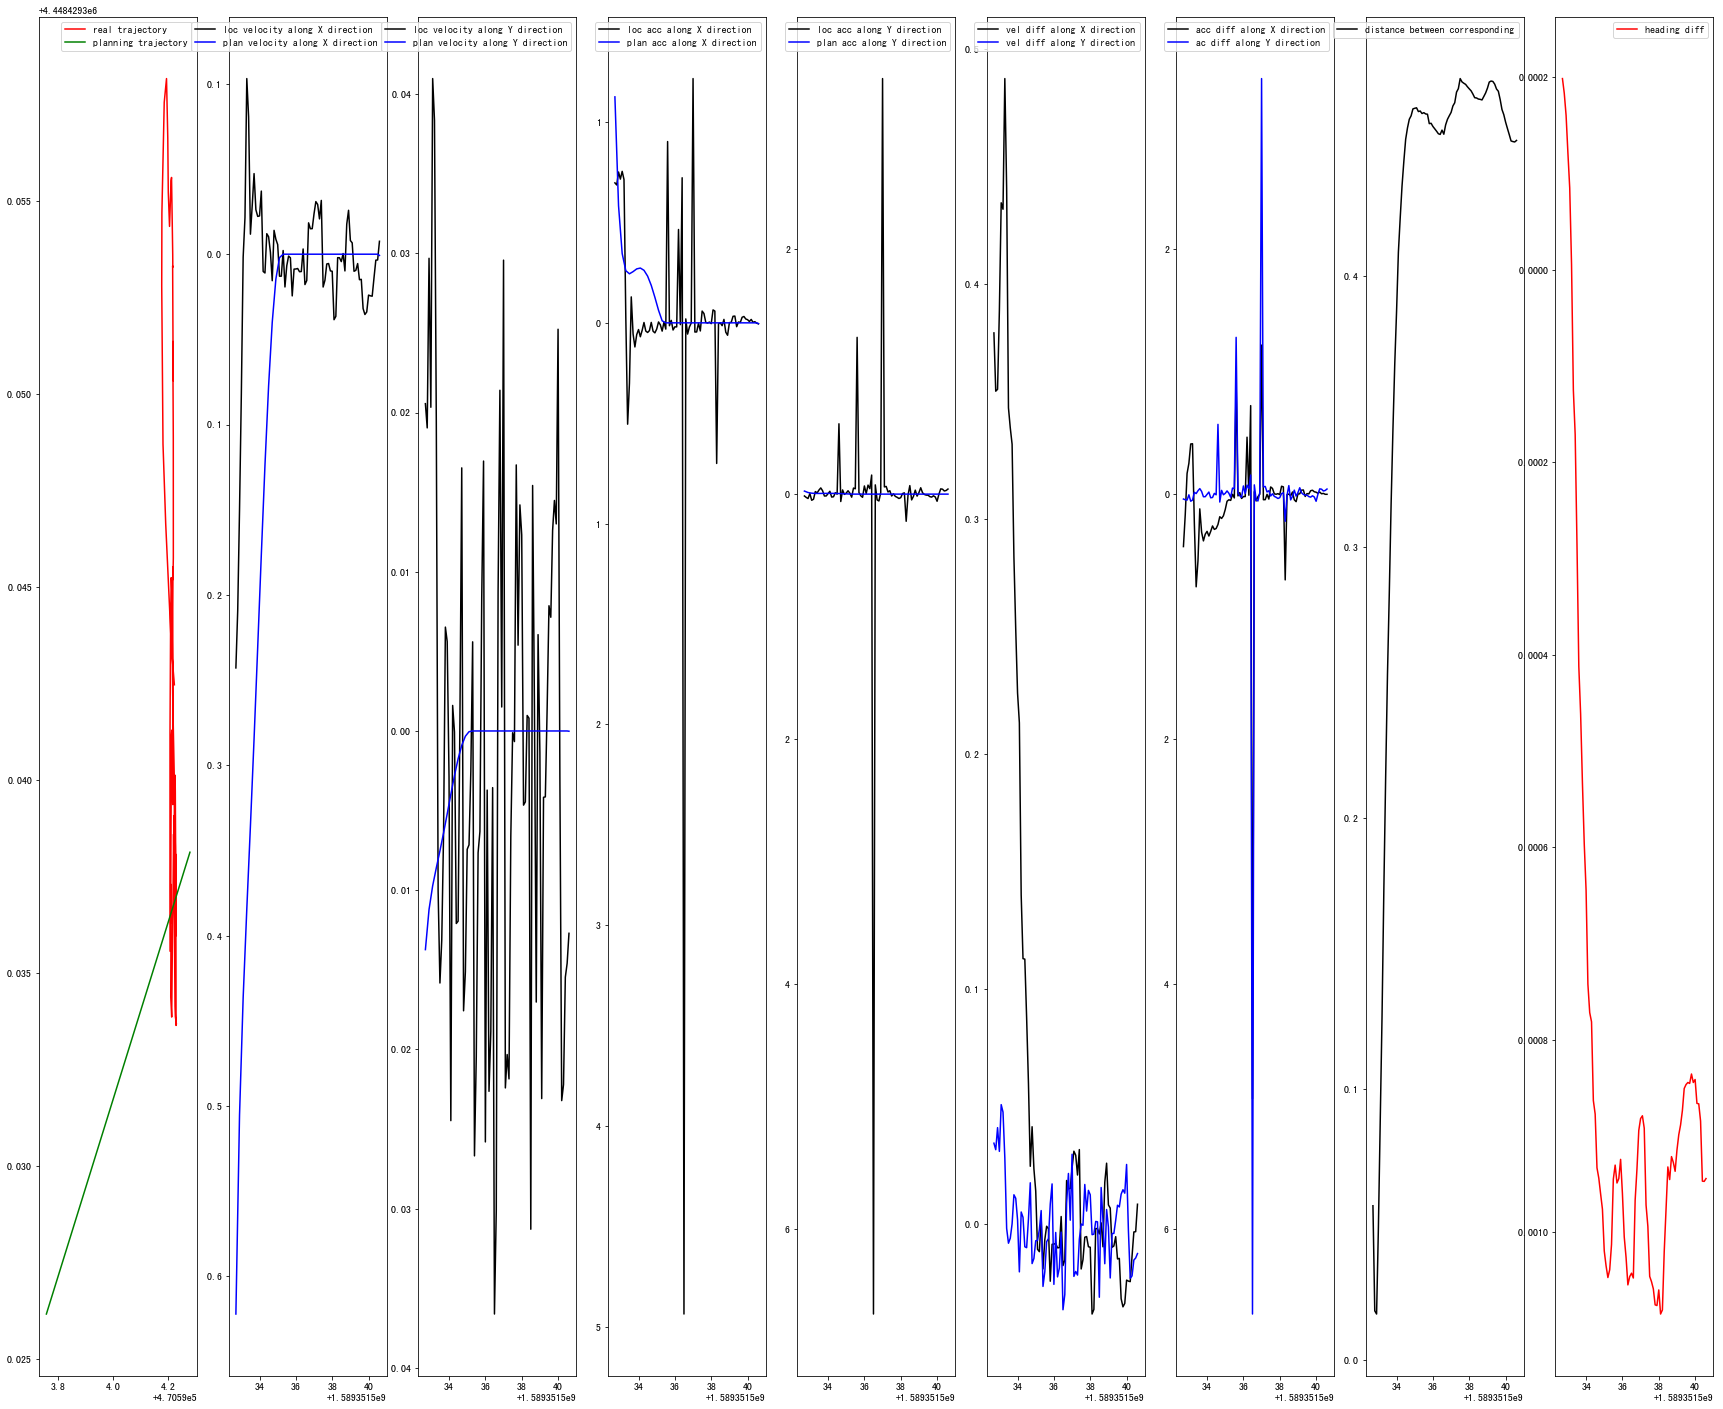

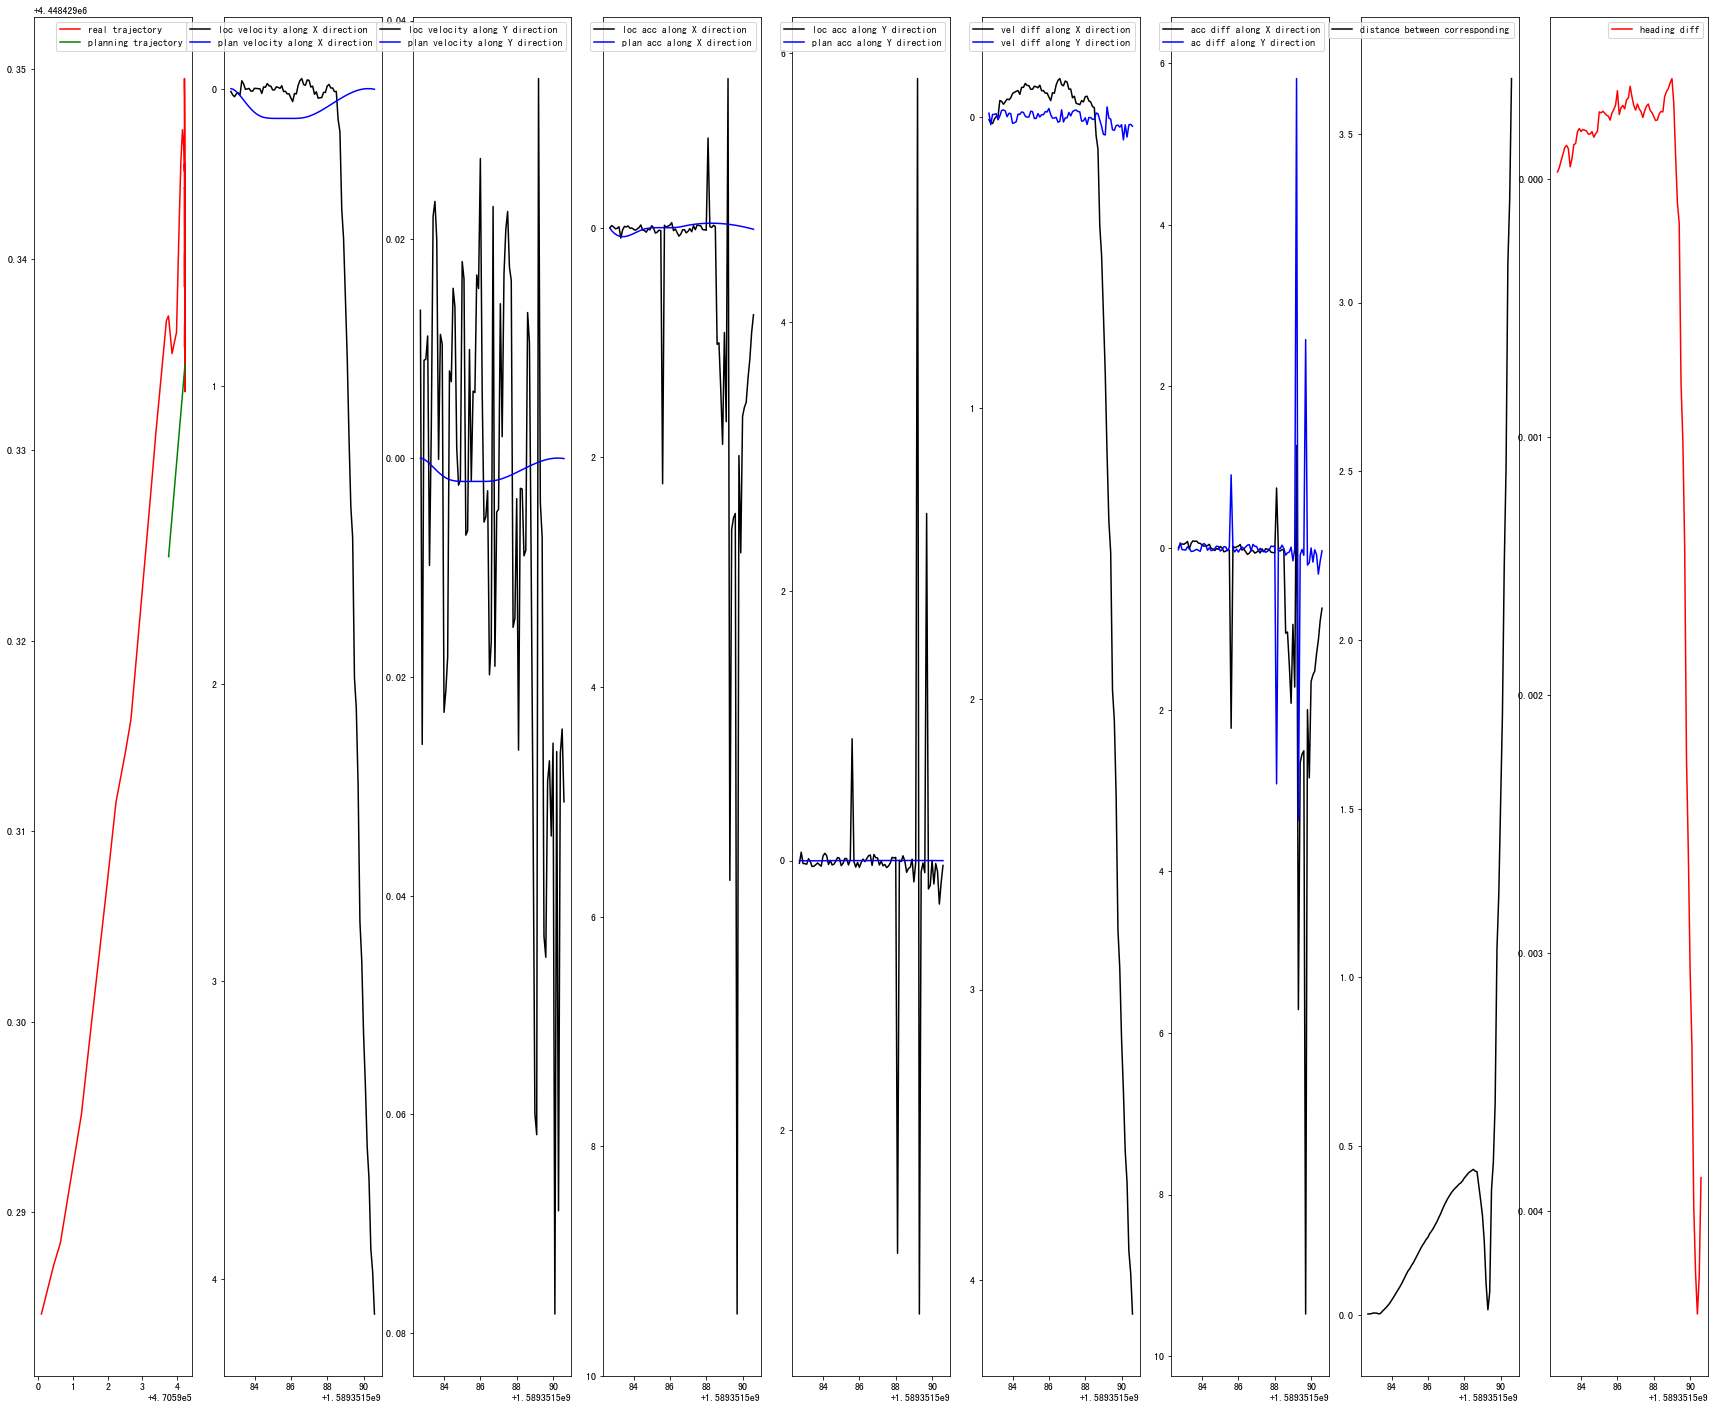

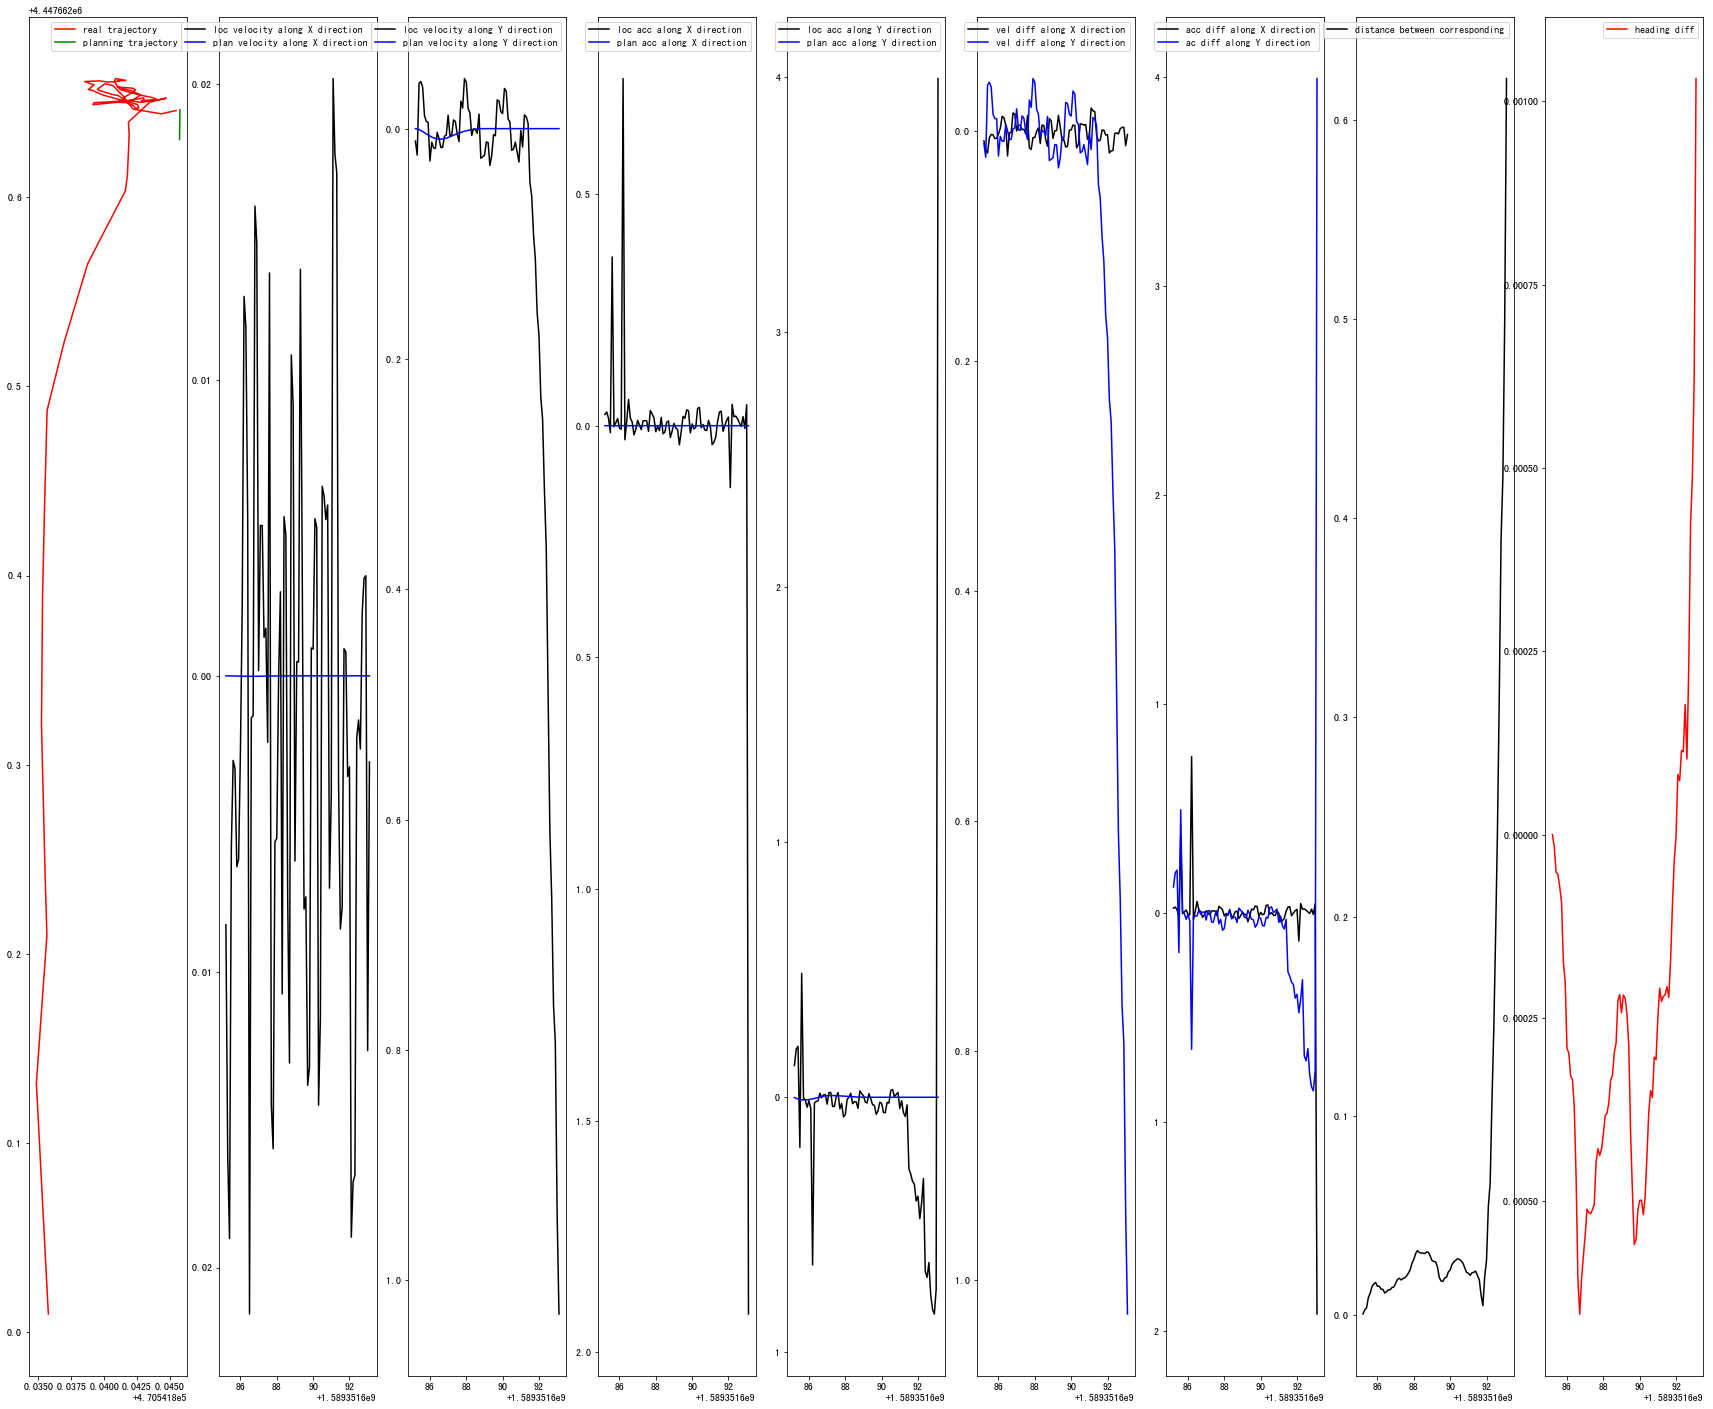

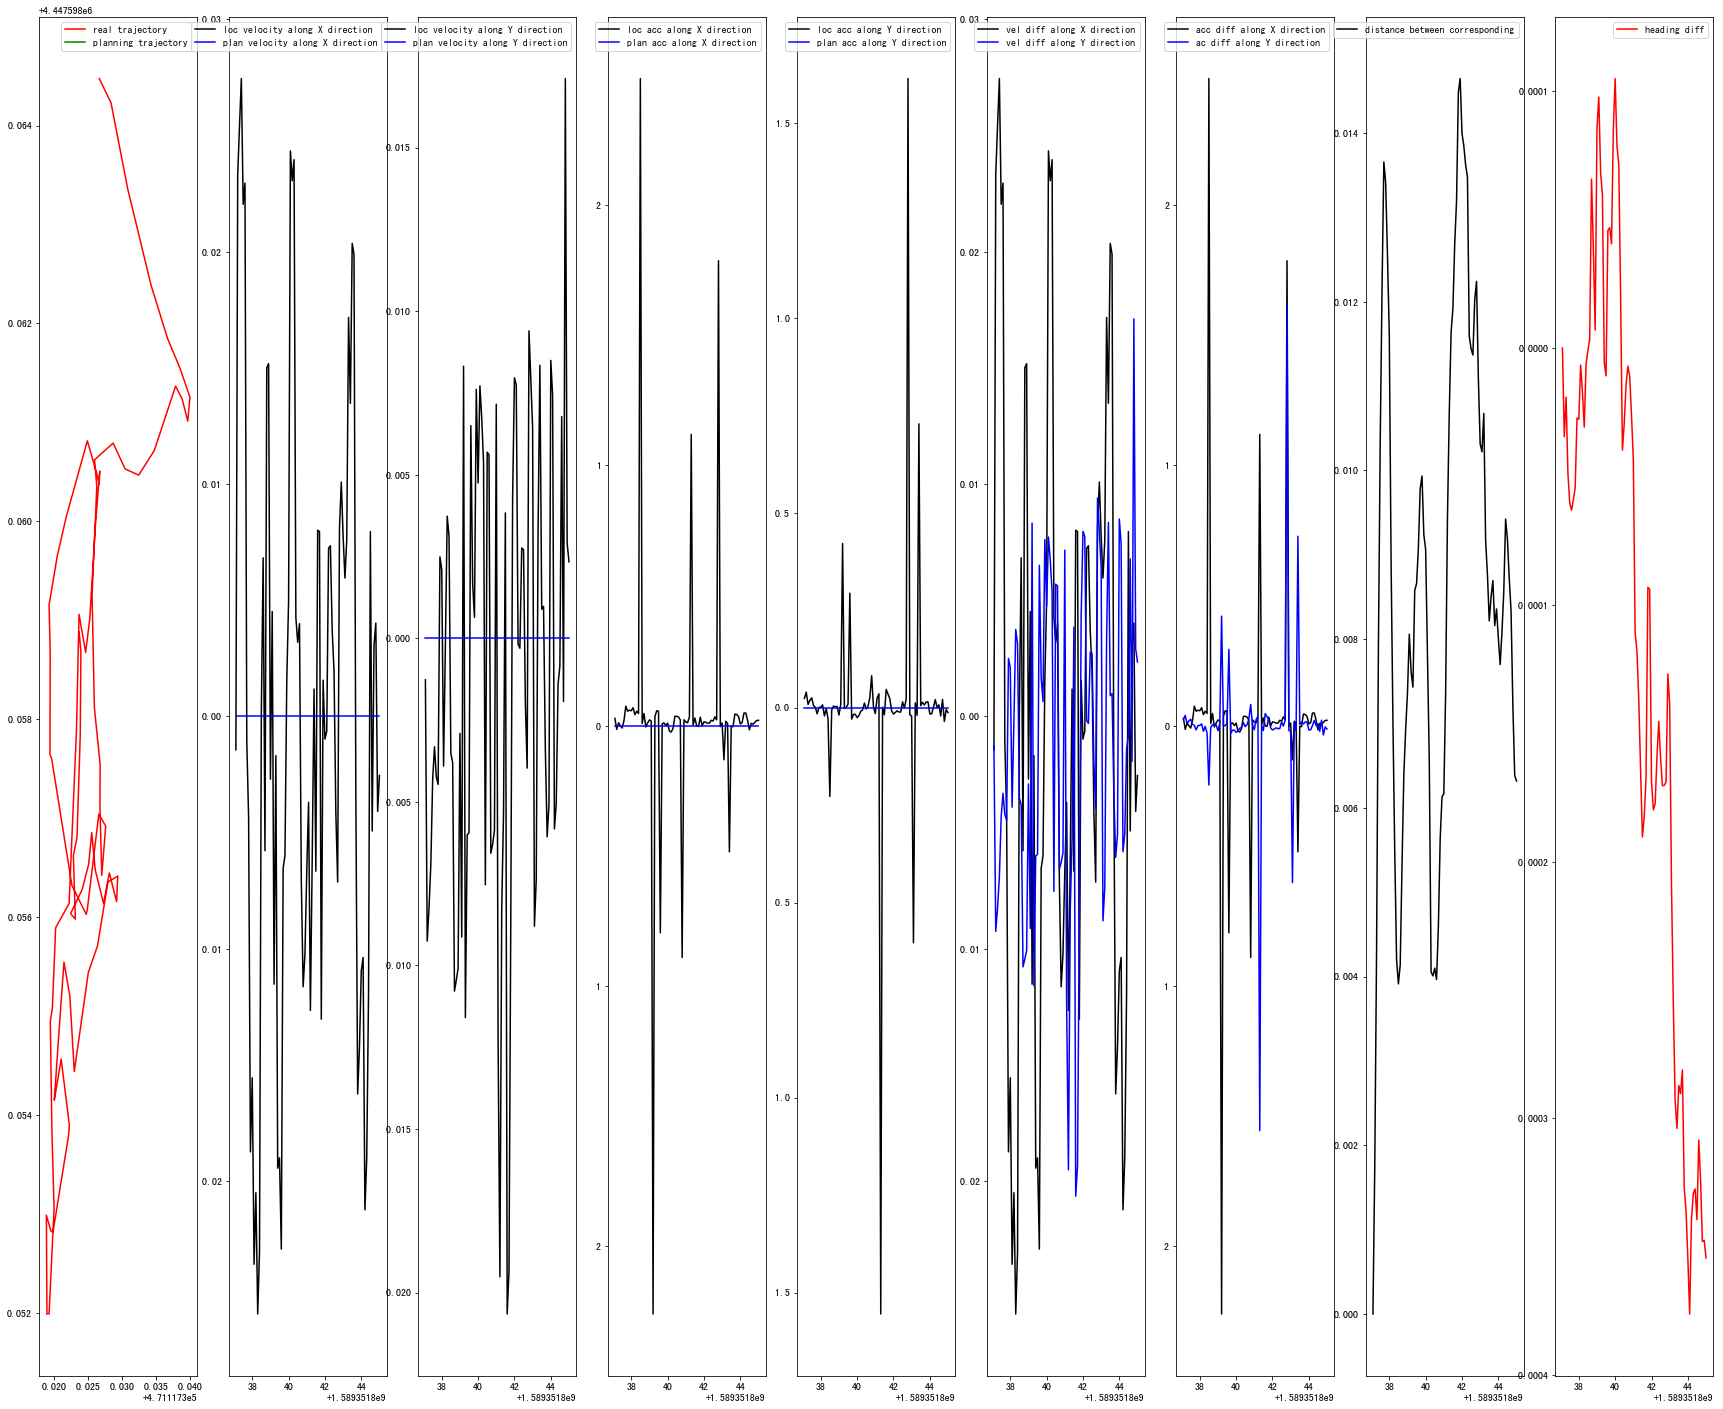

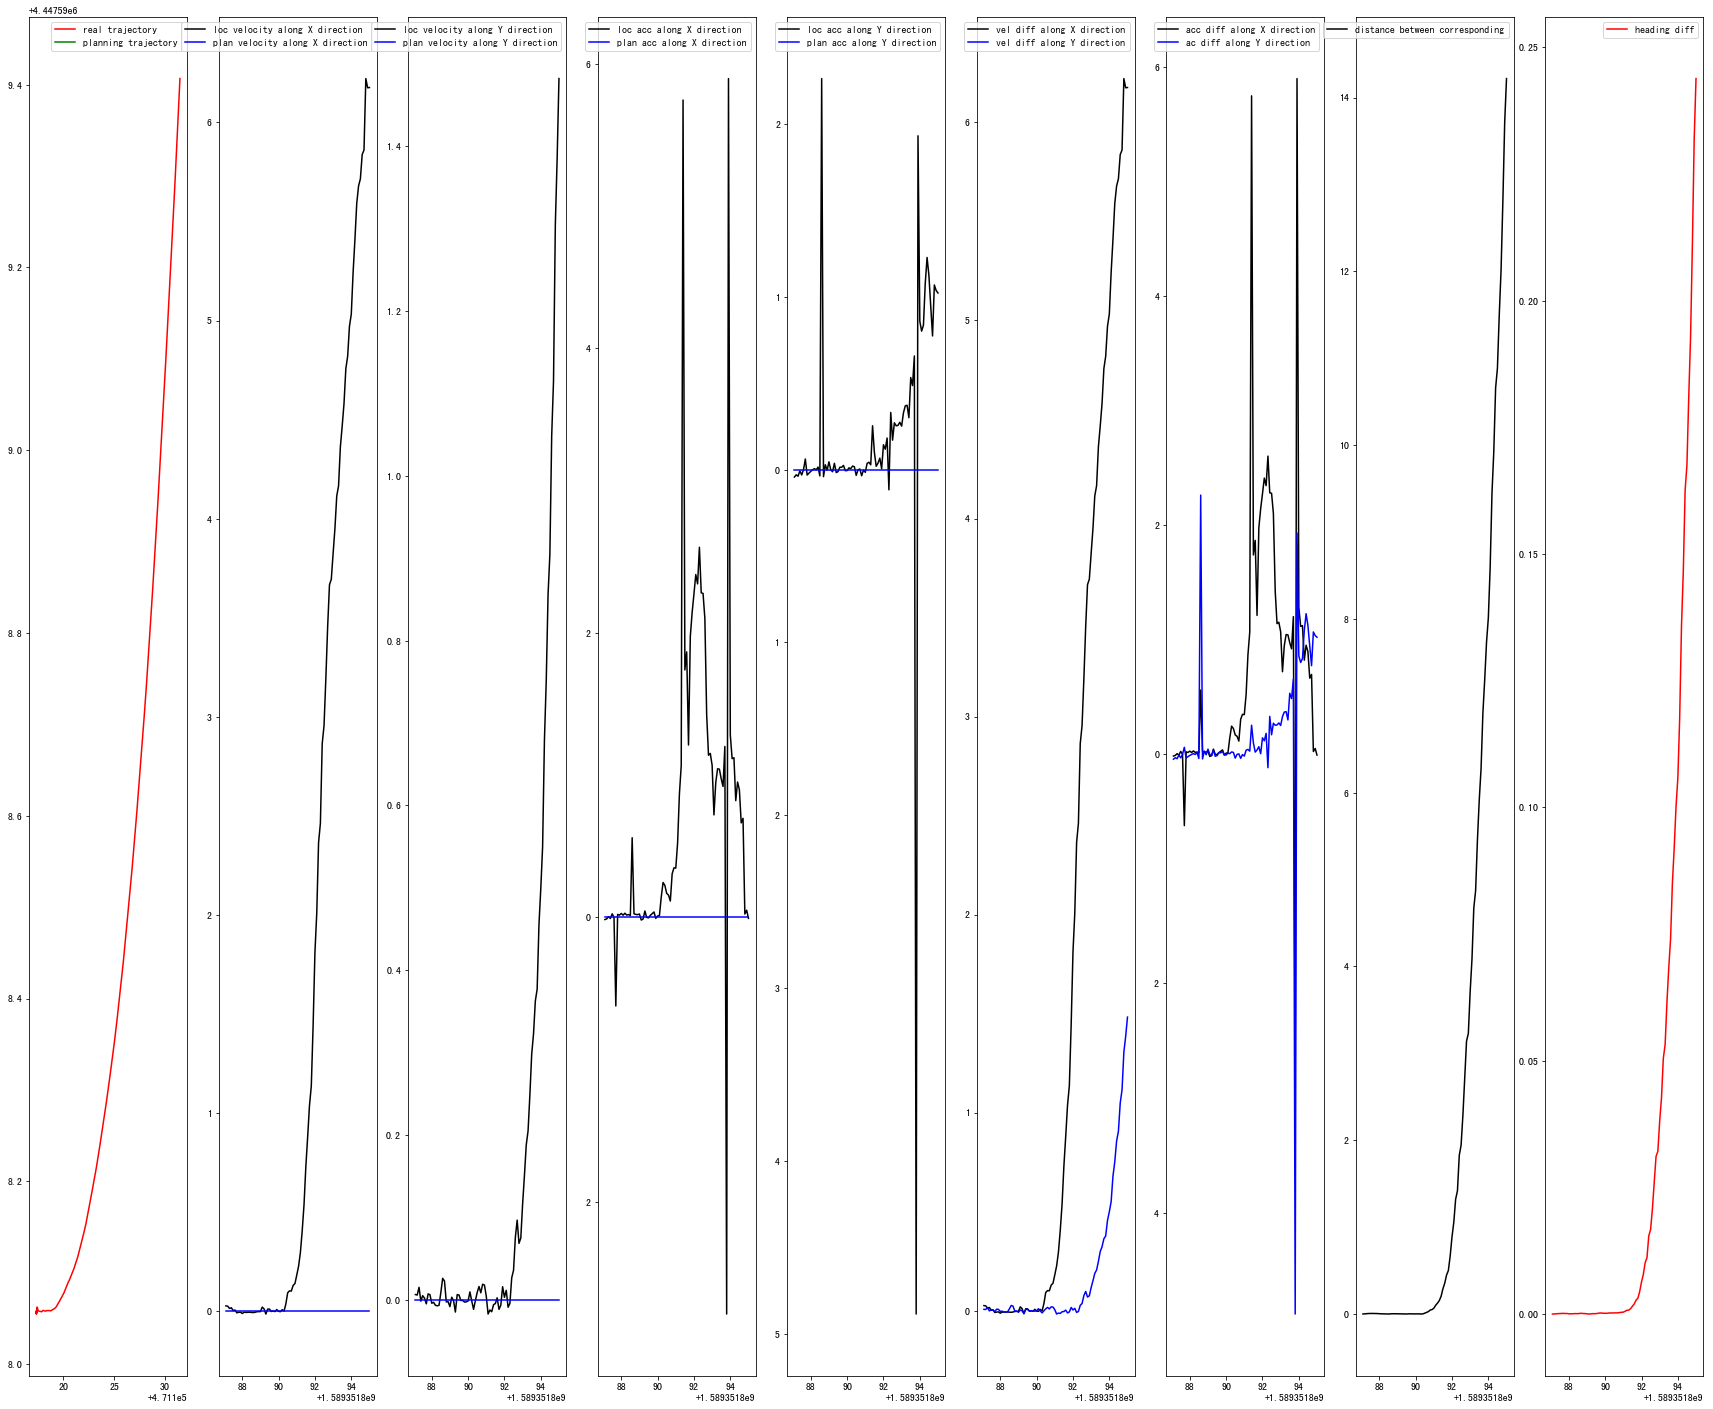

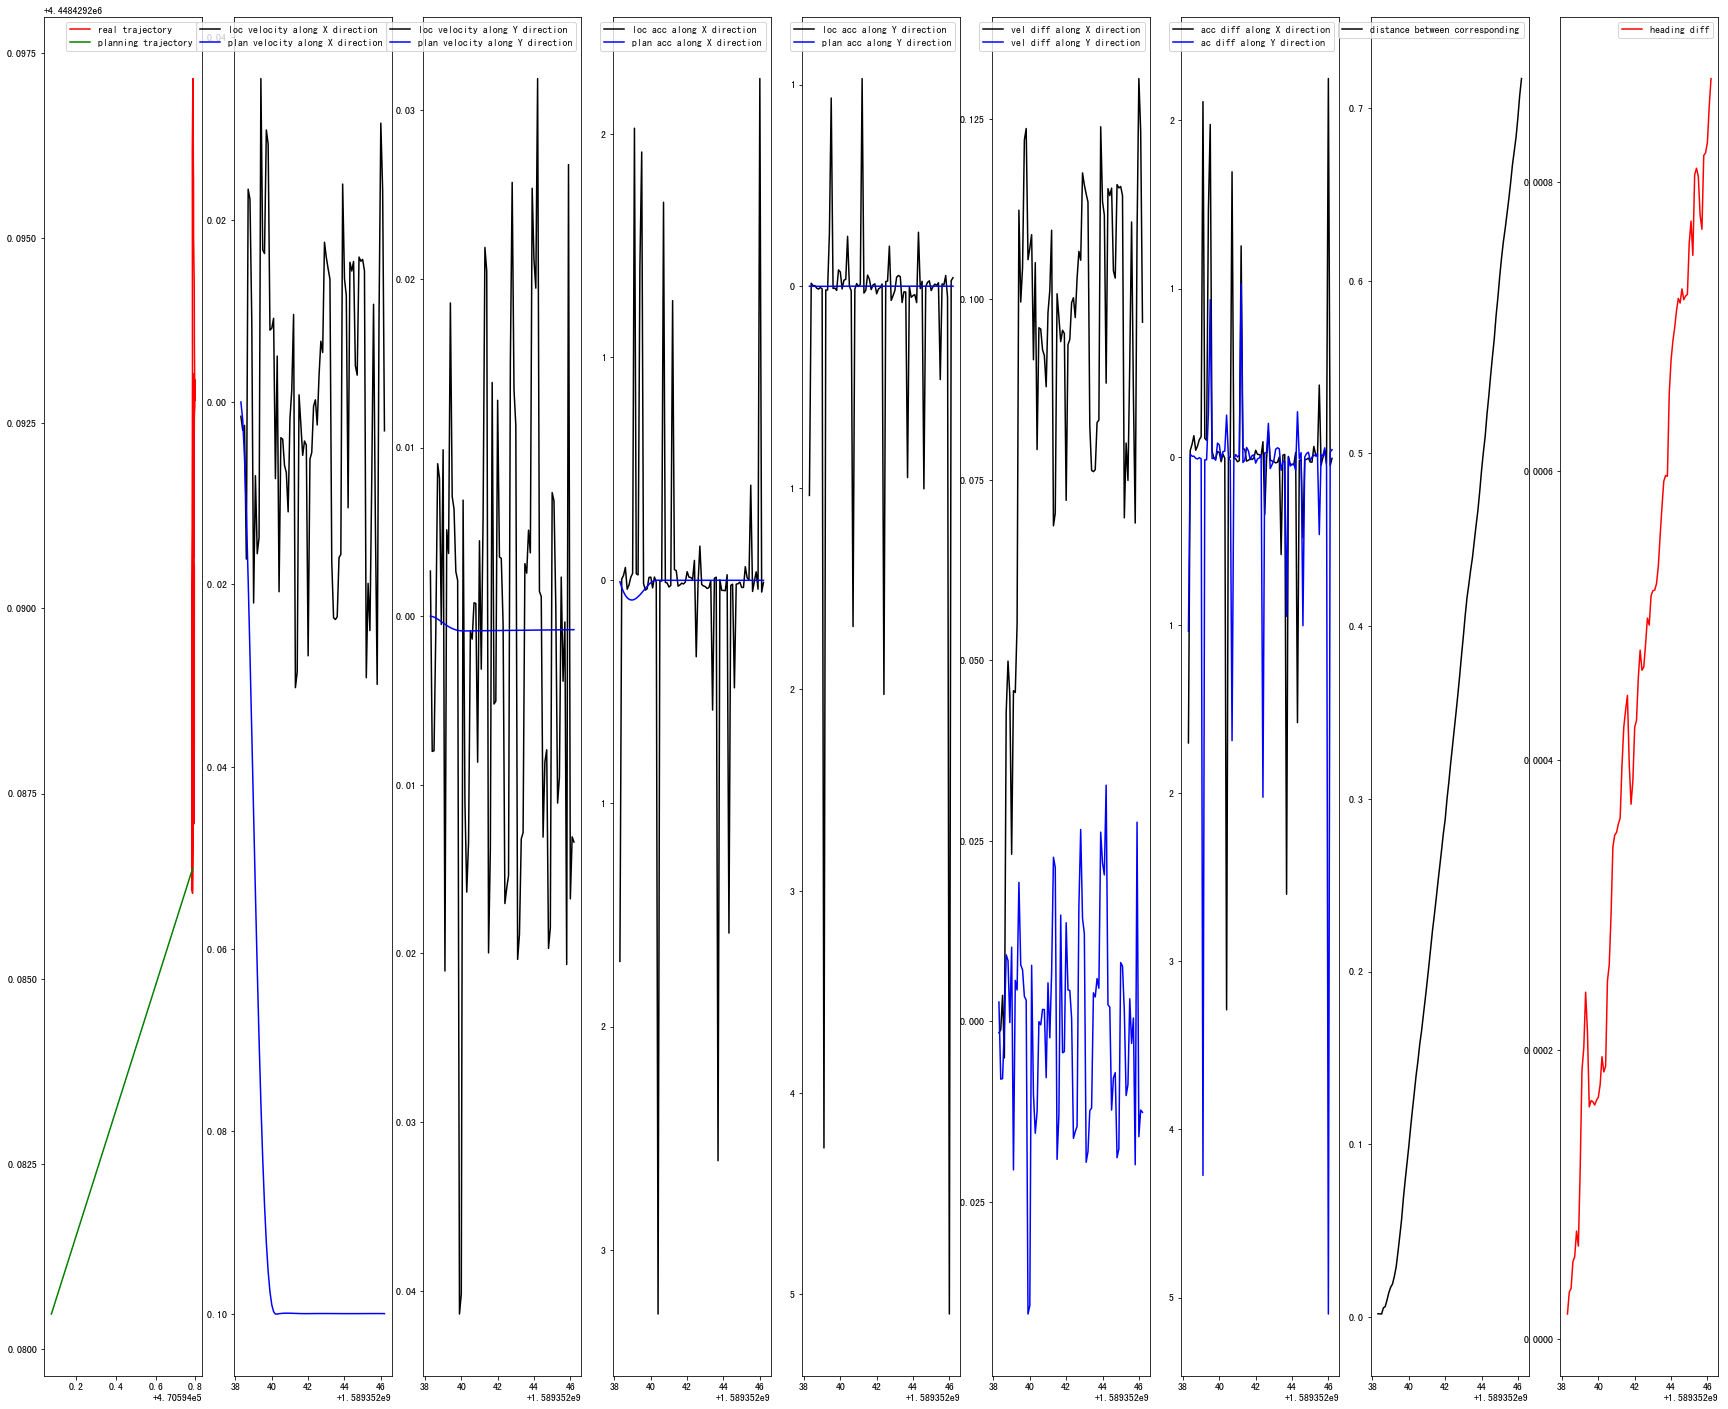

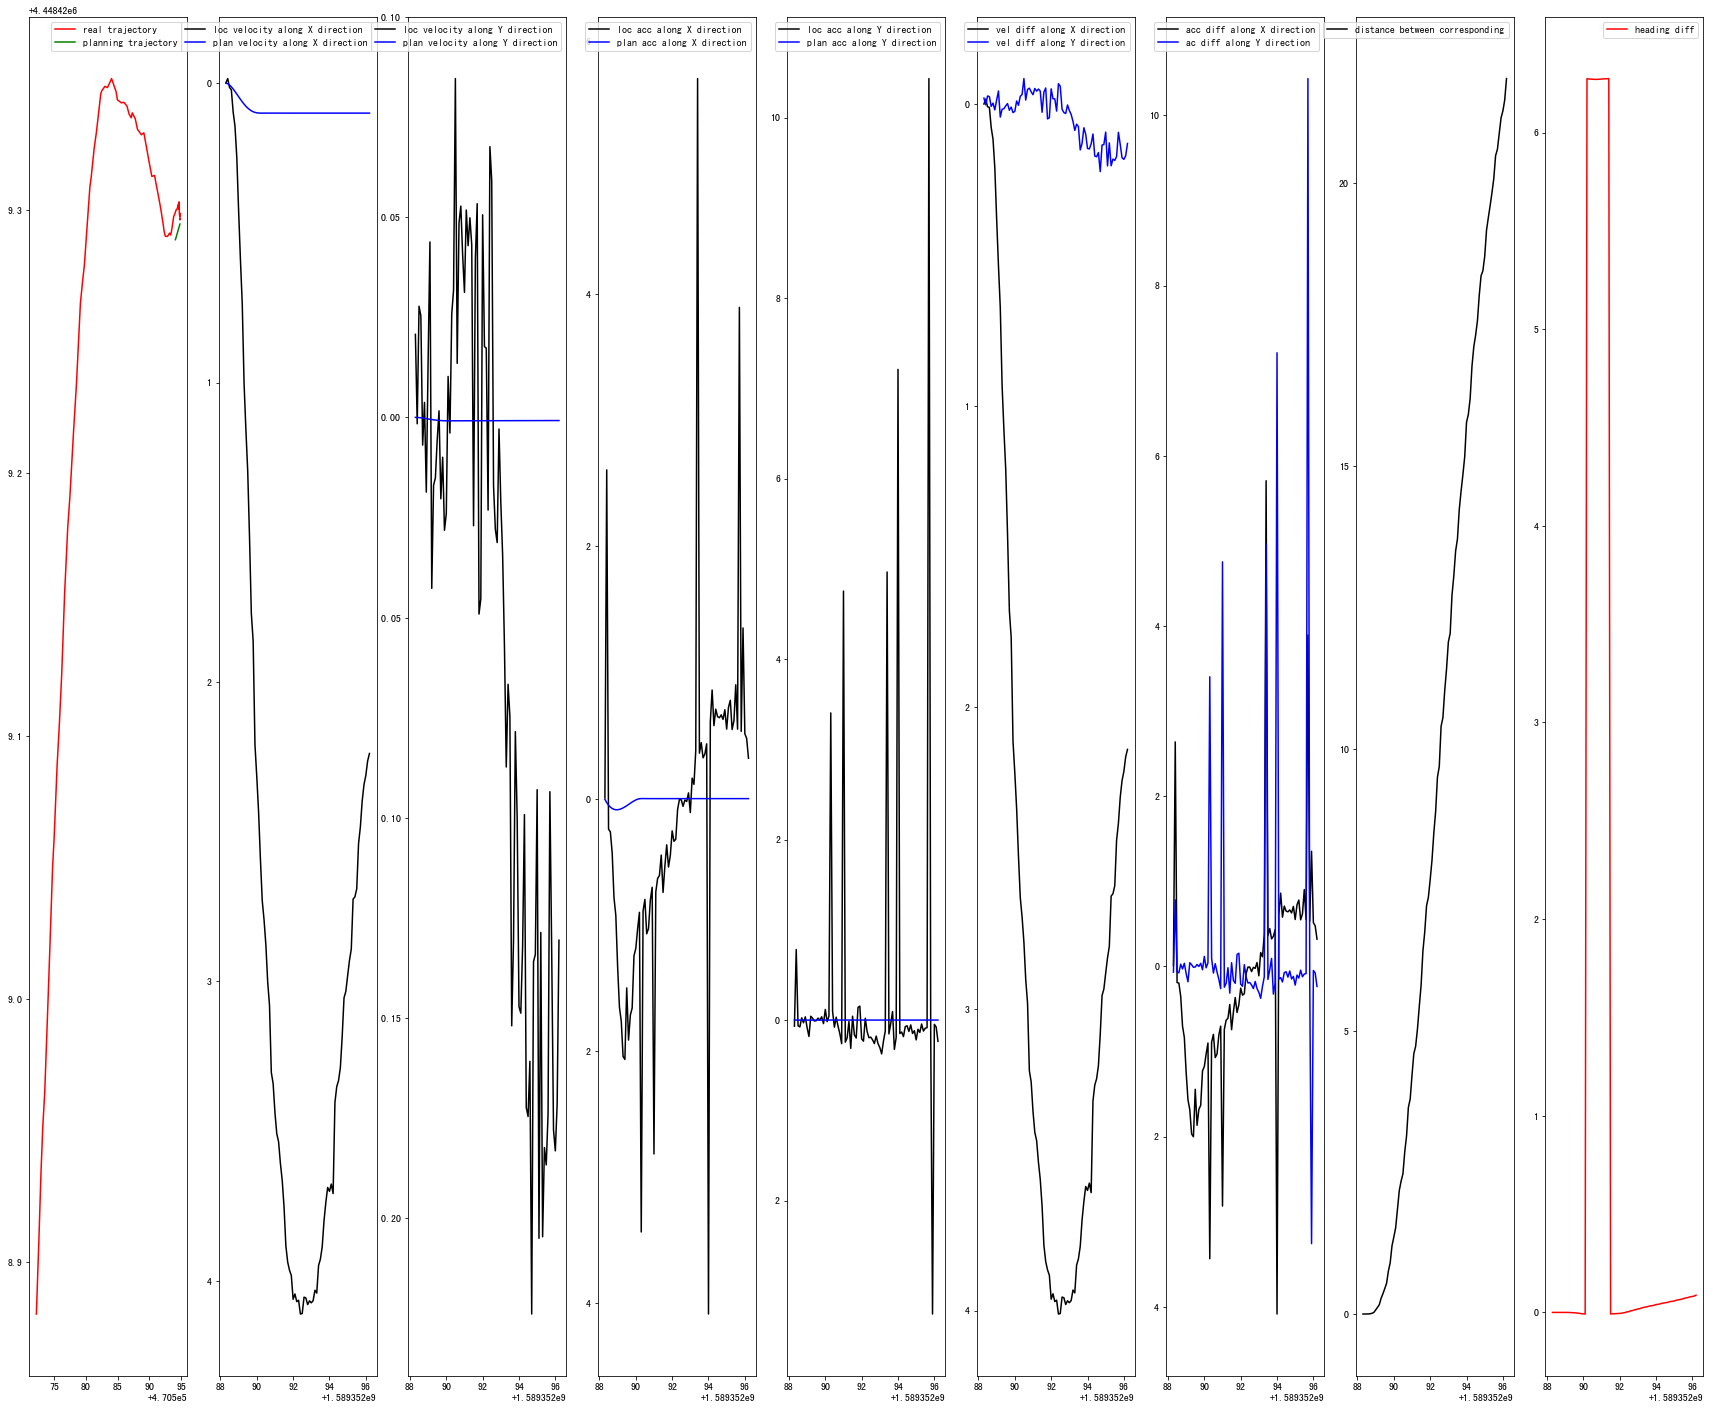

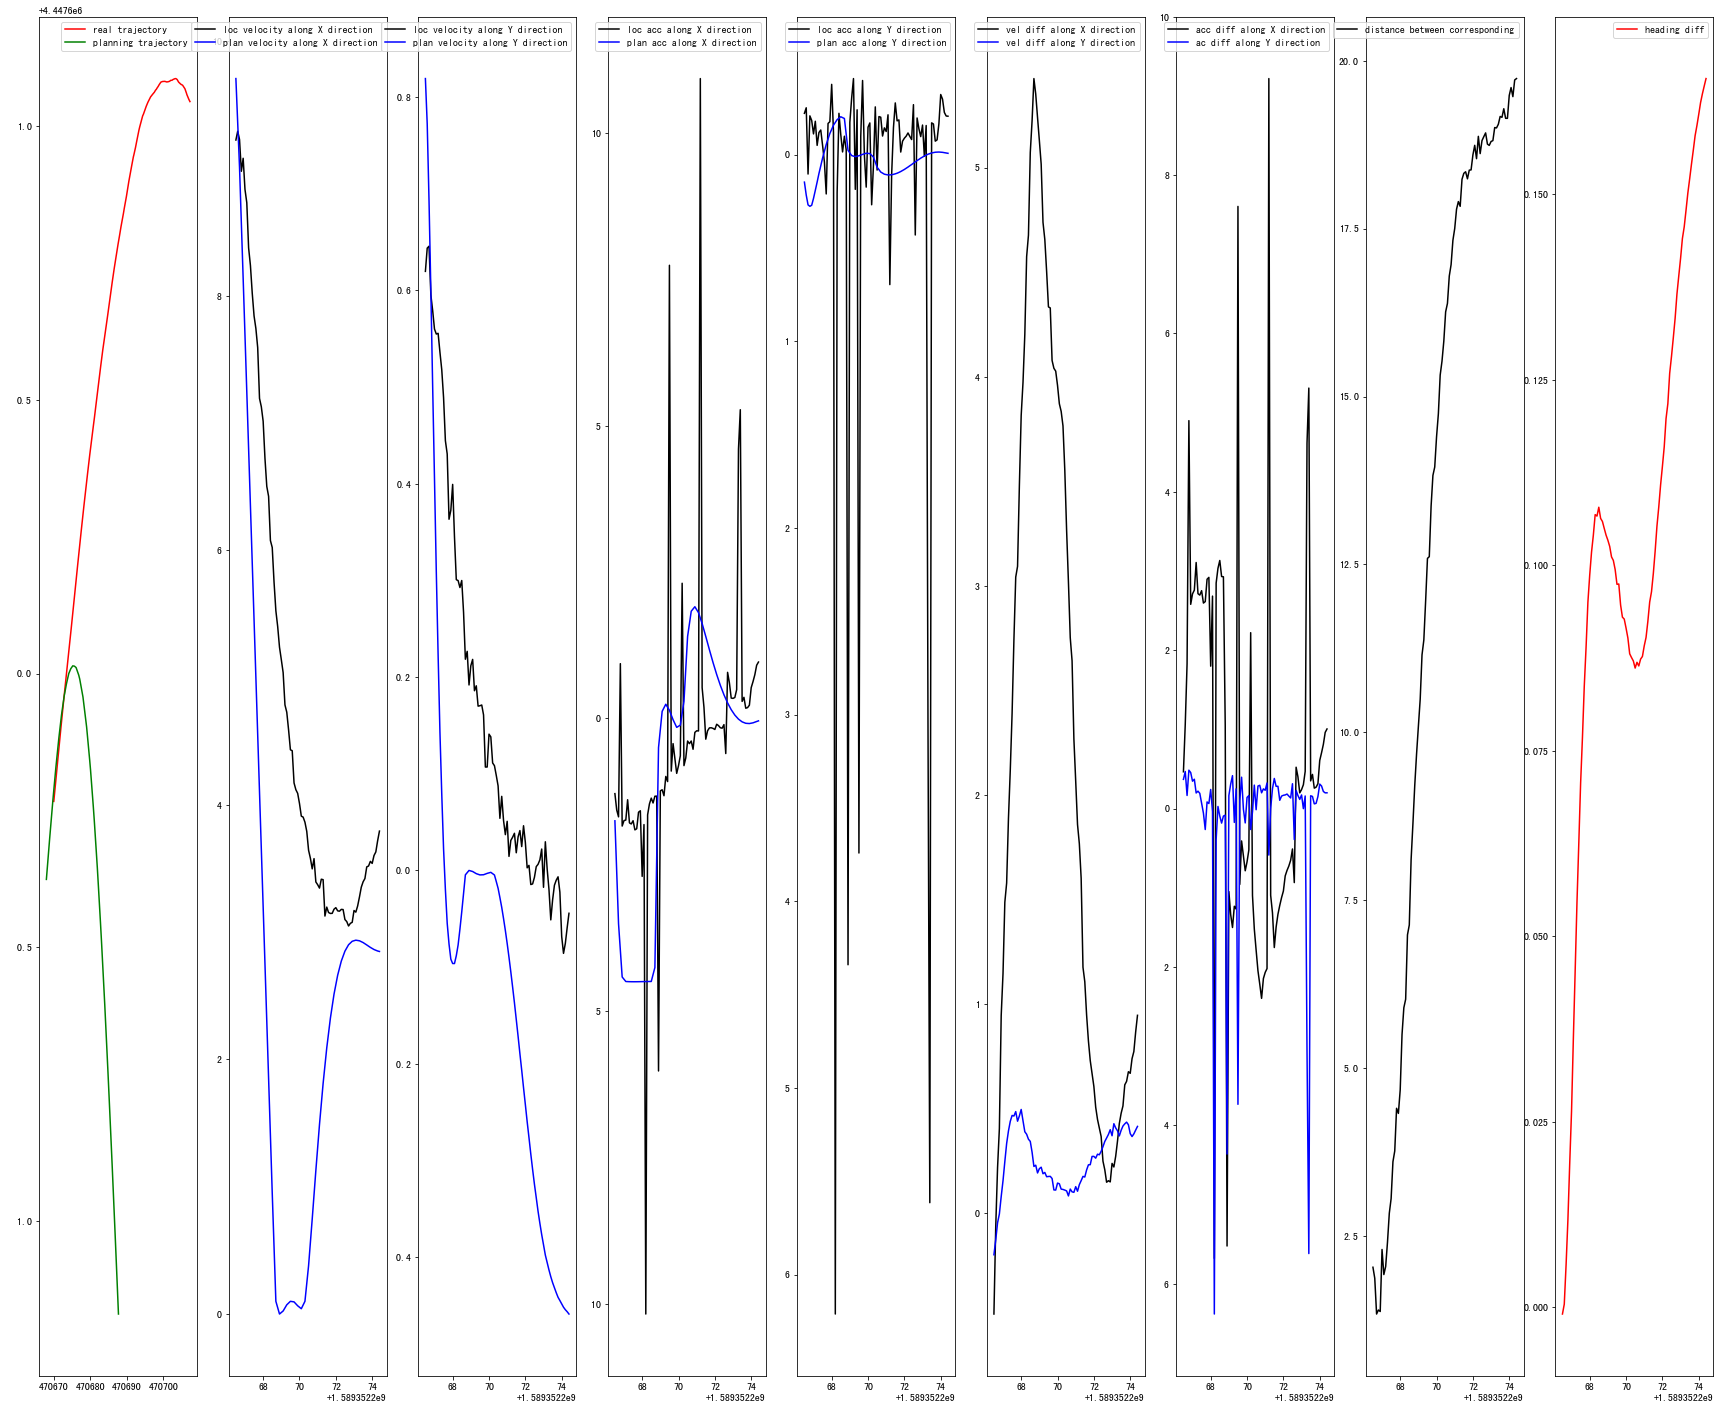

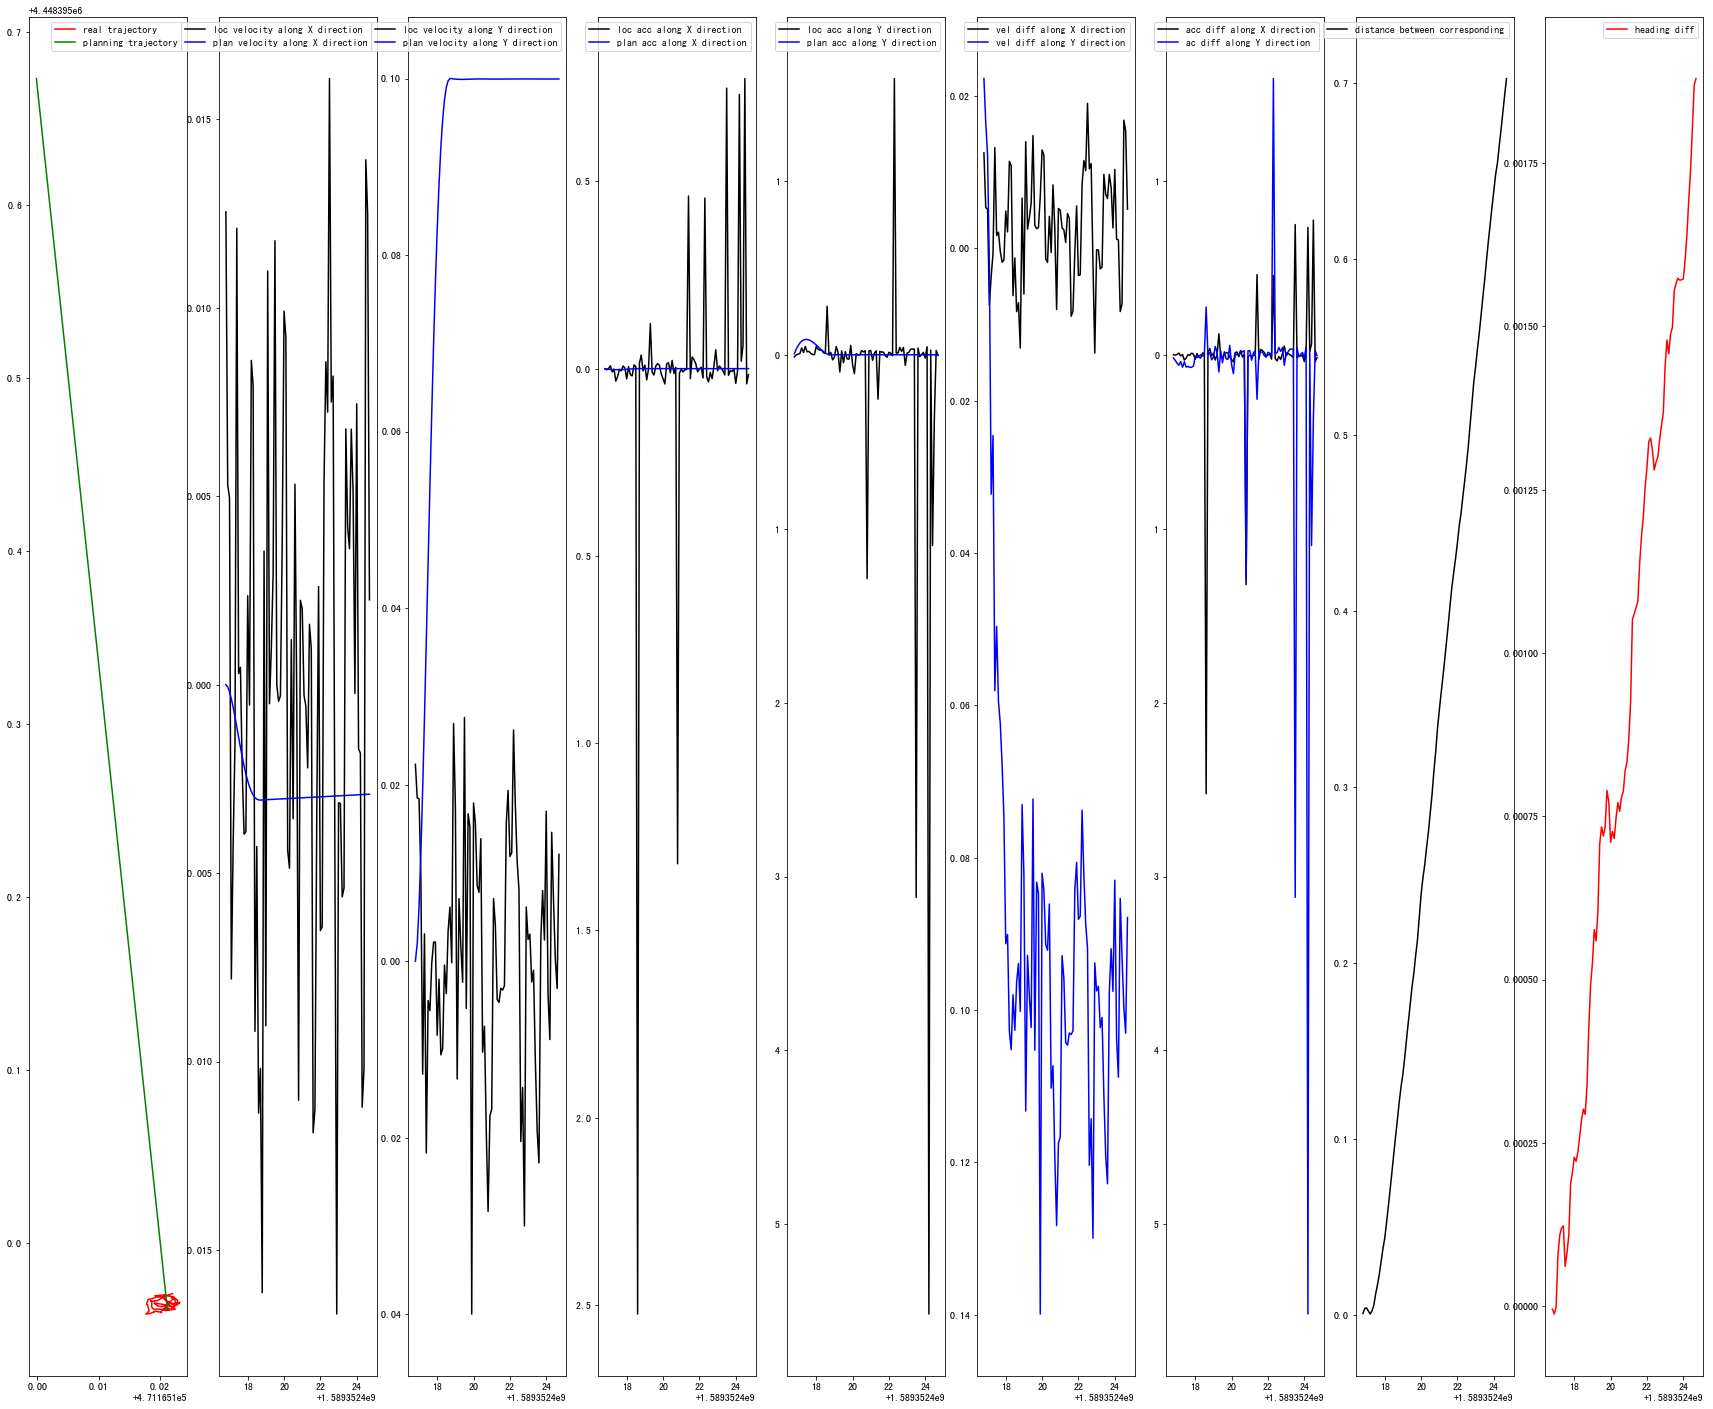

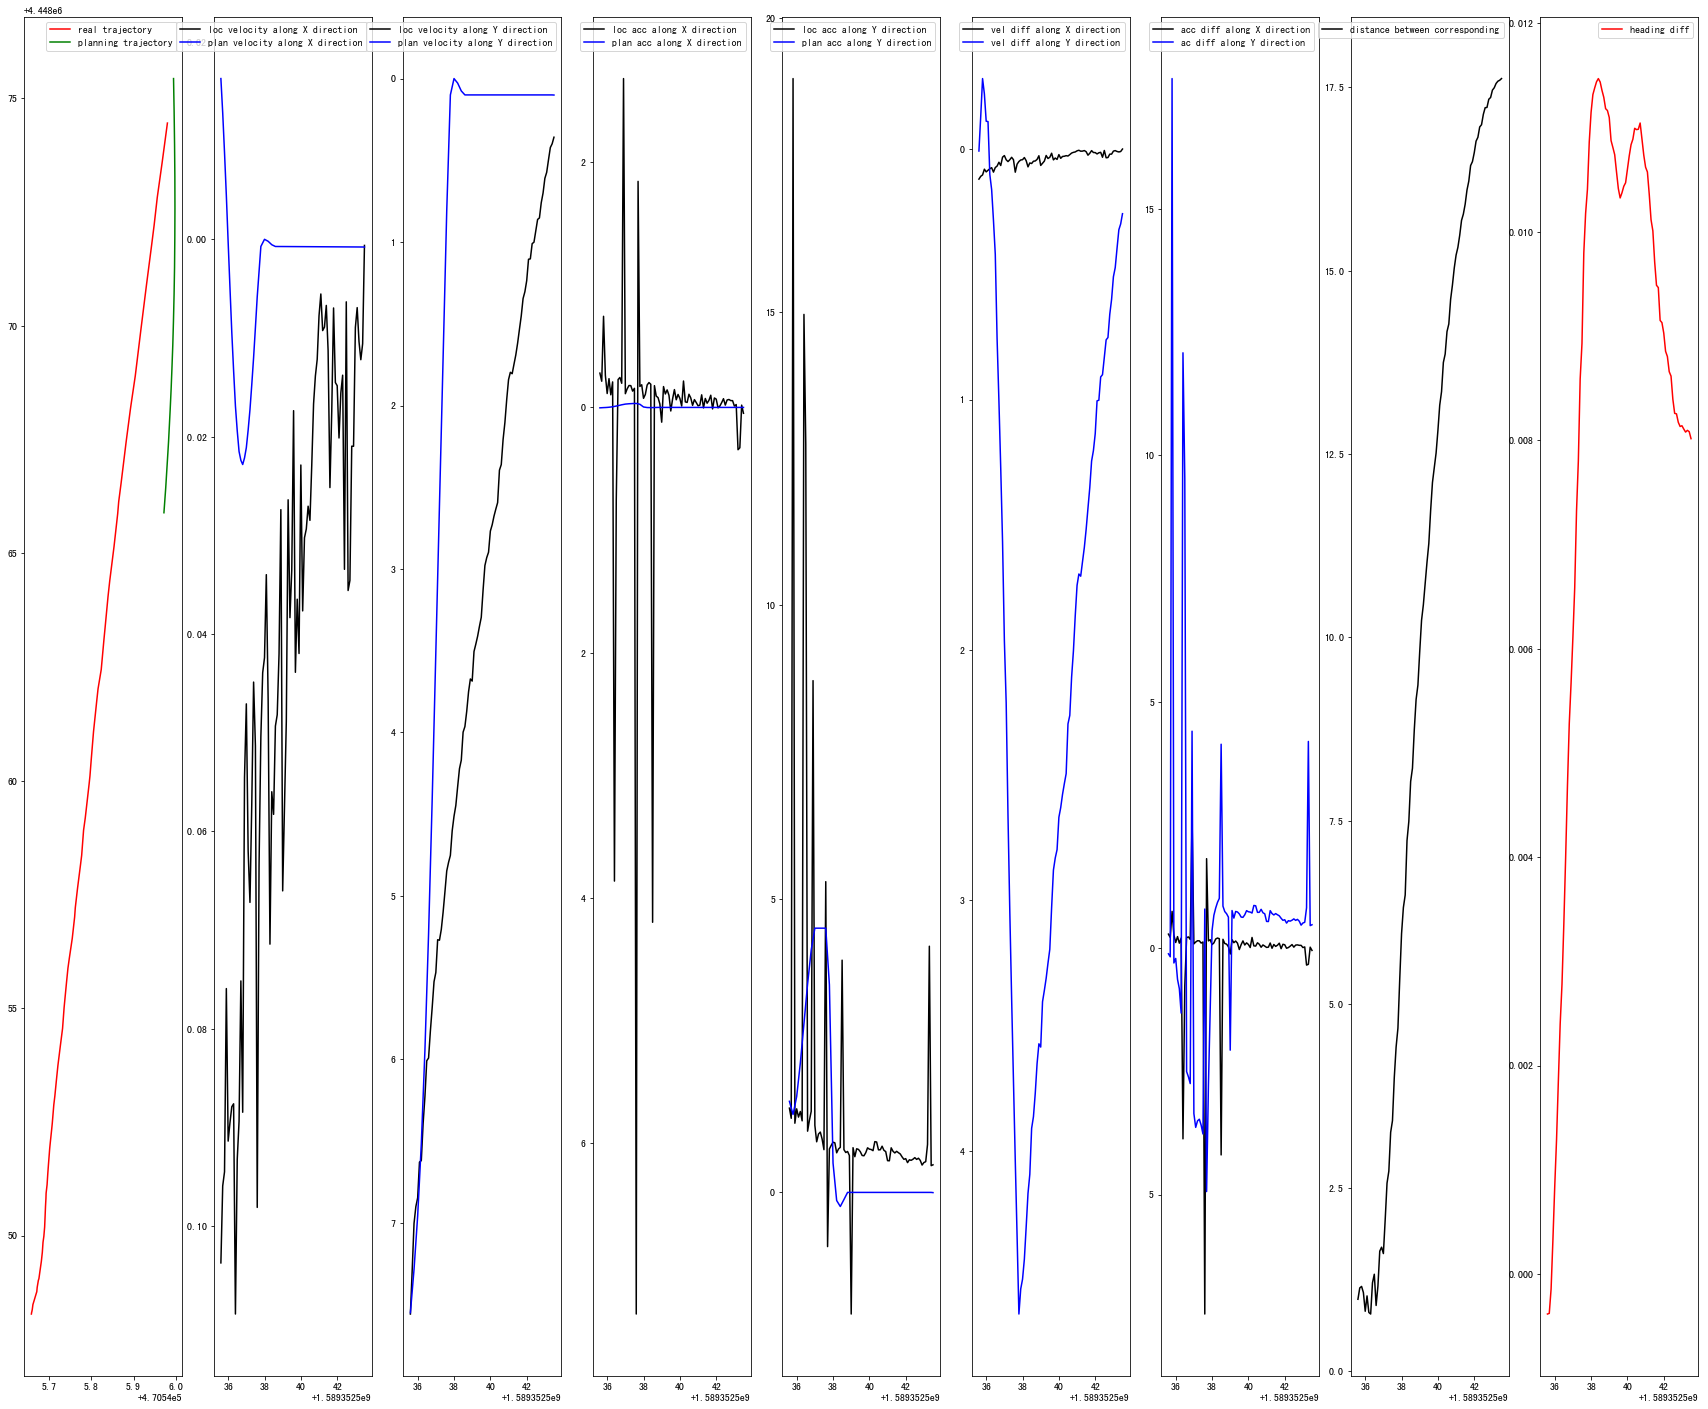

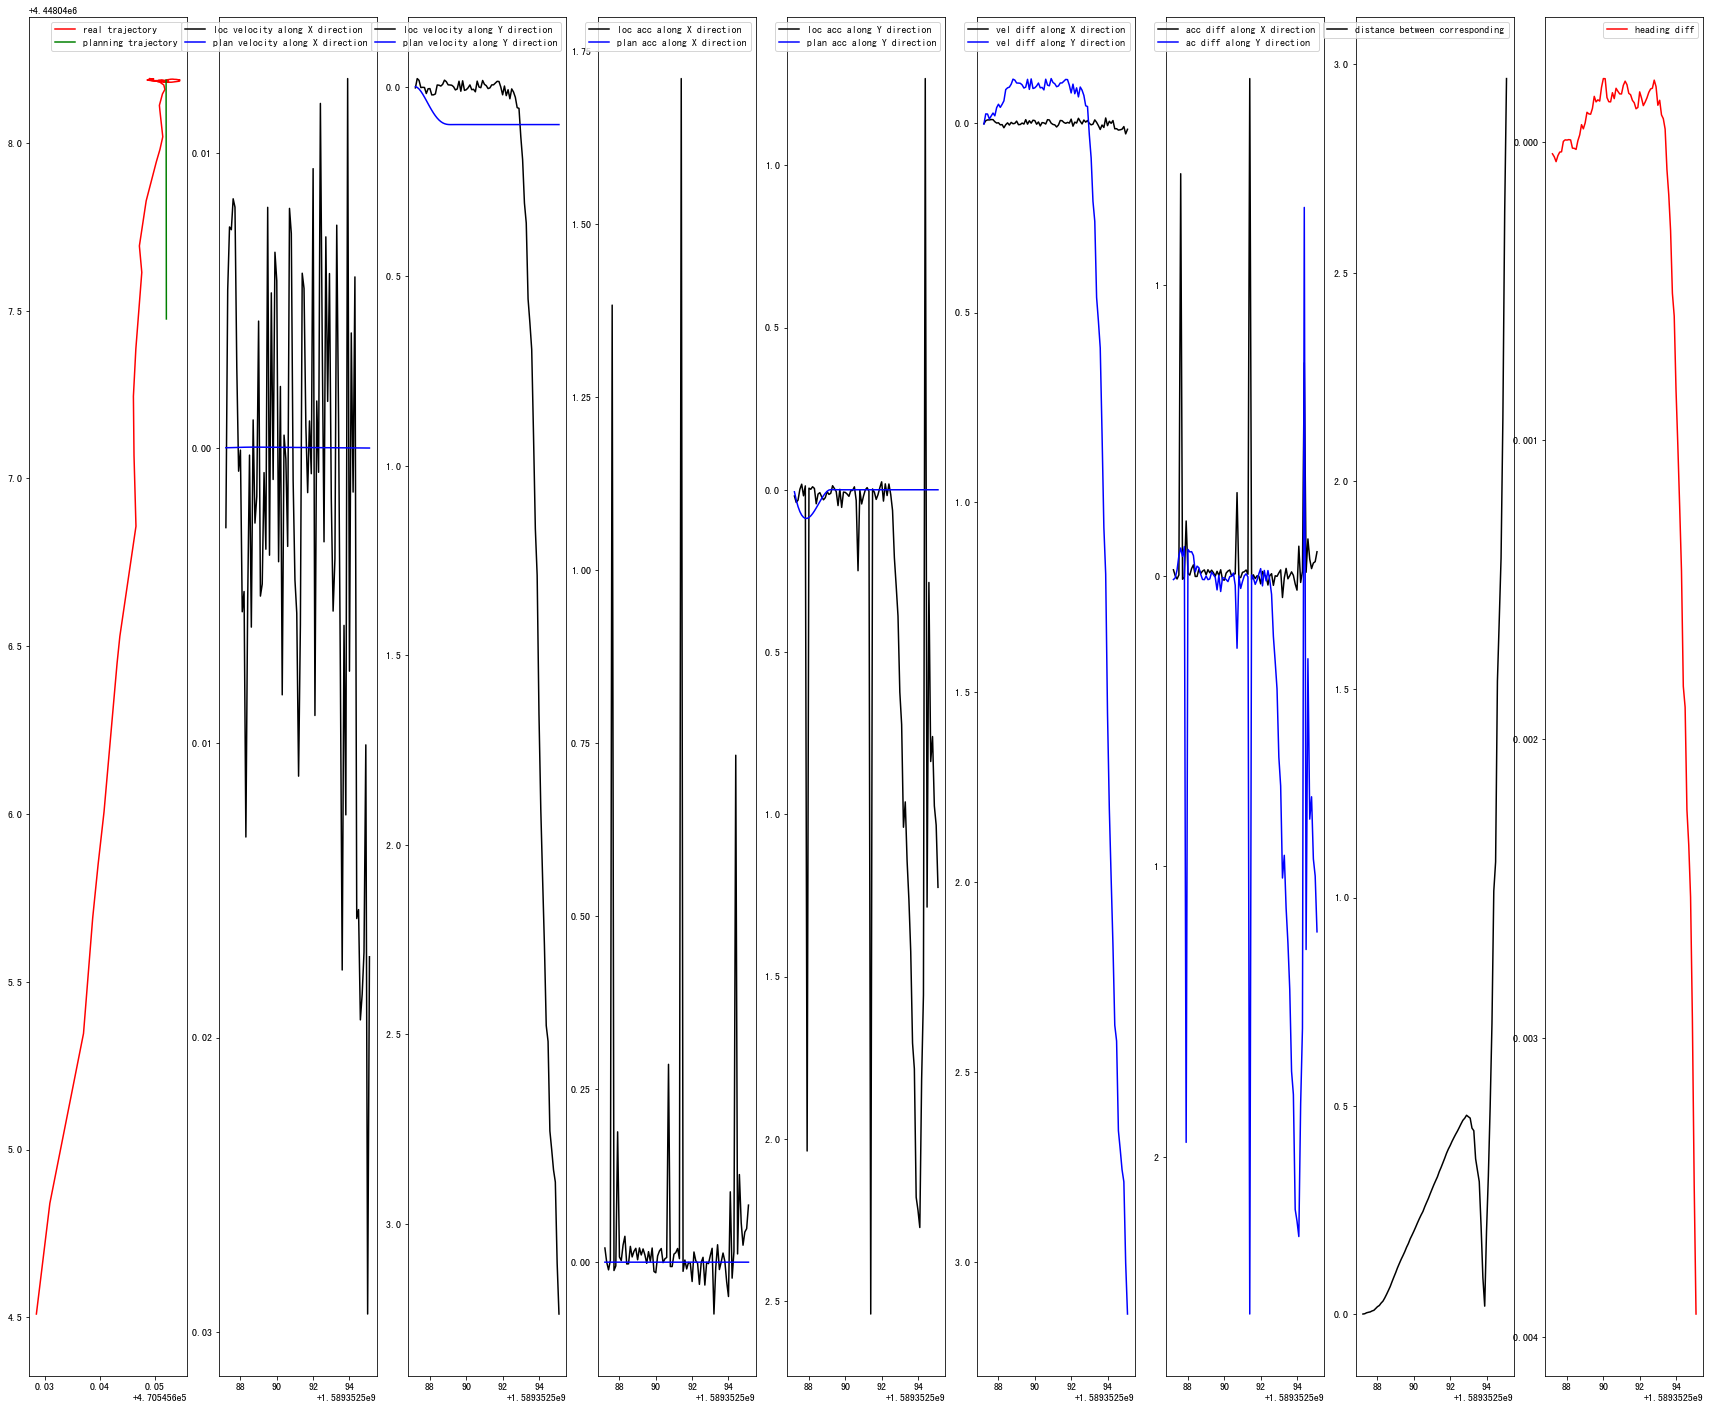

In [100]:
#121
plot_result(localization_frames_121, planning_frames_121)